In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve
from tqdm import tqdm
import pandas as pd
from scipy.stats import entropy
import copy
import math
from environments import SBEOS_Environment
time_dependence = 16
# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transition tuple for experience replay
Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward', 'done', 'priority'))

class PrioritizedReplayBuffer:
    """Prioritized Experience Replay Buffer for important transitions"""
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001, epsilon=1e-6):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha  # How much prioritization to use (0 = no prioritization, 1 = full prioritization)
        self.beta = beta  # Correction factor for importance sampling
        self.beta_increment = beta_increment  # Beta increases over time for stable learning
        self.epsilon = epsilon  # Small constant to avoid zero probabilities
        self.max_priority = 1.0  # Initial priority for new transitions
        
    def push(self, *args):
        """Save a transition to the replay buffer with max priority"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        # Use max priority for new transitions (ensures they're sampled at least once)
        priority = self.max_priority ** self.alpha
        self.priorities[self.position] = priority
        
        # Store transition
        self.memory[self.position] = Transition(*args, priority=priority)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        """Sample a batch of transitions based on their priorities"""
        if len(self.memory) < self.capacity:
            probs = self.priorities[:len(self.memory)] / sum(self.priorities[:len(self.memory)])
        else:
            probs = self.priorities / sum(self.priorities)
            
        # Sample indices based on priorities
        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        
        # Calculate importance sampling weights
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize weights
        
        # Increment beta for next sampling
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        # Get transitions for the sampled indices
        transitions = [self.memory[idx] for idx in indices]
        
        # Return batch with additional metadata
        batch = Transition(*zip(*transitions))
        return batch, weights, indices
    
    def update_priorities(self, indices, priorities):
        """Update priorities based on TD errors"""
        for idx, priority in zip(indices, priorities):
            # Add small epsilon to avoid zero priority
            priority = (priority + self.epsilon) ** self.alpha
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return len(self.memory)

class NoisyLinear(nn.Module):
    """Noisy linear layer for exploration"""
    def __init__(self, in_features, out_features, std_init=0.1):
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        
        # Mean weights and biases
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))
        
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))
        
        self.reset_parameters()
        self.reset_noise()
        
    def reset_parameters(self):
        """Initialize parameters"""
        mu_range = 1.0 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))
        
    def reset_noise(self):
        """Reset the noise for exploration"""
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        # Outer product
        self.weight_epsilon.copy_(epsilon_out.outer(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)
        
    def _scale_noise(self, size):
        """Scale noise for factorized Gaussian noise"""
        noise = torch.randn(size, device=self.weight_mu.device)
        return torch.sign(noise) * torch.sqrt(torch.abs(noise))
        
    def forward(self, x):
        """Forward pass with noise"""
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
            
        return F.linear(x, weight, bias)

class EnhancedLSTMDQN(nn.Module):
    """Enhanced DQN that combines LSTM for temporal processing with NoisyNets for exploration"""
    def __init__(self, state_size, action_size, hidden_dim=128):
        super(EnhancedLSTMDQN, self).__init__()
        
        # Split state into window and statistical features
        self.window_size = state_size - 6  # Raw window part of state
        
        # LSTM for processing time series window data
        self.window_lstm = nn.LSTM(1, 32, batch_first=True)  # Process each window point individually
        
        # Linear layer for statistical features
        self.stats_layer = nn.Sequential(
            nn.Linear(6, 16),
            nn.LeakyReLU()
        )
        
        # Combined feature processing
        self.combined_layer = nn.Sequential(
            nn.Linear(32 + 16, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        
        # Noisy value stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU()
        )
        self.value_noisy = NoisyLinear(hidden_dim // 2, 1)
        
        # Noisy advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU()
        )
        self.advantage_noisy = NoisyLinear(hidden_dim // 2, action_size)
        
    def forward(self, x, hidden=None):
        # Split input into raw window and statistical features
        batch_size = x.size(0)
        window = x[:, :self.window_size]
        stats = x[:, self.window_size:]
        
        # Reshape window for LSTM processing
        window = window.view(batch_size, self.window_size, 1)  # [batch, seq_len, 1]
        
        # Process window through LSTM
        window_out, lstm_hidden = self.window_lstm(window, hidden)
        window_features = window_out[:, -1, :]  # Take the last LSTM output
        
        # Process statistical features
        stats_features = self.stats_layer(stats)
        
        # Combine features
        combined = torch.cat([window_features, stats_features], dim=1)
        features = self.combined_layer(combined)
        
        # Dueling architecture with noisy layers
        value = self.value_stream(features)
        value = self.value_noisy(value)
        
        advantage = self.advantage_stream(features)
        advantage = self.advantage_noisy(advantage)
        
        # Combine value and advantage using dueling architecture formula
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        return q_values, lstm_hidden
    
    def reset_noise(self):
        """Reset noise for exploration"""
        self.value_noisy.reset_noise()
        self.advantage_noisy.reset_noise()

class EnhancedDQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        memory_size=100000,
        batch_size=128,
        gamma=0.99,
        tau=0.005,  # Soft update parameter
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10000,  # Steps for decay
        learning_rate=0.0003,
        target_update_freq=5,  # Update target every n episodes for hard updates
        double_dqn=True,
        prioritized_replay=True,  # Use prioritized experience replay
        n_step_return=3,  # Number of steps for n-step return
        use_soft_targets=True,  # Use soft target updates
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.double_dqn = double_dqn
        self.learning_rate = learning_rate
        self.n_step_return = n_step_return
        self.use_soft_targets = use_soft_targets
        self.steps_done = 0
        
        # For n-step returns
        self.n_step_buffer = deque(maxlen=n_step_return)
        
        # Initialize replay buffer
        if prioritized_replay:
            self.memory = PrioritizedReplayBuffer(memory_size)
            self.prioritized_replay = True
        else:
            self.memory = deque(maxlen=memory_size)
            self.prioritized_replay = False
        
        # Initialize LSTM-DQN networks with NoisyNets
        self.policy_net = EnhancedLSTMDQN(state_size, action_size).to(device)
        self.target_net = EnhancedLSTMDQN(state_size, action_size).to(device)
        self.hidden = None  # LSTM hidden state
            
        # Initialize target network with policy network weights
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Set target network to evaluation mode
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Learning rate scheduler for adaptive learning
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=10
        )
        
        # Training metrics
        self.rewards_history = []
        self.losses = []
        self.accuracies = []
        self.predictions = []
        self.true_states = []
        
        # Episode tracking for target updates
        self.episode_count = 0
        
    def select_action(self, state, evaluate=False, hidden=None):
        """Select an action using policy"""
        # Convert state to tensor
        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state_tensor = torch.FloatTensor(state).to(device)
            else:
                state_tensor = torch.FloatTensor([state]).to(device)
                
            # Make sure it has batch dimension
            if state_tensor.dim() == 1:
                state_tensor = state_tensor.unsqueeze(0)
            
            # Get Q-values
            q_values, new_hidden = self.policy_net(state_tensor, hidden)
            
            # Epsilon-greedy only needed as backup since we use NoisyNets
            if evaluate or random.random() > self.epsilon:
                return q_values.argmax(1).item(), new_hidden
            else:
                return random.randrange(self.action_size), new_hidden
    
    def update_epsilon(self):
        """Update epsilon using exponential decay (backup exploration)"""
        self.epsilon = self.epsilon_end + (self.epsilon - self.epsilon_end) * \
                       math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
    
    def remember(self, state, action, reward, next_state, done):
        """Store transition in replay memory with n-step returns"""
        # Store transition in the n-step buffer
        self.n_step_buffer.append((state, action, reward, next_state, done))
        
        # If the n-step buffer is full, compute n-step return
        if len(self.n_step_buffer) == self.n_step_return:
            state, action, n_reward, next_state, done = self.get_n_step_info()
            
            if self.prioritized_replay:
                # Initially use max priority for new experiences
                self.memory.push(state, action, next_state, n_reward, done)
            else:
                self.memory.append((state, action, next_state, n_reward, done))
    
    def get_n_step_info(self):
        """Get n-step transition info from n-step buffer"""
        # Get first transition from buffer
        state, action, reward, next_state, done = self.n_step_buffer[0]
        
        # Calculate cumulative reward with discount
        for idx in range(1, len(self.n_step_buffer)):
            r, next_s, d = self.n_step_buffer[idx][2:5]
            reward = reward + self.gamma ** idx * r
            
            # If transition is terminal, break
            if d:
                done = True
                next_state = next_s
                break
        
        return state, action, reward, next_state, done
    
    def replay(self):
        """Train the model with experiences from replay buffer"""
        if self.prioritized_replay and len(self.memory) < self.batch_size:
            return 0
        elif not self.prioritized_replay and len(self.memory) < self.batch_size:
            return 0
        
        # Sample batch from replay buffer
        if self.prioritized_replay:
            transitions, weights, indices = self.memory.sample(self.batch_size)
            weights = torch.FloatTensor(weights).to(device)
            
            # Convert batch to tensors
            state_batch = torch.FloatTensor(np.array(transitions.state)).to(device)
            action_batch = torch.LongTensor(transitions.action).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(transitions.reward).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(np.array(transitions.next_state)).to(device)
            done_batch = torch.FloatTensor(transitions.done).unsqueeze(1).to(device)
        else:
            # Randomly sample from memory
            transitions = random.sample(self.memory, self.batch_size)
            state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*transitions)
            
            # Convert to tensors
            state_batch = torch.FloatTensor(np.array(state_batch)).to(device)
            action_batch = torch.LongTensor(action_batch).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(np.array(next_state_batch)).to(device)
            done_batch = torch.FloatTensor(done_batch).unsqueeze(1).to(device)
            weights = torch.ones_like(reward_batch)
        
        # Compute current Q values
        current_q_values, _ = self.policy_net(state_batch)
        current_q_values = current_q_values.gather(1, action_batch)
        
        # Compute next Q values based on algorithm choice
        with torch.no_grad():
            if self.double_dqn:
                # Double DQN: Use policy network to select actions
                next_q_values_policy, _ = self.policy_net(next_state_batch)
                next_actions = next_q_values_policy.max(1, keepdim=True)[1]
                
                next_q_values_target, _ = self.target_net(next_state_batch)
                next_q_values = next_q_values_target.gather(1, next_actions)
            else:
                # Standard DQN: Use max Q-value from target network
                next_q_values, _ = self.target_net(next_state_batch)
                next_q_values = next_q_values.max(1, keepdim=True)[0]
            
            # Compute expected Q values
            expected_q_values = reward_batch + self.gamma**self.n_step_return * next_q_values * (1 - done_batch)
        
        # Compute loss (Huber loss for stability)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values, reduction='none')
        
        # Apply importance sampling weights for prioritized replay
        weighted_loss = (loss * weights).mean()
        
        # Compute TD errors for updating priorities
        if self.prioritized_replay:
            with torch.no_grad():
                td_errors = torch.abs(current_q_values - expected_q_values).cpu().numpy()
                self.memory.update_priorities(indices, td_errors)
        
        # Optimize the model
        self.optimizer.zero_grad()
        weighted_loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Reset noise for NoisyNets
        self.policy_net.reset_noise()
        
        return weighted_loss.item()
    
    def update_target_network(self):
        """Update target network weights"""
        # Increment episode counter
        self.episode_count += 1
        
        if self.use_soft_targets:
            # Soft update
            for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
                target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)
        elif self.episode_count % self.target_update_freq == 0:
            # Hard update
            self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def save_model(self, filepath):
        """Save model weights"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps_done': self.steps_done
        }, filepath)
        
    def load_model(self, filepath):
        """Load model weights"""
        checkpoint = torch.load(filepath)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.steps_done = checkpoint['steps_done']
        self.target_net.eval()


def evaluate_episode(env, agent):
    """Evaluate the agent on a single episode without exploration"""
    state = env.reset()
    done = False
    total_reward = 0
    hidden = None
    
    while not done:
        # Select action without exploration
        action, hidden = agent.select_action(state, evaluate=True, hidden=hidden)
        
        # Execute action
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        # Update state
        state = next_state
    
    return total_reward


def train_enhanced_dqn(env, agent, episodes=500, eval_freq=10):
    """Train the enhanced DQN agent"""
    # Record best model for early stopping
    best_reward = float('-inf')
    best_model = None
    no_improvement_count = 0
    
    # Training metrics
    episode_rewards = []
    all_predictions = []
    all_true_states = []
    training_losses = []
    
    # Episode window for tracking improvement
    window_size = 10
    window_rewards = deque(maxlen=window_size)
    
    # Training loop
    for episode in tqdm(range(episodes), desc="Training Enhanced LSTM-DQN"):
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        steps = 0
        done = False
        
        # Clear LSTM hidden state at episode start
        agent.hidden = None
        
        # Episode experience collection
        episode_predictions = []
        episode_true_states = []
        
        while not done:
            # Select action
            action, agent.hidden = agent.select_action(state, hidden=agent.hidden)
            
            # Execute action
            next_state, reward, done, info = env.step(action)
            
            # Record prediction and true state
            episode_predictions.append(action%2)
            episode_true_states.append(info["state"])
            
            # Remember in replay buffer
            agent.remember(state, action, reward, next_state, done)
            
            # Update state
            state = next_state
                
            episode_reward += reward
            steps += 1
            
            # Train the network more frequently for faster learning
            if steps % 4 == 0:
                loss = agent.replay()
                if loss is not None:
                    episode_loss += loss
            
            # Update epsilon for backup exploration
            agent.update_epsilon()
        
        # Additional training at end of episode (multiple updates)
        for _ in range(4):
            loss = agent.replay()
            if loss is not None:
                episode_loss += loss
        
        # Update target network
        agent.update_target_network()
        
        # Record episode metrics
        avg_loss = episode_loss / max(1, steps // 4)
        episode_rewards.append(episode_reward)
        all_predictions.extend(episode_predictions)
        all_true_states.extend(episode_true_states)
        training_losses.append(avg_loss)
        window_rewards.append(episode_reward)
        
        # Calculate accuracy for the episode
        episode_accuracy = np.mean(np.array(episode_predictions) == np.array(episode_true_states))
        
        # Print progress
        if (episode + 1) % 10 == 0:
            window_avg = np.mean(window_rewards)
            print(f"Episode: {episode+1}, Reward: {episode_reward:.2f}, Avg Reward (last {window_size}): {window_avg:.2f}, "
                  f"Accuracy: {episode_accuracy:.4f}, Loss: {avg_loss:.6f}, Epsilon: {agent.epsilon:.4f}")
            
            # Update learning rate based on performance
            agent.scheduler.step(window_avg)
        
        # Save best model
        if len(window_rewards) == window_size:
            window_avg = np.mean(window_rewards)
            if window_avg > best_reward:
                best_reward = window_avg
                best_model = copy.deepcopy(agent.policy_net.state_dict())
                no_improvement_count = 0
                print(f"New best model saved! Avg reward: {best_reward:.2f}")
            else:
                no_improvement_count += 1
        
        # Early stopping if no improvement for a while
        if no_improvement_count >= 30:
            print(f"Early stopping after {episode+1} episodes - no improvement for 30 episodes")
            if best_model is not None:
                agent.policy_net.load_state_dict(best_model)
            break
                
        # Evaluate agent periodically
        if (episode + 1) % eval_freq == 0:
            eval_reward = evaluate_episode(env, agent)
            print(f"Evaluation at episode {episode+1}: Reward = {eval_reward:.2f}")
            
    # Update agent metrics
    agent.rewards_history = episode_rewards
    agent.losses = training_losses
    agent.predictions = all_predictions
    agent.true_states = all_true_states
    
    # If training completed without early stopping, load best model
    if best_model is not None and episode == episodes - 1:
        agent.policy_net.load_state_dict(best_model)
        
    # Calculate final accuracy
    final_accuracy = np.mean(np.array(all_predictions) == np.array(all_true_states))
    print(f"Training completed. Final accuracy: {final_accuracy:.4f}")
    
    return agent, episode_rewards, training_losses


def plot_training_results(rewards, losses, predictions=None, true_states=None):
    """Plot training metrics and model performance"""
    plt.figure(figsize=(18, 10))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(rewards, label='Episode Reward')
    plt.plot(pd.Series(rewards).rolling(10).mean(), 'r-', label='Moving Average (10)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.grid(True)
    
    # Plot losses
    plt.subplot(2, 2, 2)
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    # Plot accuracy if predictions and true states are provided
    if predictions is not None and true_states is not None:
        plt.subplot(2, 2, 3)
        
        # Calculate accuracy over time
        window = 100
        accuracies = []
        for i in range(0, len(predictions), window):
            end = min(i + window, len(predictions))
            acc = np.mean(np.array(predictions[i:end]) == np.array(true_states[i:end]))
            accuracies.append(acc)
        
        plt.plot(range(0, len(predictions), window), accuracies)
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.title('Prediction Accuracy')
        plt.grid(True)
        
        # Confusion matrix
        plt.subplot(2, 2, 4)
        cm = confusion_matrix(true_states, predictions)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        classes = ['State 0', 'State 1']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        plt.ylabel('True State')
        plt.xlabel('Predicted State')
    
    plt.tight_layout()
    plt.show()


def run_experiment(seed=42, episodes=300):
    """Run a complete experiment with the SBEOS environment and enhanced DQN agent"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create environment
    env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=time_dependence)
    
    # Get state and action dimensions
    state_dim = len(env.generate_observation_state())
    action_dim = 2  # Binary prediction: 0 or 1
    
    # Create agent with enhanced features
    agent = EnhancedDQNAgent(
        state_size=state_dim,
        action_size=action_dim,
        memory_size=50000,
        batch_size=64,
        gamma=0.99,
        tau=0.005,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10000,
        learning_rate=0.0003,
        target_update_freq=5,
        double_dqn=True,
        prioritized_replay=True,
        n_step_return=3,
        use_soft_targets=True
    )
    
    # Train agent
    trained_agent, rewards, losses = train_enhanced_dqn(env, agent, episodes=episodes, eval_freq=20)
    
    # Plot results
    plot_training_results(rewards, losses, 
                          predictions=trained_agent.predictions, 
                          true_states=trained_agent.true_states)
    
    # Evaluate final performance
    eval_rewards = []
    for _ in range(20):  # Run 20 evaluation episodes
        reward = evaluate_episode(env, trained_agent)
        eval_rewards.append(reward)
    
    avg_reward = np.mean(eval_rewards)
    print(f"Final evaluation - Average reward over 20 episodes: {avg_reward:.2f}")
    
    # Save the trained model
    trained_agent.save_model("enhanced_lstm_dqn_model.pt")
    
    return trained_agent

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
import pandas as pd
import random
from collections import deque
from scipy.stats import entropy
import seaborn as sns

def create_test_environment(seed=None):
    """Create a separate test environment with a different random seed"""
    # Use a different seed for the test environment to ensure different data generation
    if seed is not None:
        np.random.seed(seed)  # Set the numpy random seed
    
    test_env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=time_dependence)
    return test_env

def evaluate_on_test_environment(agent, test_env, num_episodes=100):
    """Evaluate agent performance on a separate test environment"""
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    test_rewards = []
    test_predictions = []
    test_true_states = []
    
    print("\nEvaluating on test environment...")
    
    for i in range(num_episodes):
        state = test_env.reset()
        episode_reward = 0
        done = False
        hidden = None  # Initialize LSTM hidden state for recurrent models
        
        episode_predictions = []
        episode_true_states = []
        
        # Run until episode ends
        while not done:
            # Select action without exploration
            action, hidden = agent.select_action(state, evaluate=True, hidden=hidden)
            
            # Execute action
            next_state, reward, done, info = test_env.step(action)
            
            # Record prediction and true state
            episode_predictions.append(action % 2)  # Convert action to binary prediction
            episode_true_states.append(info["state"])
            
            episode_reward += reward
            
            # Update state
            state = next_state
        
        # Store episode results
        test_rewards.append(episode_reward)
        test_predictions.extend(episode_predictions)
        test_true_states.extend(episode_true_states)
        
        if (i + 1) % 10 == 0:
            print(f"Test episode {i+1}/{num_episodes} completed. Reward: {episode_reward:.2f}")
    
    # Calculate overall metrics
    avg_test_reward = np.mean(test_rewards)
    test_accuracy = accuracy_score(test_true_states, test_predictions)
    
    # Calculate additional performance metrics
    test_precision = precision_score(test_true_states, test_predictions, zero_division=0)
    test_recall = recall_score(test_true_states, test_predictions, zero_division=0)
    test_f1 = f1_score(test_true_states, test_predictions, zero_division=0)
    
    print(f"\nTest Results Summary:")
    print(f"Average reward: {avg_test_reward:.2f}")
    print(f"Prediction accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 score: {test_f1:.4f}")
    
    return {
        'rewards': test_rewards,
        'predictions': test_predictions,
        'true_states': test_true_states,
        'avg_reward': avg_test_reward,
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1
    }

def plot_test_results(test_results):
    """Plot comprehensive test results including metrics and visualizations"""
    plt.figure(figsize=(20, 12))
    
    # Plot test rewards
    plt.subplot(2, 3, 1)
    plt.plot(test_results['rewards'])
    plt.plot(pd.Series(test_results['rewards']).rolling(5).mean(), 'r-', label='Moving Average (5)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Test Rewards (Avg: {test_results["avg_reward"]:.2f})')
    plt.legend()
    plt.grid(True)
    
    # Plot confusion matrix
    plt.subplot(2, 3, 2)
    cm = confusion_matrix(test_results['true_states'], test_results['predictions'])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Acc: {test_results["accuracy"]:.4f})')
    plt.colorbar()
    
    classes = ['State 0', 'State 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True State')
    plt.xlabel('Predicted State')
    
    # Plot ROC curve
    plt.subplot(2, 3, 3)
    # Convert binary predictions to probabilities for ROC curve
    # This is a simplification since we don't have actual probabilities
    y_true = np.array(test_results['true_states'])
    y_pred = np.array(test_results['predictions'])
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # Plot prediction vs true state over time
    plt.subplot(2, 3, 4)
    # Sample a subset of the data for readability
    sample_size = min(500, len(test_results['predictions']))
    sample_indices = np.linspace(0, len(test_results['predictions'])-1, sample_size, dtype=int)
    
    plt.plot(np.array(test_results['true_states'])[sample_indices], 'b-', label='True State')
    plt.plot(np.array(test_results['predictions'])[sample_indices], 'r.', label='Predicted State')
    plt.xlabel('Step')
    plt.ylabel('State')
    plt.title('Prediction vs True State')
    plt.legend()
    plt.grid(True)
    
    # Plot class-wise precision and recall
    plt.subplot(2, 3, 5)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, label=f'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    # Plot histogram of prediction errors
    plt.subplot(2, 3, 6)
    errors = np.array(test_results['predictions']) != np.array(test_results['true_states'])
    error_indices = np.where(errors)[0]
    
    # Create a histogram of error locations
    if len(error_indices) > 0:
        plt.hist(error_indices, bins=30)
        plt.xlabel('Step Index')
        plt.ylabel('Error Count')
        plt.title(f'Distribution of Prediction Errors (Total: {len(error_indices)})')
    else:
        plt.text(0.5, 0.5, 'No prediction errors!', ha='center', va='center')
        plt.title('Distribution of Prediction Errors')
    
    plt.tight_layout()
    
    # Add the detailed accuracy graph
    plot_detailed_test_accuracy(test_results)
    
    return plt


def plot_detailed_test_accuracy(test_results):
    """Generate detailed accuracy visualizations for the test environment"""
    predictions = np.array(test_results['predictions'])
    true_states = np.array(test_results['true_states'])
    
    # Create figure with multiple accuracy visualizations
    plt.figure(figsize=(20, 16))
    
    # 1. Overall Accuracy Score
    plt.subplot(3, 2, 1)
    accuracy = test_results['accuracy']
    plt.bar(['Test Accuracy'], [accuracy], color='blue')
    plt.ylim([0, 1])
    plt.title(f'Overall Test Accuracy: {accuracy:.4f}', fontsize=14)
    plt.grid(axis='y')
    
    # Add accuracy value as text
    plt.text(0, accuracy/2, f"{accuracy:.4f}", 
             ha='center', va='center', fontsize=14, color='white', fontweight='bold')

    # 2. Running/Sliding Window Accuracy
    plt.subplot(3, 2, 2)
    
    # Calculate running accuracy using different window sizes
    window_sizes = [50, 100, 200]
    for window_size in window_sizes:
        running_accuracies = []
        
        for i in range(len(predictions) - window_size + 1):
            window_true = true_states[i:i+window_size]
            window_pred = predictions[i:i+window_size]
            acc = accuracy_score(window_true, window_pred)
            running_accuracies.append(acc)
        
        plt.plot(range(window_size//2, len(running_accuracies) + window_size//2), 
                 running_accuracies, 
                 label=f'Window Size = {window_size}')
    
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.title('Running Accuracy (Sliding Window)', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # 3. Episode-wise Accuracy
    plt.subplot(3, 2, 3)
    
    # We need to reconstruct episodes from the flattened predictions/true_states
    # Assuming each episode has a fixed length (e.g., 500 steps)
    episode_length = 500  # Update this if your episodes have different lengths
    num_complete_episodes = len(predictions) // episode_length
    
    episode_accuracies = []
    for ep in range(num_complete_episodes):
        start_idx = ep * episode_length
        end_idx = (ep + 1) * episode_length
        ep_true = true_states[start_idx:end_idx]
        ep_pred = predictions[start_idx:end_idx]
        ep_acc = accuracy_score(ep_true, ep_pred)
        episode_accuracies.append(ep_acc)
    
    plt.plot(episode_accuracies, marker='o', linestyle='-')
    plt.axhline(y=np.mean(episode_accuracies), color='r', linestyle='--', 
                label=f'Mean: {np.mean(episode_accuracies):.4f}')
    plt.xlabel('Episode')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Episode', fontsize=14)
    plt.grid(True)
    plt.legend()
    
    # 4. Accuracy by State
    plt.subplot(3, 2, 4)
    
    # Calculate accuracy for each state
    state_0_mask = (true_states == 0)
    state_1_mask = (true_states == 1)
    
    accuracy_state_0 = accuracy_score(true_states[state_0_mask], predictions[state_0_mask]) if any(state_0_mask) else 0
    accuracy_state_1 = accuracy_score(true_states[state_1_mask], predictions[state_1_mask]) if any(state_1_mask) else 0
    
    plt.bar(['State 0', 'State 1'], [accuracy_state_0, accuracy_state_1])
    plt.ylim([0, 1])
    plt.title('Accuracy by True State', fontsize=14)
    plt.grid(axis='y')
    
    # Add text labels
    plt.text(0, accuracy_state_0/2, f"{accuracy_state_0:.4f}", 
             ha='center', va='center', color='white', fontweight='bold')
    plt.text(1, accuracy_state_1/2, f"{accuracy_state_1:.4f}", 
             ha='center', va='center', color='white', fontweight='bold')
    
    # 5. Cumulative Accuracy Over Time
    plt.subplot(3, 2, 5)
    
    # Calculate cumulative accuracy at each timestep
    correct_predictions = (predictions == true_states).astype(int)
    cumulative_correct = np.cumsum(correct_predictions)
    cumulative_accuracy = cumulative_correct / np.arange(1, len(predictions) + 1)
    
    plt.plot(cumulative_accuracy)
    plt.xlabel('Step')
    plt.ylabel('Cumulative Accuracy')
    plt.title('Cumulative Accuracy Over Time', fontsize=14)
    plt.grid(True)
    
    # 6. State Transition Analysis (Accuracy when state changes vs remains the same)
    plt.subplot(3, 2, 6)
    
    # Find where state transitions occur
    state_transitions = np.where(np.diff(true_states) != 0)[0] + 1
    
    # Create masks for transition and non-transition points
    transition_mask = np.zeros(len(true_states), dtype=bool)
    transition_mask[state_transitions] = True
    non_transition_mask = ~transition_mask
    
    # Calculate accuracy for transition and non-transition points
    if any(transition_mask):
        transition_accuracy = accuracy_score(true_states[transition_mask], predictions[transition_mask])
    else:
        transition_accuracy = 0
    
    non_transition_accuracy = accuracy_score(true_states[non_transition_mask], predictions[non_transition_mask])
    
    plt.bar(['State Change', 'State Same'], [transition_accuracy, non_transition_accuracy])
    plt.ylim([0, 1])
    plt.title('Accuracy during State Transitions vs. Stable States', fontsize=14)
    plt.grid(axis='y')
    
    # Add text labels
    plt.text(0, transition_accuracy/2, f"{transition_accuracy:.4f}", 
             ha='center', va='center', color='white', fontweight='bold')
    plt.text(1, non_transition_accuracy/2, f"{non_transition_accuracy:.4f}", 
             ha='center', va='center', color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return plt


def compare_train_test_performance(train_results, test_results):
    """Compare training and test performance to assess overfitting"""
    train_accuracy = np.mean(np.array(train_results['predictions']) == np.array(train_results['true_states']))
    test_accuracy = test_results['accuracy']
    
    print("\nTraining vs Test Performance:")
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Accuracy difference: {abs(train_accuracy - test_accuracy):.4f}")
    
    if test_accuracy < 0.9 * train_accuracy:
        print("WARNING: Possible overfitting detected. Test accuracy is significantly lower than training accuracy.")
    else:
        print("Model generalizes well to the test environment.")
    
    # Create visualization of train vs test metrics
    plt.figure(figsize=(15, 6))
    
    # Compare accuracies
    plt.subplot(1, 2, 1)
    plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy])
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.ylim([0, 1])
    plt.grid(axis='y')
    
    # Compare average rewards
    train_avg_reward = np.mean(train_results['rewards'])
    test_avg_reward = test_results['avg_reward']
    
    plt.subplot(1, 2, 2)
    plt.bar(['Training', 'Test'], [train_avg_reward, test_avg_reward])
    plt.ylabel('Average Reward')
    plt.title('Reward Comparison')
    plt.grid(axis='y')
    
    plt.tight_layout()
    
    # Add detailed train vs test accuracy comparison
    plot_detailed_train_test_comparison(train_results, test_results)
    
    return plt


def plot_detailed_train_test_comparison(train_results, test_results):
    """Create detailed comparative visualizations for training and testing accuracy"""
    train_predictions = np.array(train_results['predictions'])
    train_true_states = np.array(train_results['true_states'])
    test_predictions = np.array(test_results['predictions'])
    test_true_states = np.array(test_results['true_states'])
    
    # Calculate overall accuracies
    train_accuracy = np.mean(train_predictions == train_true_states)
    test_accuracy = test_results['accuracy']
    
    plt.figure(figsize=(20, 12))
    
    # 1. Overall Accuracy Comparison
    plt.subplot(2, 2, 1)
    plt.bar(['Training', 'Testing'], [train_accuracy, test_accuracy], color=['green', 'blue'])
    plt.ylim([0, 1])
    plt.title('Training vs. Testing Accuracy', fontsize=16)
    plt.grid(axis='y')
    
    # Add accuracy values as text
    plt.text(0, train_accuracy/2, f"{train_accuracy:.4f}", 
             ha='center', va='center', color='white', fontweight='bold')
    plt.text(1, test_accuracy/2, f"{test_accuracy:.4f}", 
             ha='center', va='center', color='white', fontweight='bold')
    
    # 2. State-wise Accuracy Comparison
    plt.subplot(2, 2, 2)
    
    # Calculate accuracy for each state in training data
    train_state_0_mask = (train_true_states == 0)
    train_state_1_mask = (train_true_states == 1)
    train_acc_state_0 = accuracy_score(train_true_states[train_state_0_mask], 
                                       train_predictions[train_state_0_mask]) if any(train_state_0_mask) else 0
    train_acc_state_1 = accuracy_score(train_true_states[train_state_1_mask], 
                                       train_predictions[train_state_1_mask]) if any(train_state_1_mask) else 0
    
    # Calculate accuracy for each state in test data
    test_state_0_mask = (test_true_states == 0)
    test_state_1_mask = (test_true_states == 1)
    test_acc_state_0 = accuracy_score(test_true_states[test_state_0_mask], 
                                     test_predictions[test_state_0_mask]) if any(test_state_0_mask) else 0
    test_acc_state_1 = accuracy_score(test_true_states[test_state_1_mask], 
                                     test_predictions[test_state_1_mask]) if any(test_state_1_mask) else 0
    
    # Create grouped bar chart
    width = 0.35
    x = np.array([0, 1])
    
    plt.bar(x - width/2, [train_acc_state_0, train_acc_state_1], width, label='Training')
    plt.bar(x + width/2, [test_acc_state_0, test_acc_state_1], width, label='Testing')
    
    plt.xlabel('True State')
    plt.ylabel('Accuracy')
    plt.title('State-wise Accuracy Comparison', fontsize=16)
    plt.xticks(x, ['State 0', 'State 1'])
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(axis='y')
    
    # 3. Confusion Matrix Comparison
    plt.subplot(2, 2, 3)
    train_cm = confusion_matrix(train_true_states, train_predictions, normalize='true')
    sns.heatmap(train_cm, annot=True, fmt='.3f', cmap='Greens', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], 
                yticklabels=['True 0', 'True 1'])
    plt.title('Training Confusion Matrix (Normalized)', fontsize=16)
    
    plt.subplot(2, 2, 4)
    test_cm = confusion_matrix(test_true_states, test_predictions, normalize='true')
    sns.heatmap(test_cm, annot=True, fmt='.3f', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], 
                yticklabels=['True 0', 'True 1'])
    plt.title('Testing Confusion Matrix (Normalized)', fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
    return plt


def run_experiment_with_testing(seed=42, episodes=300, test_seed=12345, test_episodes=100):
    """Run a complete experiment with separate training and testing environments"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create training environment
    train_env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=time_dependence)
    
    # Get state and action dimensions
    state_dim = len(train_env.generate_observation_state())
    action_dim = 2  # Binary prediction: 0 or 1
    
    # Create agent with enhanced features
    agent = EnhancedDQNAgent(
        state_size=state_dim,
        action_size=action_dim,
        memory_size=50000,
        batch_size=64,
        gamma=0.99,
        tau=0.005,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10000,
        learning_rate=0.0003,
        target_update_freq=5,
        double_dqn=True,
        prioritized_replay=True,
        n_step_return=3,
        use_soft_targets=True
    )
    
    # Train agent
    trained_agent, rewards, losses = train_enhanced_dqn(train_env, agent, episodes=episodes, eval_freq=20)
    
    # Collect training results
    train_results = {
        'rewards': rewards,
        'losses': losses,
        'predictions': trained_agent.predictions,
        'true_states': trained_agent.true_states
    }
    
    # Plot training results
    plot_training_results(rewards, losses, 
                          predictions=trained_agent.predictions, 
                          true_states=trained_agent.true_states)
    
    # Create separate test environment with different seed
    # Set the numpy random seed before creating the test environment
    np.random.seed(test_seed)
    test_env = create_test_environment()
    
    # Evaluate on test environment
    test_results = evaluate_on_test_environment(trained_agent, test_env, num_episodes=test_episodes)
    
    # Plot test results
    plot_test_results(test_results)
    
    # Compare training and test performance
    compare_train_test_performance(train_results, test_results)
    
    # Save the trained model
    trained_agent.save_model("enhanced_lstm_dqn_model.pt")
    
    print("Experiment with separate testing completed!")
    
    return trained_agent, train_results, test_results


# if __name__ == "__main__":
#     print("Starting Enhanced LSTM-DQN experiment with separate training and testing environments")
#     trained_agent, train_results, test_results = run_experiment_with_testing(
#         episodes=500,
#         test_episodes=100
#     )
#     print("Experiment completed!")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

def save_experiment_results(train_results, test_results, time_dependence, output_dir="results"):
    """
    Save experiment results to CSV files
    
    Parameters:
    -----------
    train_results : dict
        Dictionary containing training results
    test_results : dict
        Dictionary containing test results
    time_dependence : int
        The time dependence value for this experiment
    output_dir : str
        Directory to save results
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save training results
    train_df = pd.DataFrame({
        'episode': range(len(train_results['rewards'])),
        'reward': train_results['rewards'],
        'loss': train_results['losses']
    })
    train_df['time_dependence'] = time_dependence
    train_df.to_csv(f"{output_dir}/train_metrics_td{time_dependence}_{timestamp}.csv", index=False)
    
    # Save training predictions and true states
    train_preds_df = pd.DataFrame({
        'step': range(len(train_results['predictions'])),
        'prediction': train_results['predictions'],
        'true_state': train_results['true_states']
    })
    train_preds_df['time_dependence'] = time_dependence
    train_preds_df.to_csv(f"{output_dir}/train_predictions_td{time_dependence}_{timestamp}.csv", index=False)
    
    # Save test results
    test_df = pd.DataFrame({
        'episode': range(len(test_results['rewards'])),
        'reward': test_results['rewards']
    })
    test_df['time_dependence'] = time_dependence
    test_df.to_csv(f"{output_dir}/test_rewards_td{time_dependence}_{timestamp}.csv", index=False)
    
    # Save test predictions and true states
    test_preds_df = pd.DataFrame({
        'step': range(len(test_results['predictions'])),
        'prediction': test_results['predictions'],
        'true_state': test_results['true_states']
    })
    test_preds_df['time_dependence'] = time_dependence
    test_preds_df.to_csv(f"{output_dir}/test_predictions_td{time_dependence}_{timestamp}.csv", index=False)
    
    # Save summary metrics
    train_accuracy = np.mean(np.array(train_results['predictions']) == np.array(train_results['true_states']))
    summary_df = pd.DataFrame({
        'time_dependence': [time_dependence],
        'train_avg_reward': [np.mean(train_results['rewards'])],
        'train_accuracy': [train_accuracy],
        'test_avg_reward': [test_results['avg_reward']],
        'test_accuracy': [test_results['accuracy']]
    })
    
    # Check if summary file exists, append if it does
    summary_file = f"{output_dir}/experiment_summary.csv"
    if os.path.exists(summary_file):
        existing_summary = pd.read_csv(summary_file)
        updated_summary = pd.concat([existing_summary, summary_df], ignore_index=True)
        updated_summary.to_csv(summary_file, index=False)
    else:
        summary_df.to_csv(summary_file, index=False)
    
    print(f"Results for time_dependence={time_dependence} saved to {output_dir}/")
    return summary_file


def run_and_save_experiment(time_dependence, seed=42, episodes=500, test_seed=12345, test_episodes=100):
    """
    Run experiment with specific time_dependence and save results
    """
    print(f"\n=== Running experiment with time_dependence = {time_dependence} ===\n")
    
    # Store the original time_dependence value
    original_time_dependence = globals().get('time_dependence')
    
    # Set the time_dependence to the new value
    globals()['time_dependence'] = time_dependence
    
    # Run the experiment
    trained_agent, train_results, test_results = run_experiment_with_testing(
        episodes=episodes,
        test_episodes=test_episodes,
        seed=seed,
        test_seed=test_seed
    )
    
    # Save the results
    summary_file = save_experiment_results(train_results, test_results, time_dependence)
    
    # Restore the original time_dependence value if it existed
    if original_time_dependence is not None:
        globals()['time_dependence'] = original_time_dependence
    
    return trained_agent, train_results, test_results, summary_file


def plot_comparative_results(summary_file="results/experiment_summary.csv"):
    """
    Generate comparative plots for different time_dependence values
    
    Parameters:
    -----------
    summary_file : str
        Path to the summary CSV file containing results from different experiments
    """
    if not os.path.exists(summary_file):
        print(f"Error: Summary file {summary_file} not found!")
        return
    
    # Load summary data
    summary_df = pd.read_csv(summary_file)
    
    # Sort by time_dependence
    summary_df = summary_df.sort_values('time_dependence')
    
    # Get unique time_dependence values
    time_deps = summary_df['time_dependence'].unique()
    
    plt.figure(figsize=(20, 15))
    
    # 1. Compare training vs test accuracy across time_dependence values
    plt.subplot(2, 2, 1)
    x = np.arange(len(time_deps))
    width = 0.35
    
    plt.bar(x - width/2, summary_df['train_accuracy'], width, label='Training Accuracy')
    plt.bar(x + width/2, summary_df['test_accuracy'], width, label='Test Accuracy')
    
    plt.xlabel('Time Dependence')
    plt.ylabel('Accuracy')
    plt.title('Training vs Test Accuracy by Time Dependence')
    plt.xticks(x, time_deps)
    plt.legend()
    plt.grid(True, axis='y')
    
    # 2. Compare training vs test rewards across time_dependence values
    plt.subplot(2, 2, 2)
    plt.bar(x - width/2, summary_df['train_avg_reward'], width, label='Training Reward')
    plt.bar(x + width/2, summary_df['test_avg_reward'], width, label='Test Reward')
    
    plt.xlabel('Time Dependence')
    plt.ylabel('Average Reward')
    plt.title('Training vs Test Reward by Time Dependence')
    plt.xticks(x, time_deps)
    plt.legend()
    plt.grid(True, axis='y')
    
    # 3. Compare generalization gap (train accuracy - test accuracy)
    plt.subplot(2, 2, 3)
    generalization_gap = summary_df['train_accuracy'] - summary_df['test_accuracy']
    plt.bar(x, generalization_gap)
    
    plt.xlabel('Time Dependence')
    plt.ylabel('Generalization Gap')
    plt.title('Generalization Gap (Train Accuracy - Test Accuracy)')
    plt.xticks(x, time_deps)
    plt.grid(True, axis='y')
    
    # 4. Plot relationship between time_dependence and test accuracy
    plt.subplot(2, 2, 4)
    plt.plot(summary_df['time_dependence'], summary_df['test_accuracy'], 'o-', linewidth=2)
    
    plt.xlabel('Time Dependence')
    plt.ylabel('Test Accuracy')
    plt.title('Relationship Between Time Dependence and Test Accuracy')
    plt.grid(True)
    
    # Add a trend line if we have enough points
    if len(time_deps) > 2:
        z = np.polyfit(summary_df['time_dependence'], summary_df['test_accuracy'], 1)
        p = np.poly1d(z)
        plt.plot(summary_df['time_dependence'], p(summary_df['time_dependence']), "r--", 
                 label=f"Trend: y={z[0]:.6f}x+{z[1]:.6f}")
        plt.legend()
    
    plt.tight_layout()
    plt.savefig("results/comparative_analysis.png", dpi=300)
    plt.show()
    
    # Create a detailed summary table
    print("\nDetailed Summary Table:")
    print(summary_df.to_string(index=False))
    
    return plt


def run_all_experiments():
    """
    Run experiments for all time_dependence values and generate comparative analysis
    """
    time_dependence_values = [2, 4, 8, 16]
    
    for td in time_dependence_values:
        _, _, _, _ = run_and_save_experiment(
            time_dependence=td,
            episodes=500,
            test_episodes=100
        )
    
    # Generate comparative plots
    plot_comparative_results()
    
    print("\nAll experiments completed and results saved!")


# Example usage:
# run_all_experiments()


=== Running experiment with time_dependence = 2 ===



Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_405191/3901439464.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_405191/3901439464.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:11<09:37,  1.18s/it]

Episode: 10, Reward: 4305.00, Avg Reward (last 10): 2323.50, Accuracy: 0.9062, Loss: 2.303750, Epsilon: 0.0100
New best model saved! Avg reward: 2323.50


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:12<09:30,  1.17s/it]

New best model saved! Avg reward: 2524.50


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:14<09:26,  1.16s/it]

New best model saved! Avg reward: 2908.50


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:15<09:25,  1.16s/it]

New best model saved! Avg reward: 3124.50


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:16<09:24,  1.16s/it]

New best model saved! Avg reward: 3402.00


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:17<09:26,  1.17s/it]

New best model saved! Avg reward: 3718.50


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:18<09:30,  1.18s/it]

New best model saved! Avg reward: 3969.00


Training Enhanced LSTM-DQN:   3%|▎         | 17/500 [00:20<09:37,  1.20s/it]

New best model saved! Avg reward: 4026.00


Training Enhanced LSTM-DQN:   4%|▎         | 18/500 [00:21<09:37,  1.20s/it]

New best model saved! Avg reward: 4131.00


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:22<09:35,  1.20s/it]

New best model saved! Avg reward: 4225.50
Episode: 20, Reward: 4035.00, Avg Reward (last 10): 4198.50, Accuracy: 0.8703, Loss: 2.648282, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:24<10:44,  1.34s/it]

Evaluation at episode 20: Reward = 3930.00


Training Enhanced LSTM-DQN:   4%|▍         | 21/500 [00:25<10:21,  1.30s/it]

New best model saved! Avg reward: 4245.00


Training Enhanced LSTM-DQN:   4%|▍         | 22/500 [00:26<10:06,  1.27s/it]

New best model saved! Avg reward: 4267.50


Training Enhanced LSTM-DQN:   5%|▌         | 25/500 [00:30<10:00,  1.26s/it]

New best model saved! Avg reward: 4338.00


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [00:36<09:51,  1.26s/it]

Episode: 30, Reward: 4560.00, Avg Reward (last 10): 4084.50, Accuracy: 0.9401, Loss: 2.654528, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [00:48<09:56,  1.29s/it]

Episode: 40, Reward: 4605.00, Avg Reward (last 10): 4294.50, Accuracy: 0.9461, Loss: 2.565315, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [00:49<10:58,  1.43s/it]

Evaluation at episode 40: Reward = 3810.00


Training Enhanced LSTM-DQN:   8%|▊         | 41/500 [00:51<10:42,  1.40s/it]

New best model saved! Avg reward: 4366.50


Training Enhanced LSTM-DQN:   8%|▊         | 42/500 [00:52<10:31,  1.38s/it]

New best model saved! Avg reward: 4432.50


Training Enhanced LSTM-DQN:   9%|▊         | 43/500 [00:53<10:23,  1.36s/it]

New best model saved! Avg reward: 4444.50


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [01:03<10:03,  1.34s/it]

Episode: 50, Reward: 4035.00, Avg Reward (last 10): 4302.00, Accuracy: 0.8703, Loss: 2.324819, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 59/500 [01:15<10:10,  1.38s/it]

Episode: 60, Reward: 4170.00, Avg Reward (last 10): 4143.00, Accuracy: 0.8882, Loss: 2.376175, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 60/500 [01:17<11:10,  1.52s/it]

Evaluation at episode 60: Reward = 3645.00


Training Enhanced LSTM-DQN:  14%|█▍        | 70/500 [01:31<10:19,  1.44s/it]

Episode: 70, Reward: 4845.00, Avg Reward (last 10): 4200.00, Accuracy: 0.9780, Loss: 2.302192, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  14%|█▍        | 72/500 [01:36<09:30,  1.33s/it]

Early stopping after 73 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8593


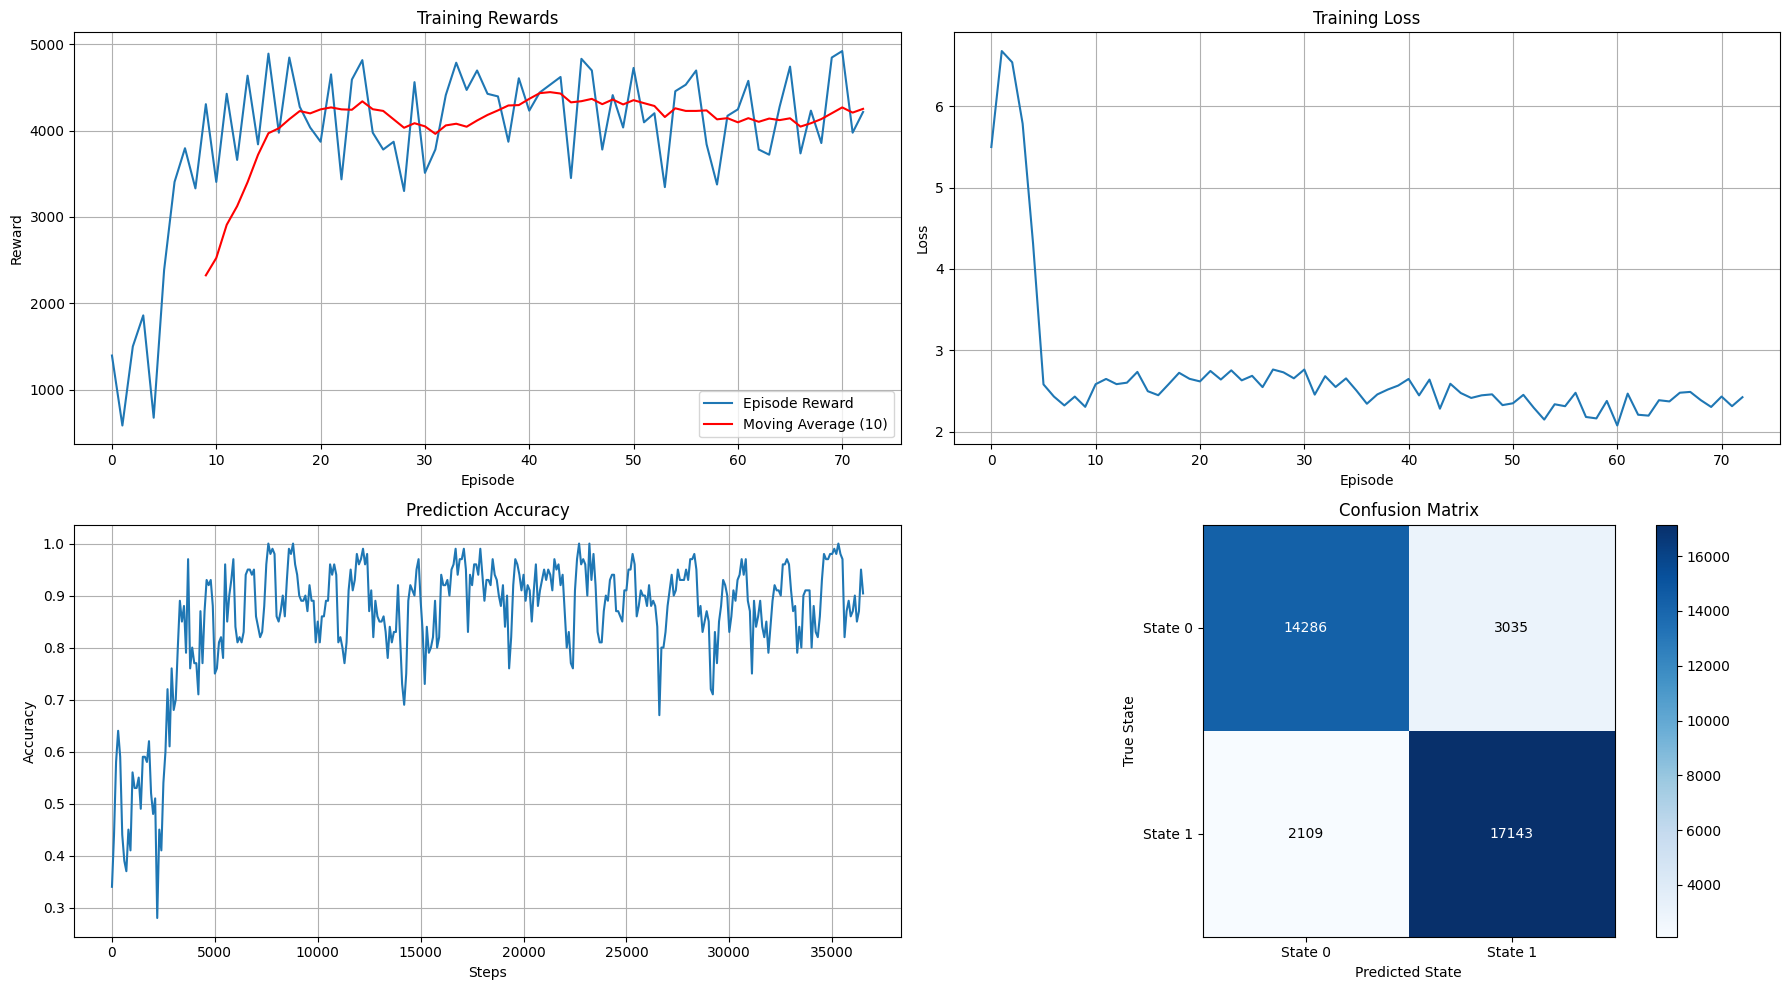


Evaluating on test environment...
Test episode 10/100 completed. Reward: 4695.00
Test episode 20/100 completed. Reward: 4755.00
Test episode 30/100 completed. Reward: 4005.00
Test episode 40/100 completed. Reward: 3720.00
Test episode 50/100 completed. Reward: 4410.00
Test episode 60/100 completed. Reward: 3915.00
Test episode 70/100 completed. Reward: 4260.00
Test episode 80/100 completed. Reward: 3630.00
Test episode 90/100 completed. Reward: 4005.00
Test episode 100/100 completed. Reward: 4725.00

Test Results Summary:
Average reward: 4185.90
Prediction accuracy: 0.8903


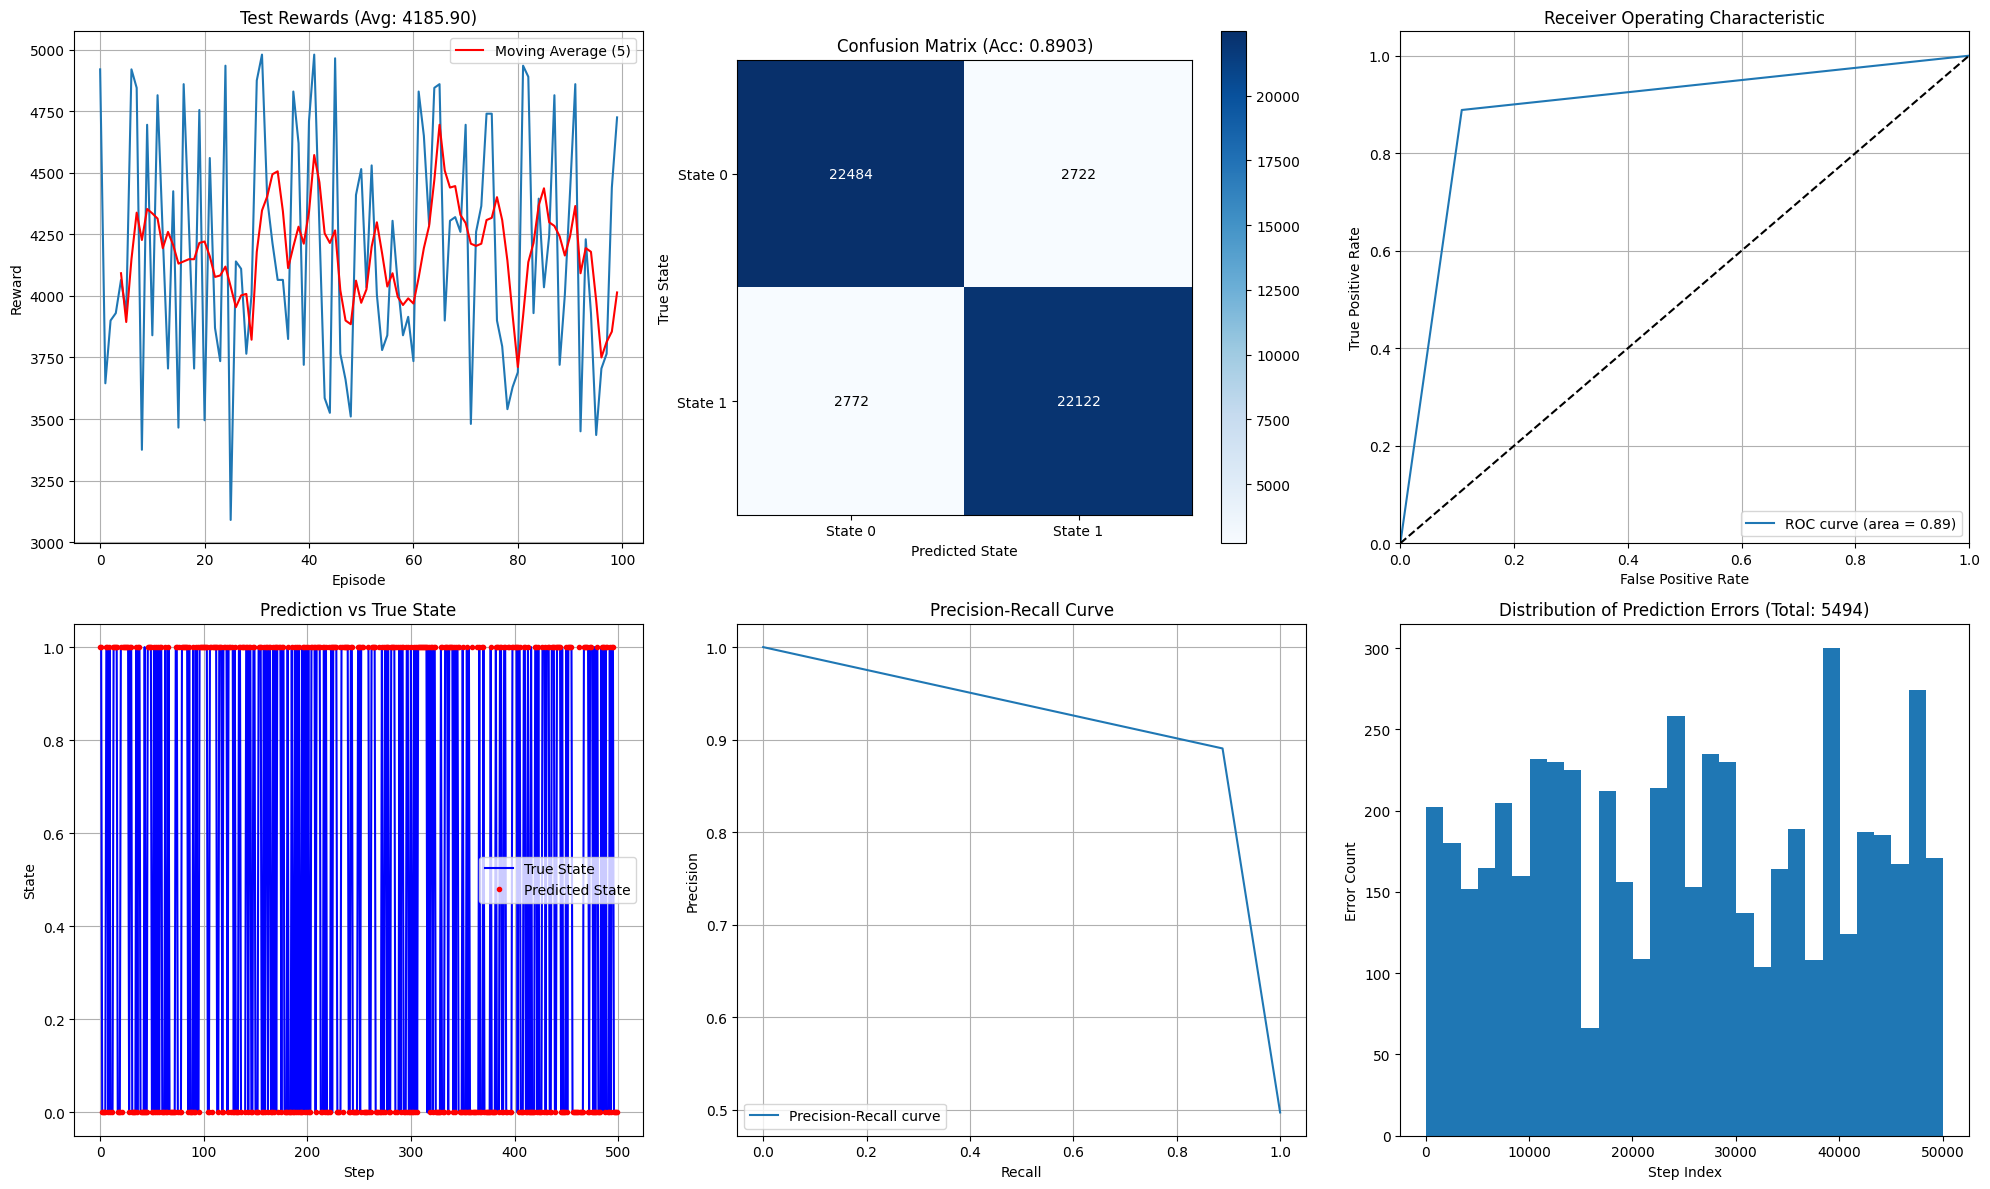

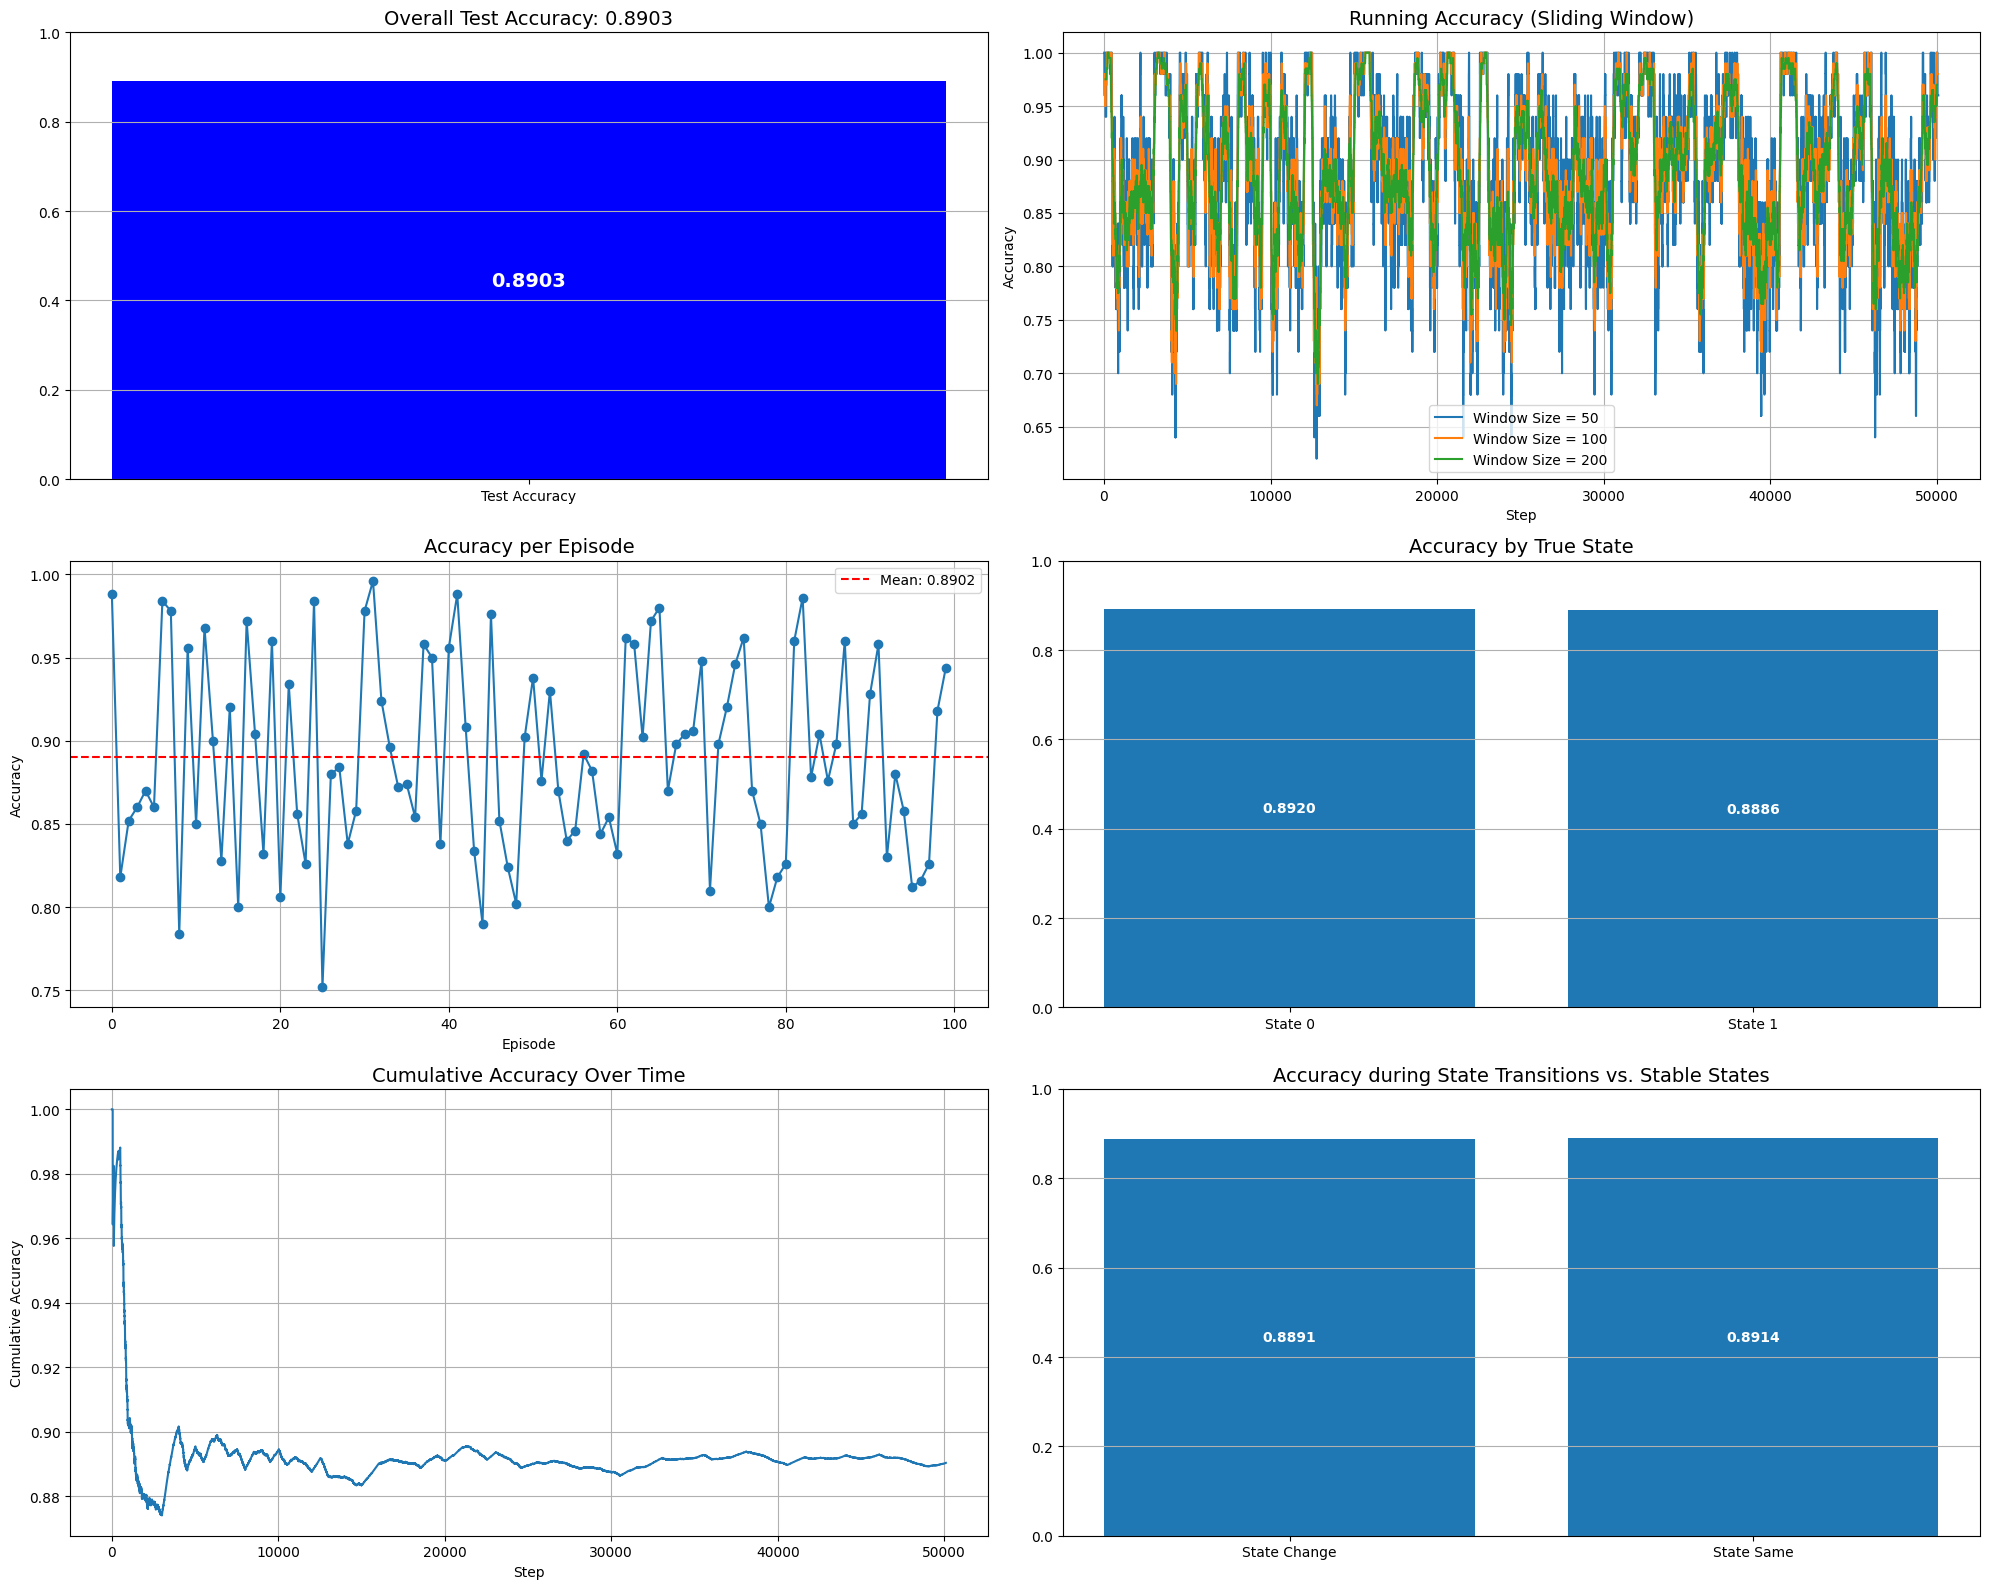


Training vs Test Performance:
Training accuracy: 0.8593
Test accuracy: 0.8903
Accuracy difference: 0.0310
Model generalizes well to the test environment.


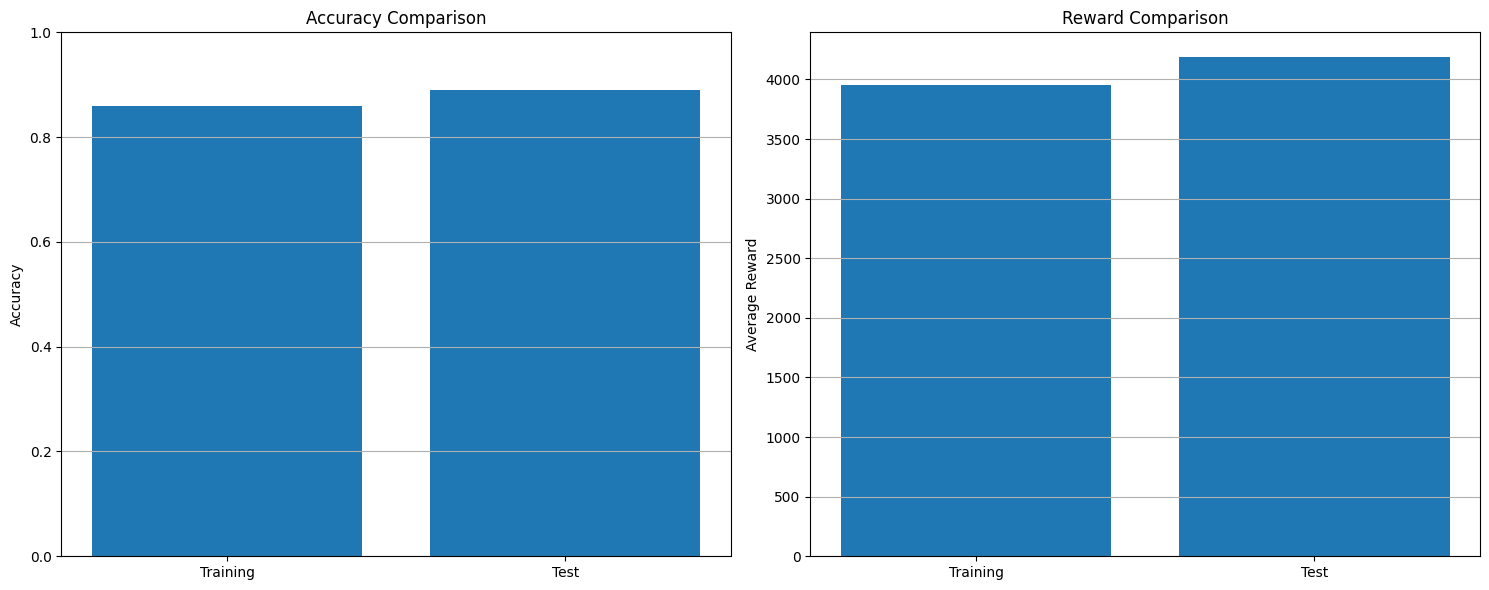

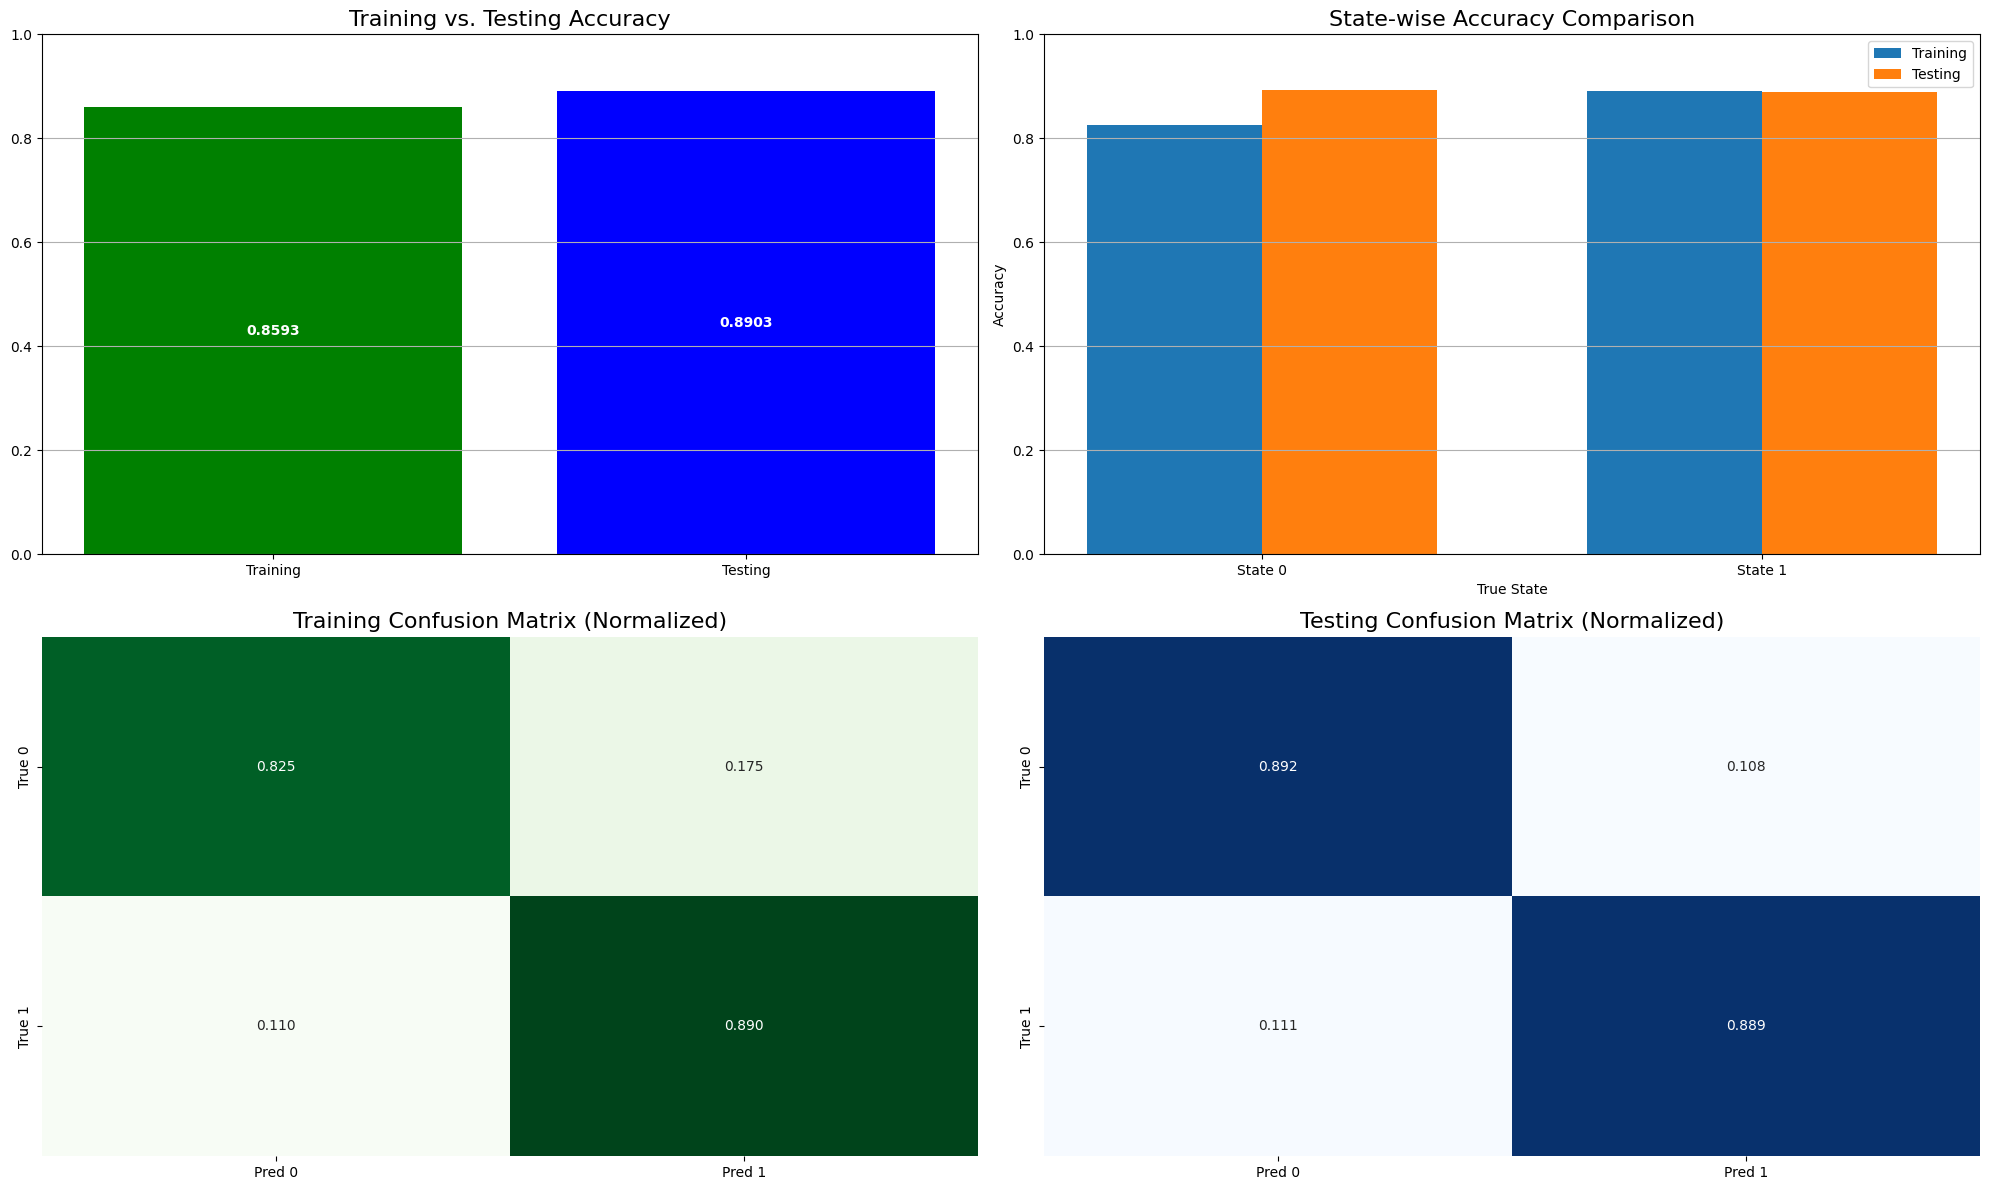

Experiment with separate testing completed!
Results for time_dependence=2 saved to results/

=== Running experiment with time_dependence = 4 ===



Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_405191/3901439464.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_405191/3901439464.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:11<09:08,  1.12s/it]

Episode: 10, Reward: 4305.00, Avg Reward (last 10): 3009.00, Accuracy: 0.9062, Loss: 2.677978, Epsilon: 0.0100
New best model saved! Avg reward: 3009.00


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:12<09:07,  1.12s/it]

New best model saved! Avg reward: 3351.00


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:13<09:06,  1.12s/it]

New best model saved! Avg reward: 3589.50


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:14<09:04,  1.12s/it]

New best model saved! Avg reward: 3895.50


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:15<09:02,  1.12s/it]

New best model saved! Avg reward: 4111.50


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:16<09:00,  1.12s/it]

New best model saved! Avg reward: 4146.00


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:18<09:00,  1.12s/it]

New best model saved! Avg reward: 4155.00


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:21<09:15,  1.15s/it]

Episode: 20, Reward: 4620.00, Avg Reward (last 10): 4182.00, Accuracy: 0.9481, Loss: 2.432247, Epsilon: 0.0100
New best model saved! Avg reward: 4182.00


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:23<10:12,  1.28s/it]

Evaluation at episode 20: Reward = 4455.00


Training Enhanced LSTM-DQN:   4%|▍         | 22/500 [00:25<09:47,  1.23s/it]

New best model saved! Avg reward: 4272.00


Training Enhanced LSTM-DQN:   5%|▍         | 23/500 [00:26<09:32,  1.20s/it]

New best model saved! Avg reward: 4296.00


Training Enhanced LSTM-DQN:   5%|▌         | 26/500 [00:30<09:23,  1.19s/it]

New best model saved! Avg reward: 4297.50


Training Enhanced LSTM-DQN:   5%|▌         | 27/500 [00:31<09:20,  1.18s/it]

New best model saved! Avg reward: 4351.50


Training Enhanced LSTM-DQN:   6%|▌         | 28/500 [00:32<09:10,  1.17s/it]

New best model saved! Avg reward: 4357.50


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [00:34<09:27,  1.21s/it]

Episode: 30, Reward: 3540.00, Avg Reward (last 10): 4174.50, Accuracy: 0.8044, Loss: 2.475370, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [00:47<10:58,  1.43s/it]

Episode: 40, Reward: 4770.00, Avg Reward (last 10): 4147.50, Accuracy: 0.9681, Loss: 2.505371, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [00:49<12:07,  1.58s/it]

Evaluation at episode 40: Reward = 4830.00


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [01:04<11:17,  1.51s/it]

Episode: 50, Reward: 3510.00, Avg Reward (last 10): 4020.00, Accuracy: 0.8004, Loss: 2.343635, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  11%|█▏        | 57/500 [01:16<09:57,  1.35s/it]

Early stopping after 58 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8590


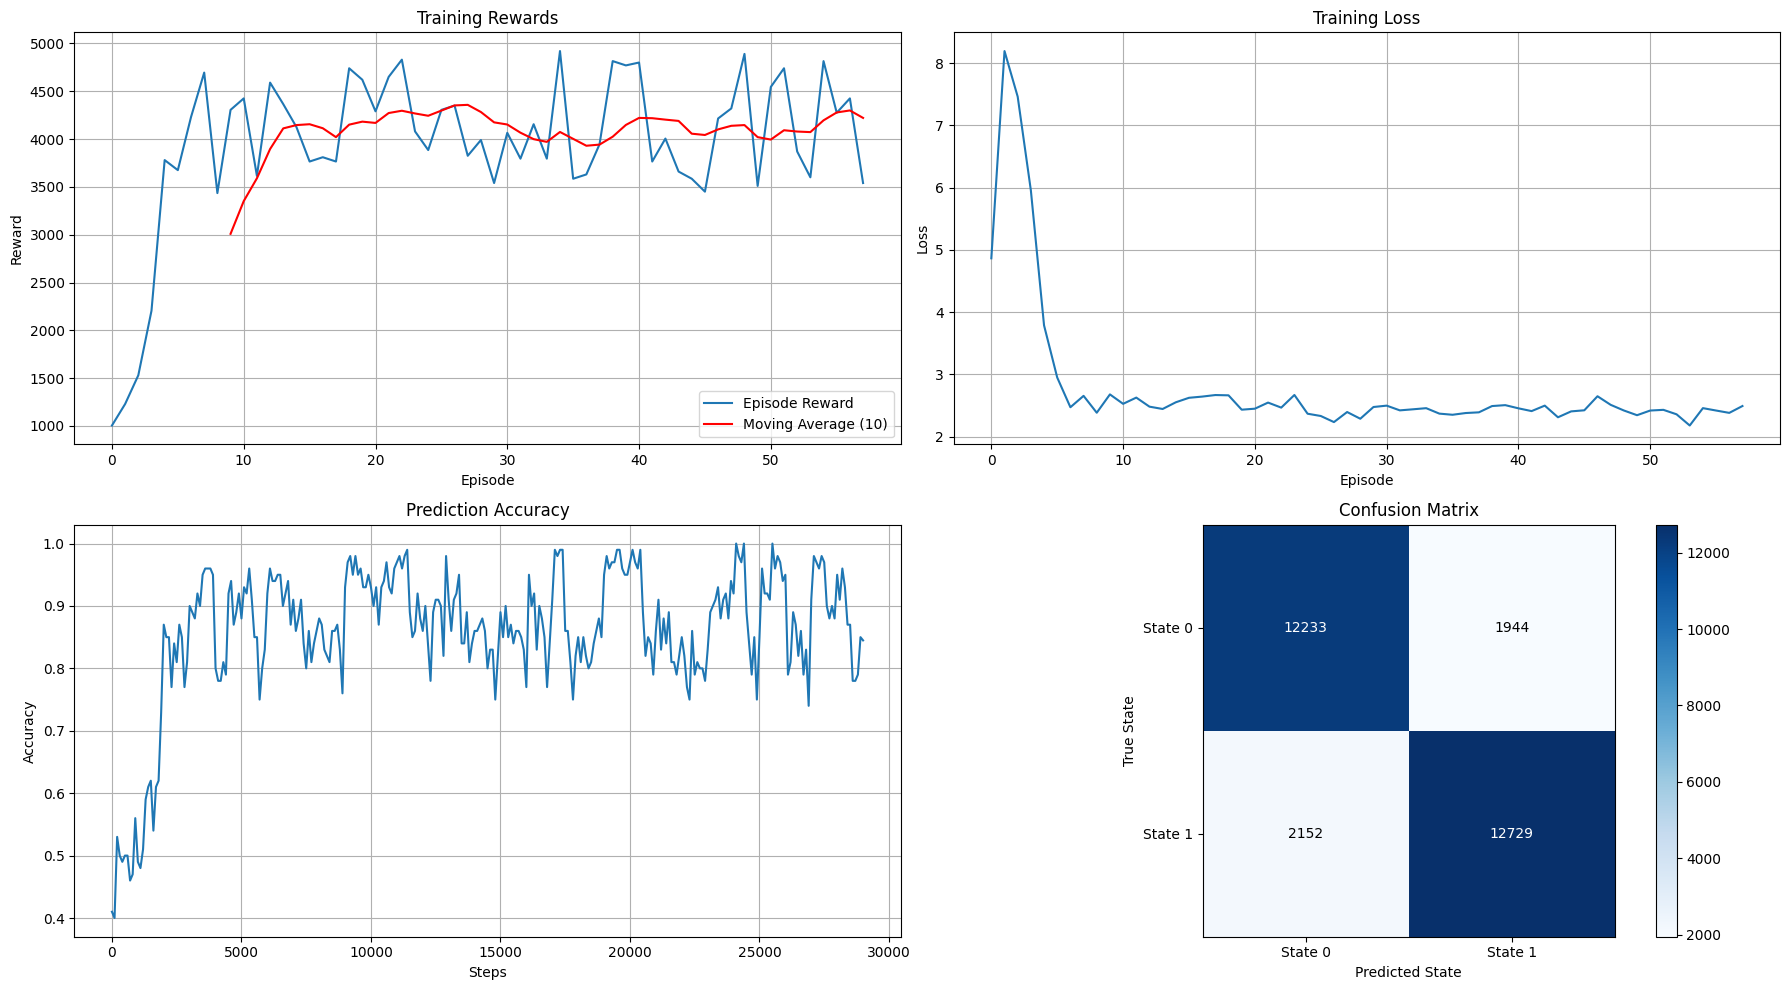


Evaluating on test environment...
Test episode 10/100 completed. Reward: 3840.00
Test episode 20/100 completed. Reward: 3750.00
Test episode 30/100 completed. Reward: 3510.00
Test episode 40/100 completed. Reward: 4575.00
Test episode 50/100 completed. Reward: 3705.00
Test episode 60/100 completed. Reward: 4950.00
Test episode 70/100 completed. Reward: 3900.00
Test episode 80/100 completed. Reward: 3510.00
Test episode 90/100 completed. Reward: 4260.00
Test episode 100/100 completed. Reward: 3615.00

Test Results Summary:
Average reward: 4211.10
Prediction accuracy: 0.8937


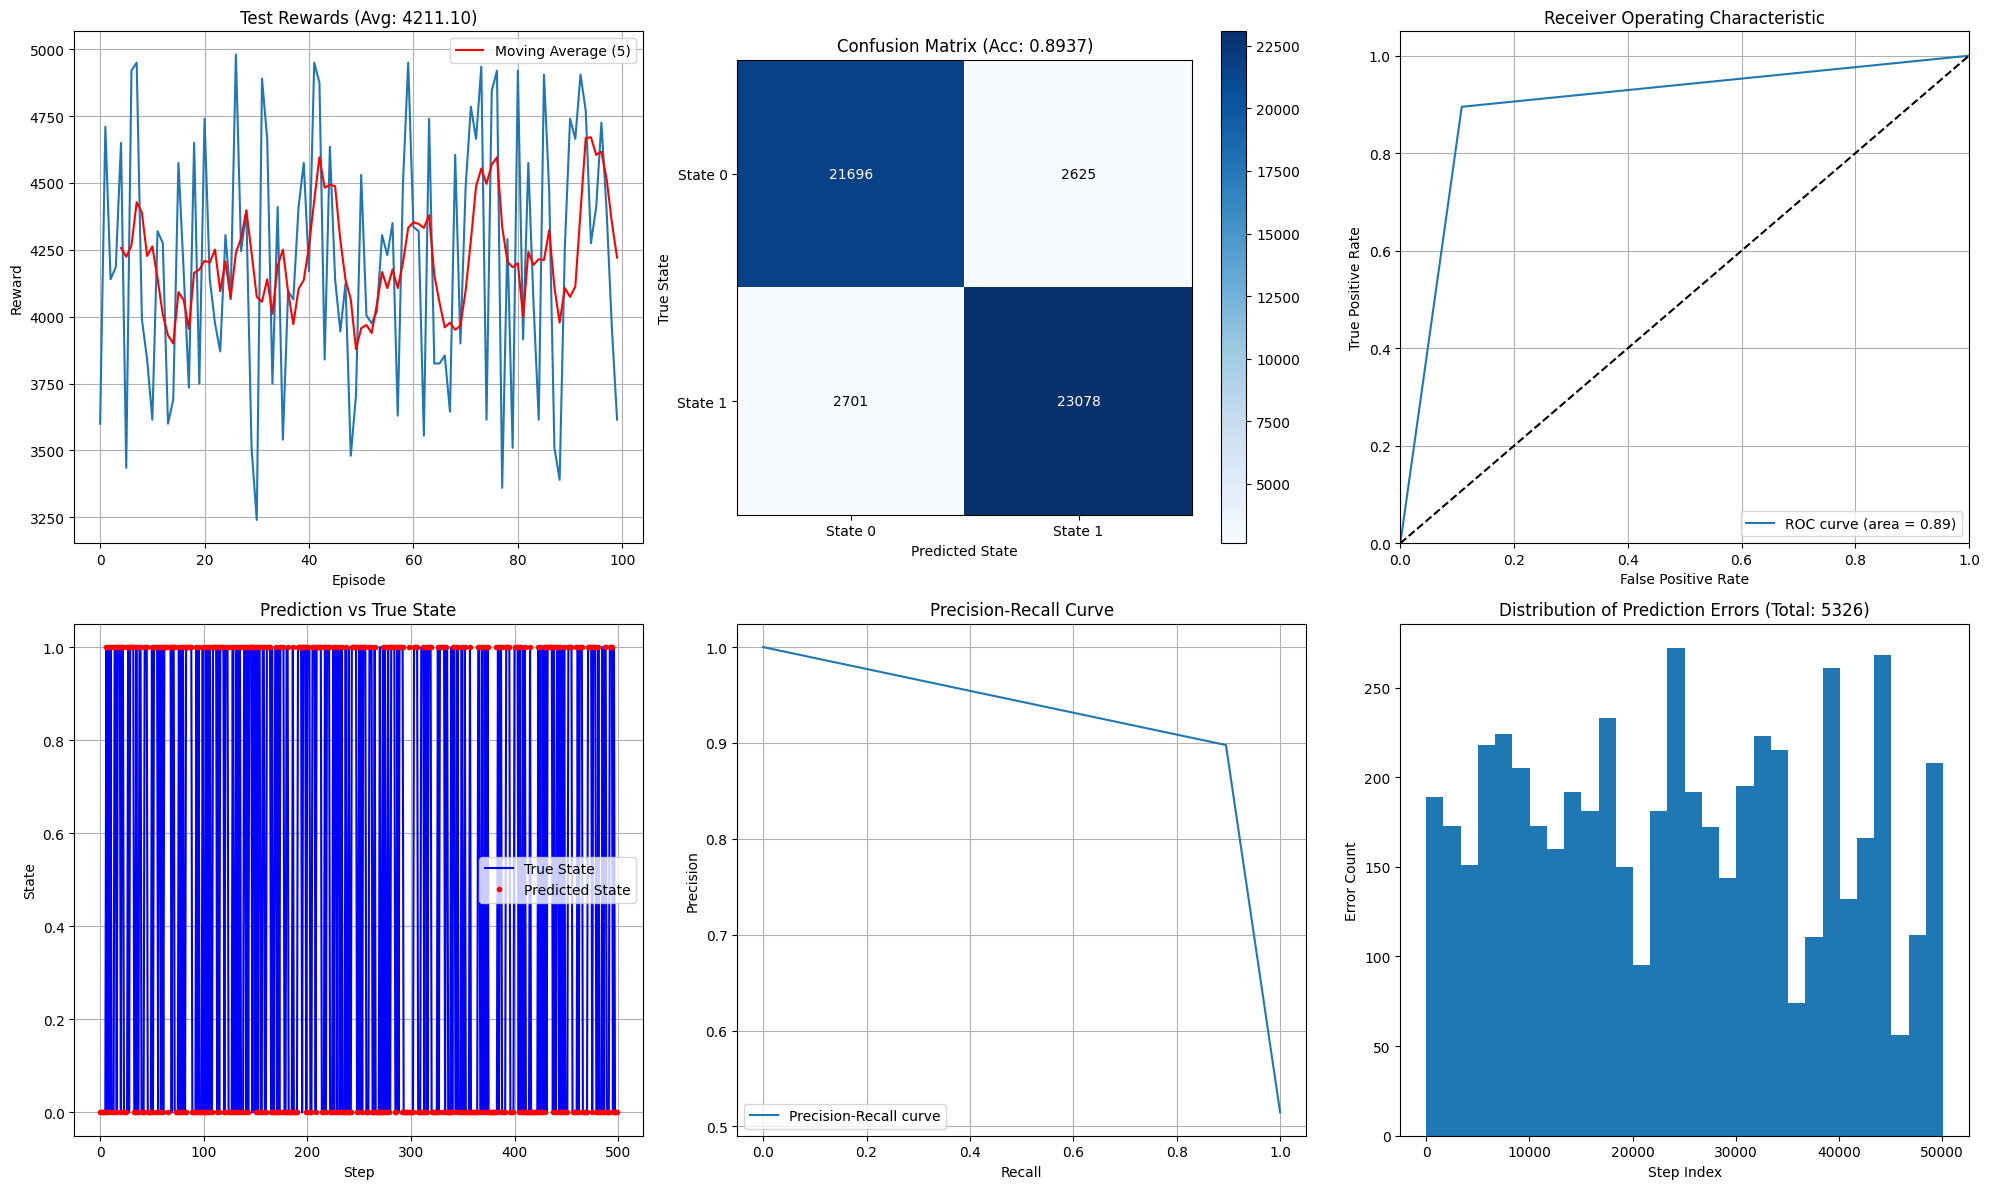

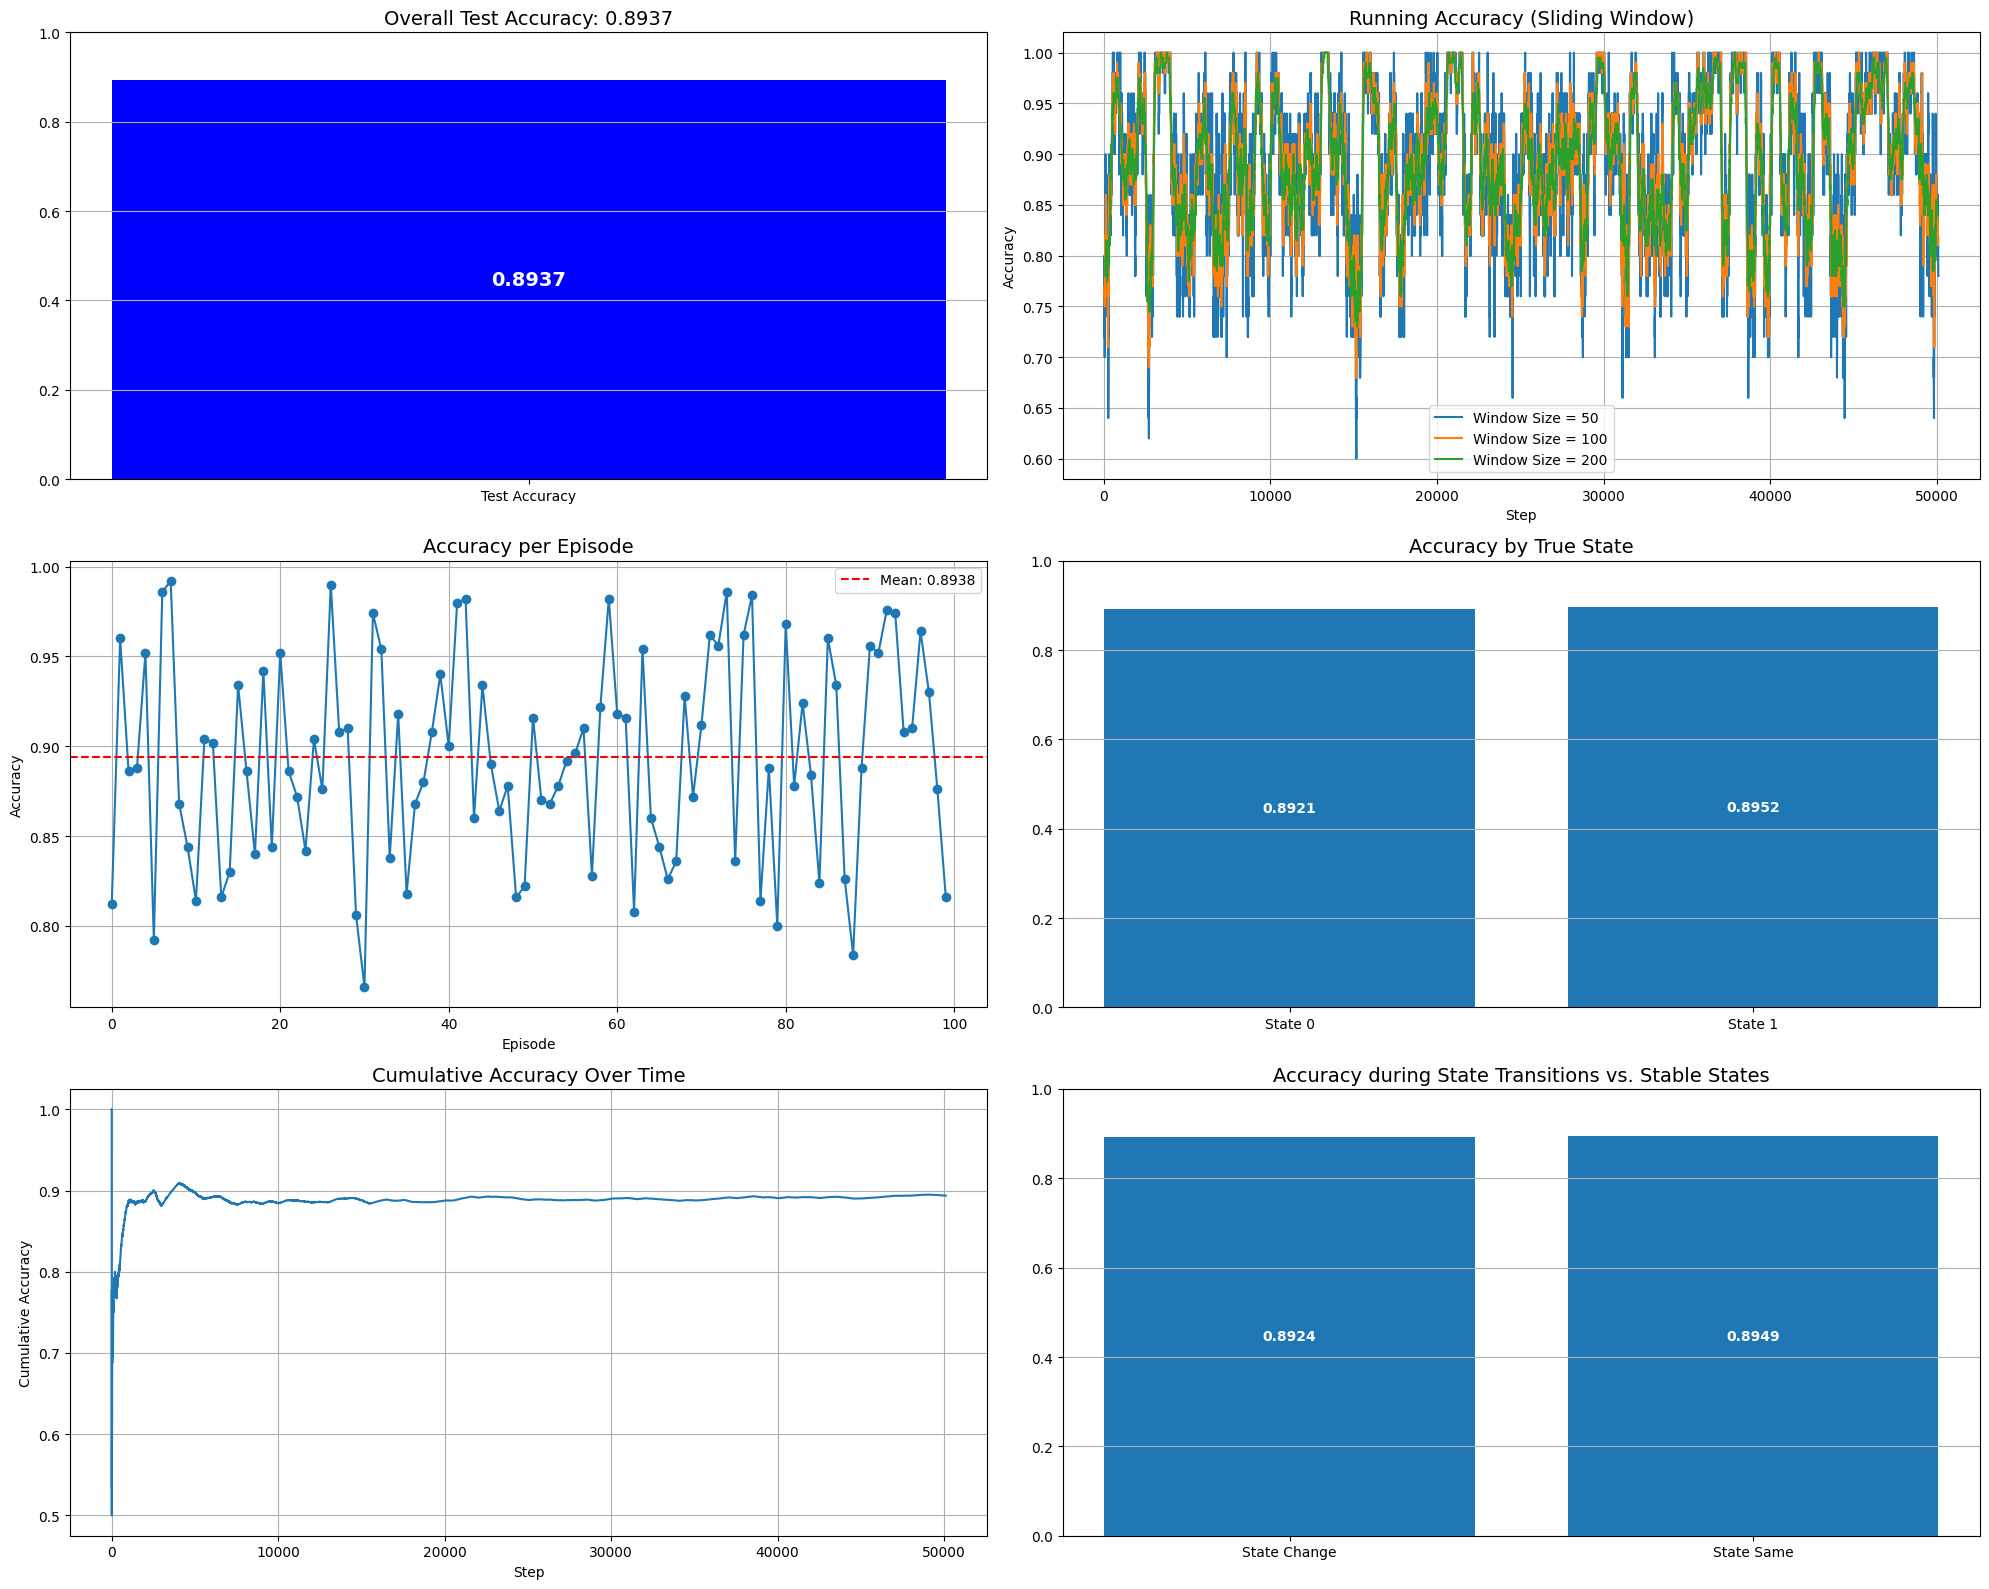


Training vs Test Performance:
Training accuracy: 0.8590
Test accuracy: 0.8937
Accuracy difference: 0.0347
Model generalizes well to the test environment.


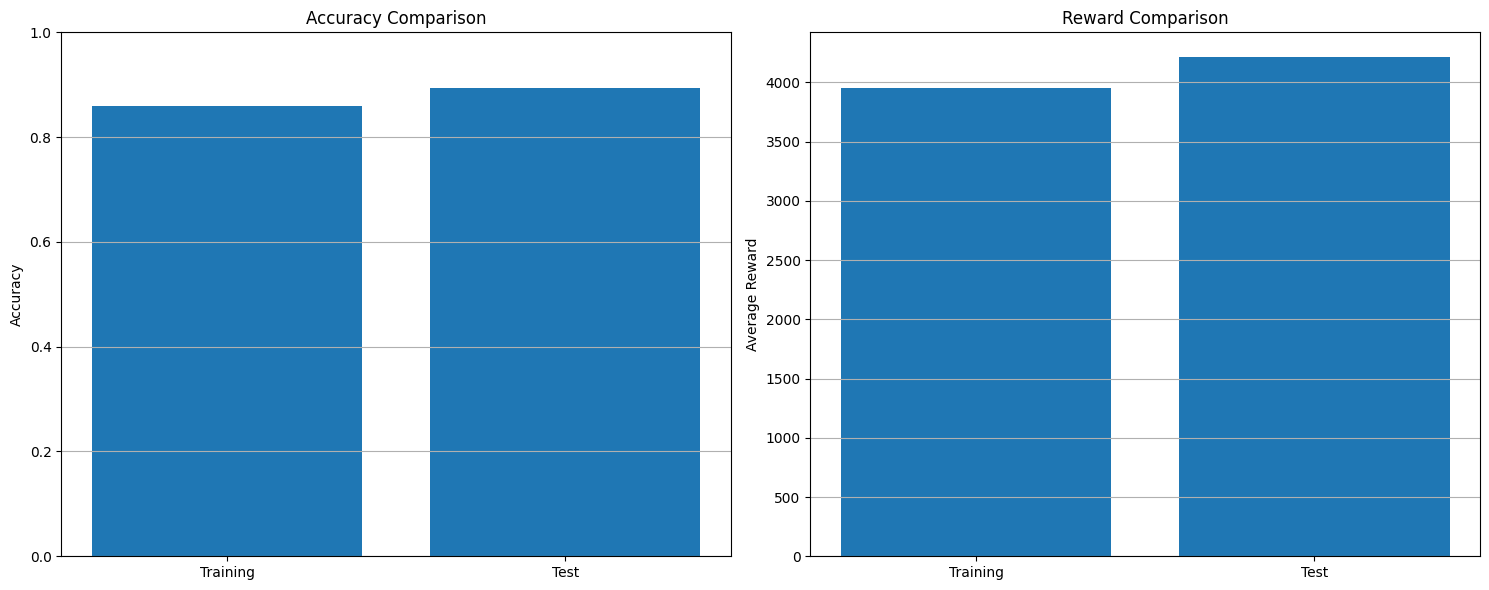

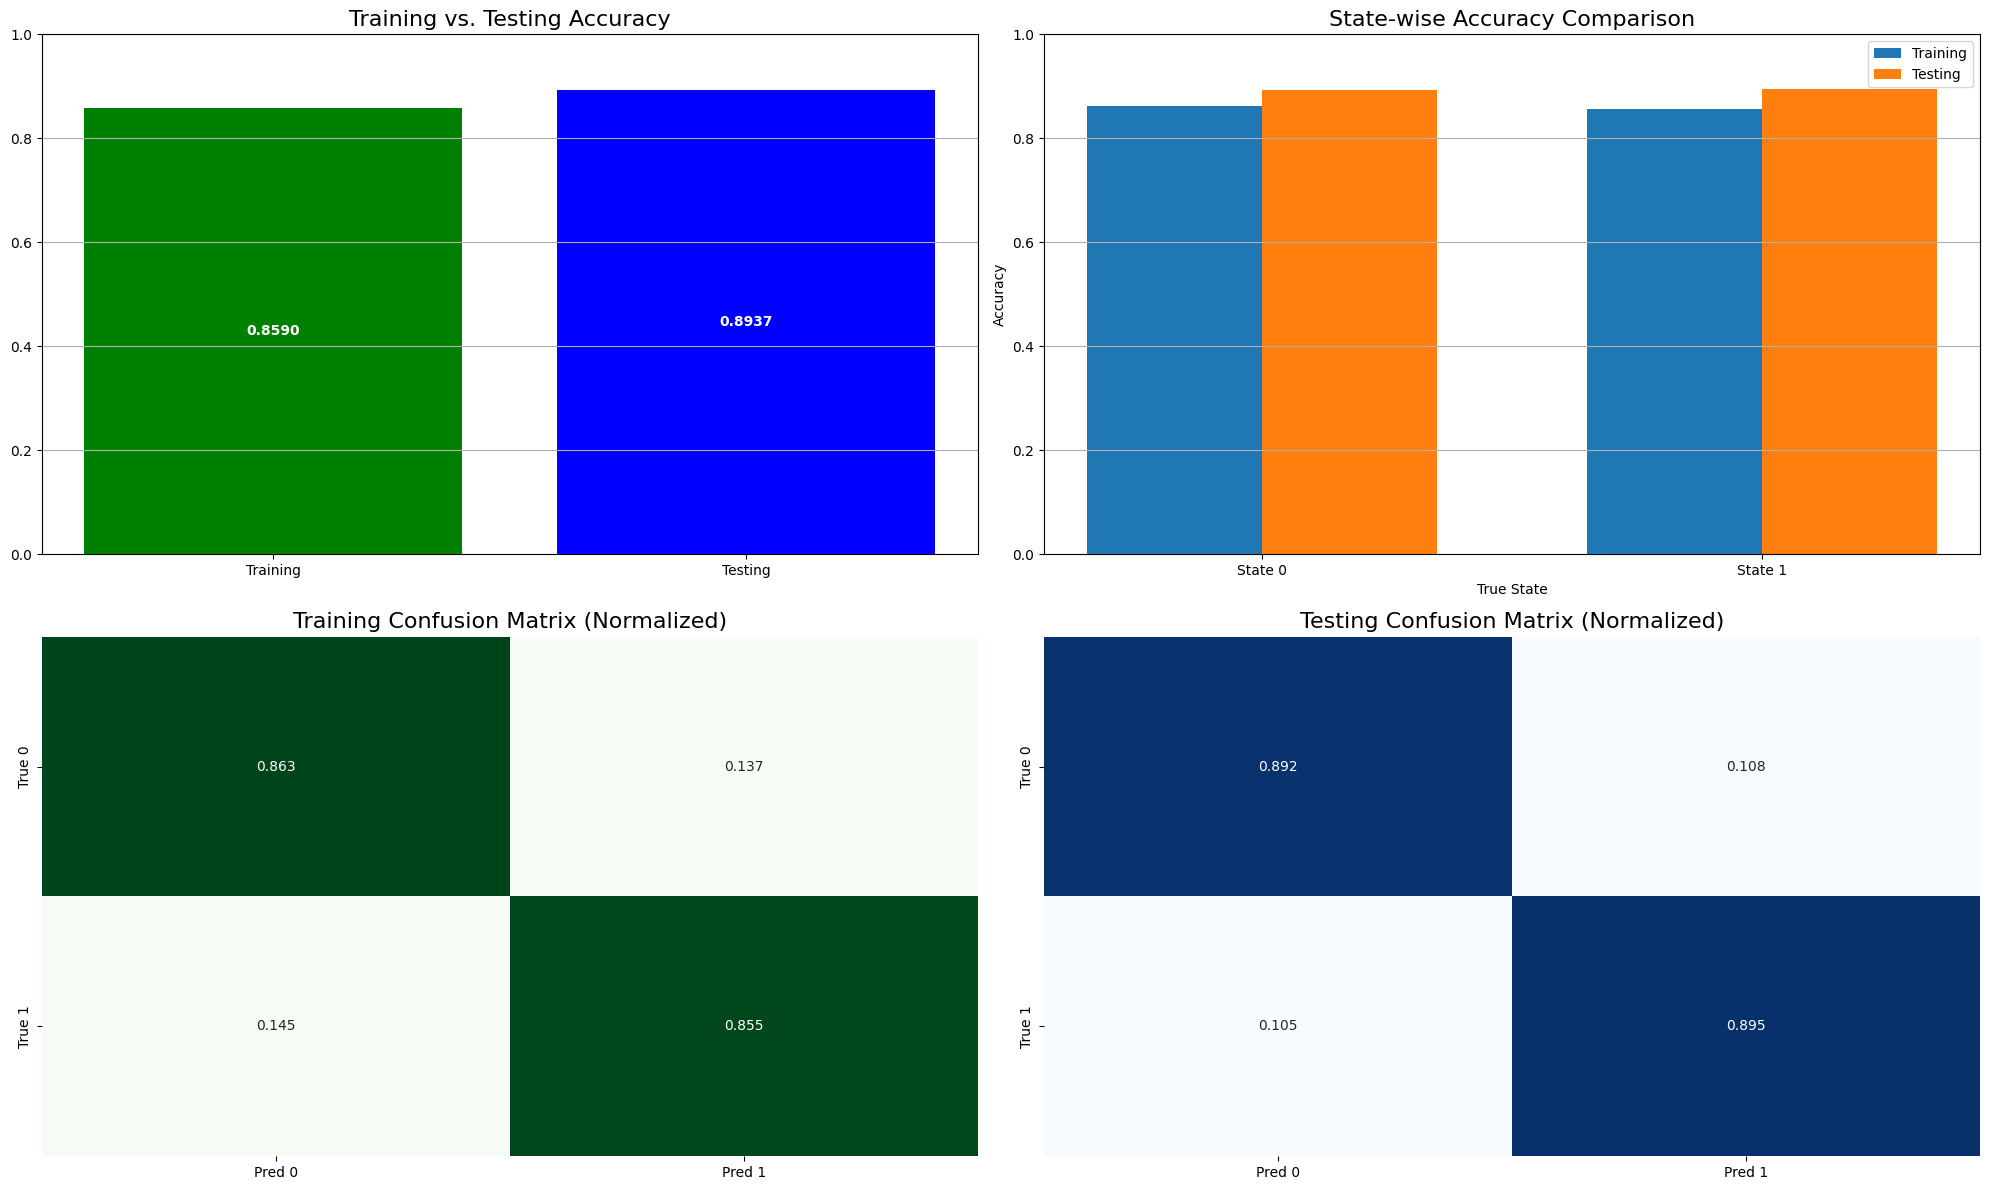

Experiment with separate testing completed!
Results for time_dependence=4 saved to results/

=== Running experiment with time_dependence = 8 ===



Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_405191/3901439464.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_405191/3901439464.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:12<10:35,  1.30s/it]

Episode: 10, Reward: 3840.00, Avg Reward (last 10): 2214.00, Accuracy: 0.8443, Loss: 2.921985, Epsilon: 0.0100
New best model saved! Avg reward: 2214.00


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:14<10:37,  1.30s/it]

New best model saved! Avg reward: 2392.50


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:15<10:39,  1.31s/it]

New best model saved! Avg reward: 2643.00


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:16<10:40,  1.32s/it]

New best model saved! Avg reward: 2884.50


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:17<10:37,  1.31s/it]

New best model saved! Avg reward: 3145.50


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:19<10:43,  1.33s/it]

New best model saved! Avg reward: 3384.00


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:20<10:38,  1.32s/it]

New best model saved! Avg reward: 3706.50


Training Enhanced LSTM-DQN:   3%|▎         | 17/500 [00:22<10:45,  1.34s/it]

New best model saved! Avg reward: 3804.00


Training Enhanced LSTM-DQN:   4%|▎         | 18/500 [00:23<10:42,  1.33s/it]

New best model saved! Avg reward: 3958.50


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:24<10:41,  1.33s/it]

New best model saved! Avg reward: 3961.50
Episode: 20, Reward: 4920.00, Avg Reward (last 10): 4069.50, Accuracy: 0.9880, Loss: 3.363462, Epsilon: 0.0100
New best model saved! Avg reward: 4069.50


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:26<11:55,  1.49s/it]

Evaluation at episode 20: Reward = 4725.00


Training Enhanced LSTM-DQN:   4%|▍         | 21/500 [00:27<11:35,  1.45s/it]

New best model saved! Avg reward: 4150.50


Training Enhanced LSTM-DQN:   4%|▍         | 22/500 [00:29<11:22,  1.43s/it]

New best model saved! Avg reward: 4269.00


Training Enhanced LSTM-DQN:   5%|▍         | 23/500 [00:30<11:15,  1.42s/it]

New best model saved! Avg reward: 4329.00


Training Enhanced LSTM-DQN:   5%|▌         | 27/500 [00:36<10:41,  1.36s/it]

New best model saved! Avg reward: 4375.50


Training Enhanced LSTM-DQN:   6%|▌         | 28/500 [00:37<10:11,  1.30s/it]

New best model saved! Avg reward: 4396.50


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [00:39<09:39,  1.23s/it]

Episode: 30, Reward: 4755.00, Avg Reward (last 10): 4324.50, Accuracy: 0.9661, Loss: 2.839020, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [00:50<09:23,  1.22s/it]

Episode: 40, Reward: 3885.00, Avg Reward (last 10): 4059.00, Accuracy: 0.8503, Loss: 2.773492, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [00:52<10:21,  1.35s/it]

Evaluation at episode 40: Reward = 4755.00


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [01:04<09:29,  1.27s/it]

Episode: 50, Reward: 3750.00, Avg Reward (last 10): 4290.00, Accuracy: 0.8323, Loss: 2.551919, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  10%|█         | 51/500 [01:05<09:23,  1.25s/it]

New best model saved! Avg reward: 4399.50


Training Enhanced LSTM-DQN:  12%|█▏        | 59/500 [01:16<09:34,  1.30s/it]

Episode: 60, Reward: 3420.00, Avg Reward (last 10): 3961.50, Accuracy: 0.7884, Loss: 2.728034, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 60/500 [01:17<10:28,  1.43s/it]

Evaluation at episode 60: Reward = 4065.00


Training Enhanced LSTM-DQN:  14%|█▍        | 70/500 [01:31<09:39,  1.35s/it]

Episode: 70, Reward: 4815.00, Avg Reward (last 10): 4242.00, Accuracy: 0.9741, Loss: 2.460395, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  16%|█▌        | 79/500 [01:43<09:33,  1.36s/it]

Episode: 80, Reward: 4185.00, Avg Reward (last 10): 4021.50, Accuracy: 0.8902, Loss: 2.539262, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  16%|█▌        | 80/500 [01:45<10:27,  1.49s/it]

Evaluation at episode 80: Reward = 3900.00


Training Enhanced LSTM-DQN:  16%|█▌        | 80/500 [01:46<09:19,  1.33s/it]

Early stopping after 81 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8522


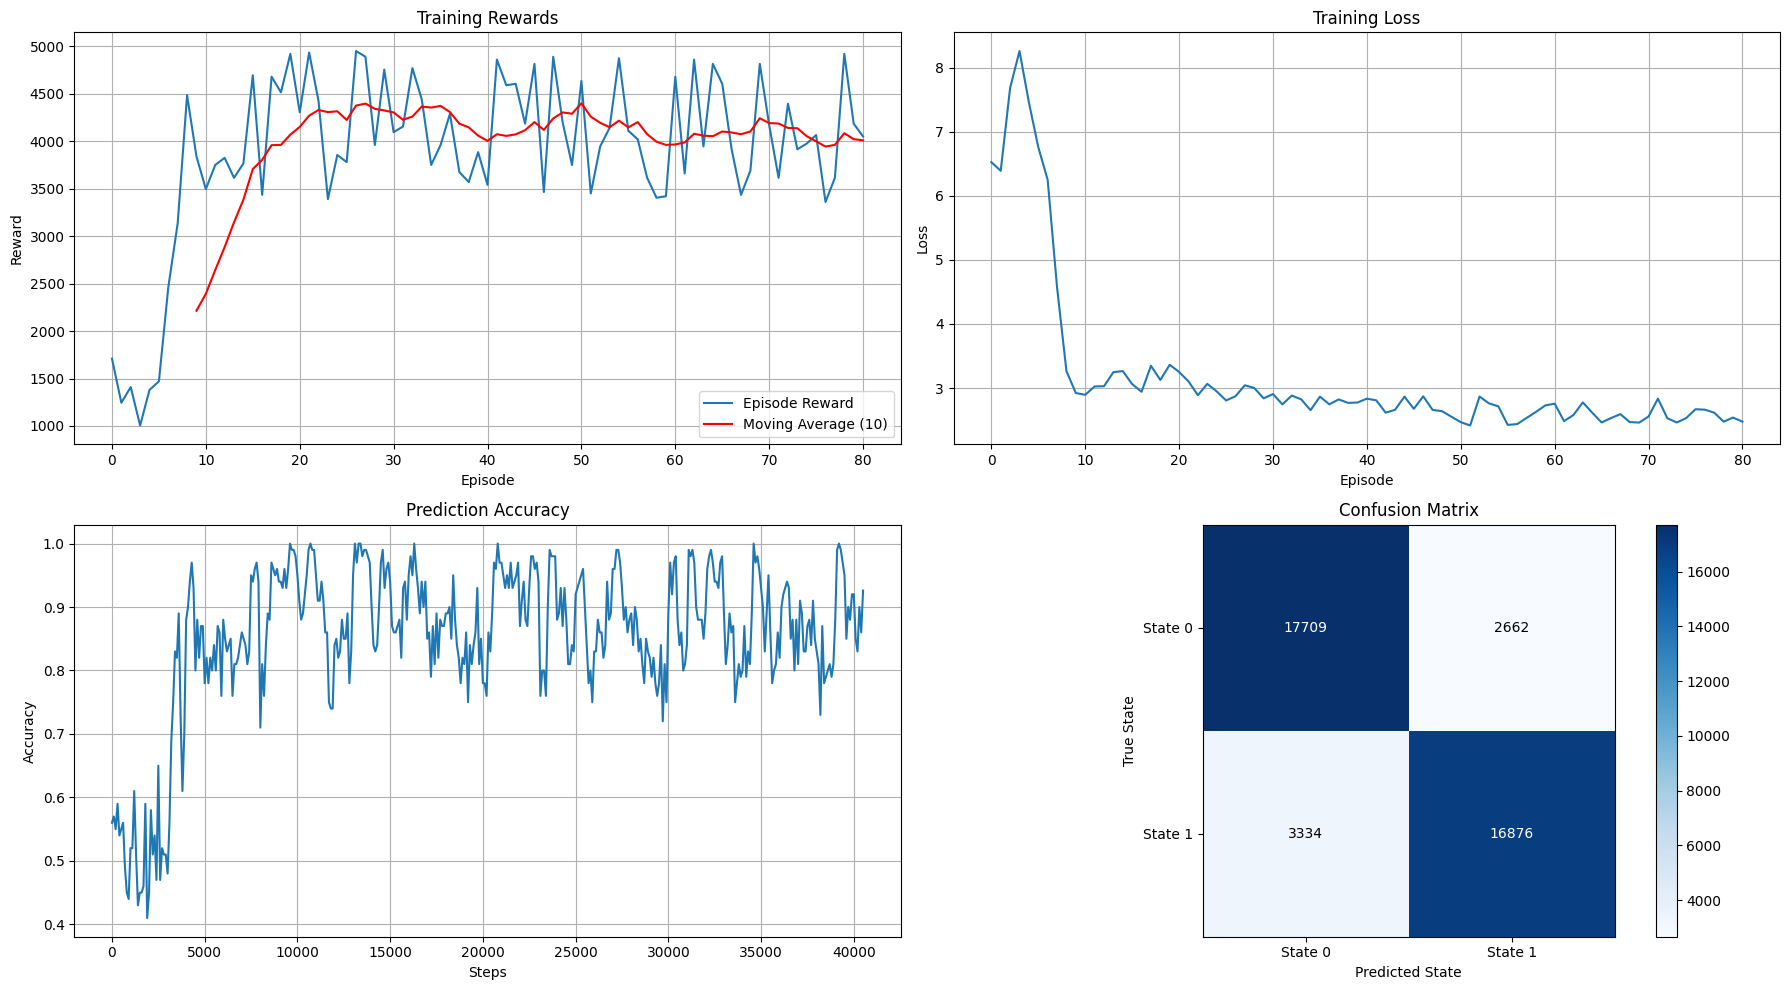


Evaluating on test environment...
Test episode 10/100 completed. Reward: 4755.00
Test episode 20/100 completed. Reward: 4065.00
Test episode 30/100 completed. Reward: 3480.00
Test episode 40/100 completed. Reward: 3765.00
Test episode 50/100 completed. Reward: 4185.00
Test episode 60/100 completed. Reward: 4950.00
Test episode 70/100 completed. Reward: 3990.00
Test episode 80/100 completed. Reward: 3780.00
Test episode 90/100 completed. Reward: 4890.00
Test episode 100/100 completed. Reward: 4860.00

Test Results Summary:
Average reward: 4188.60
Prediction accuracy: 0.8907


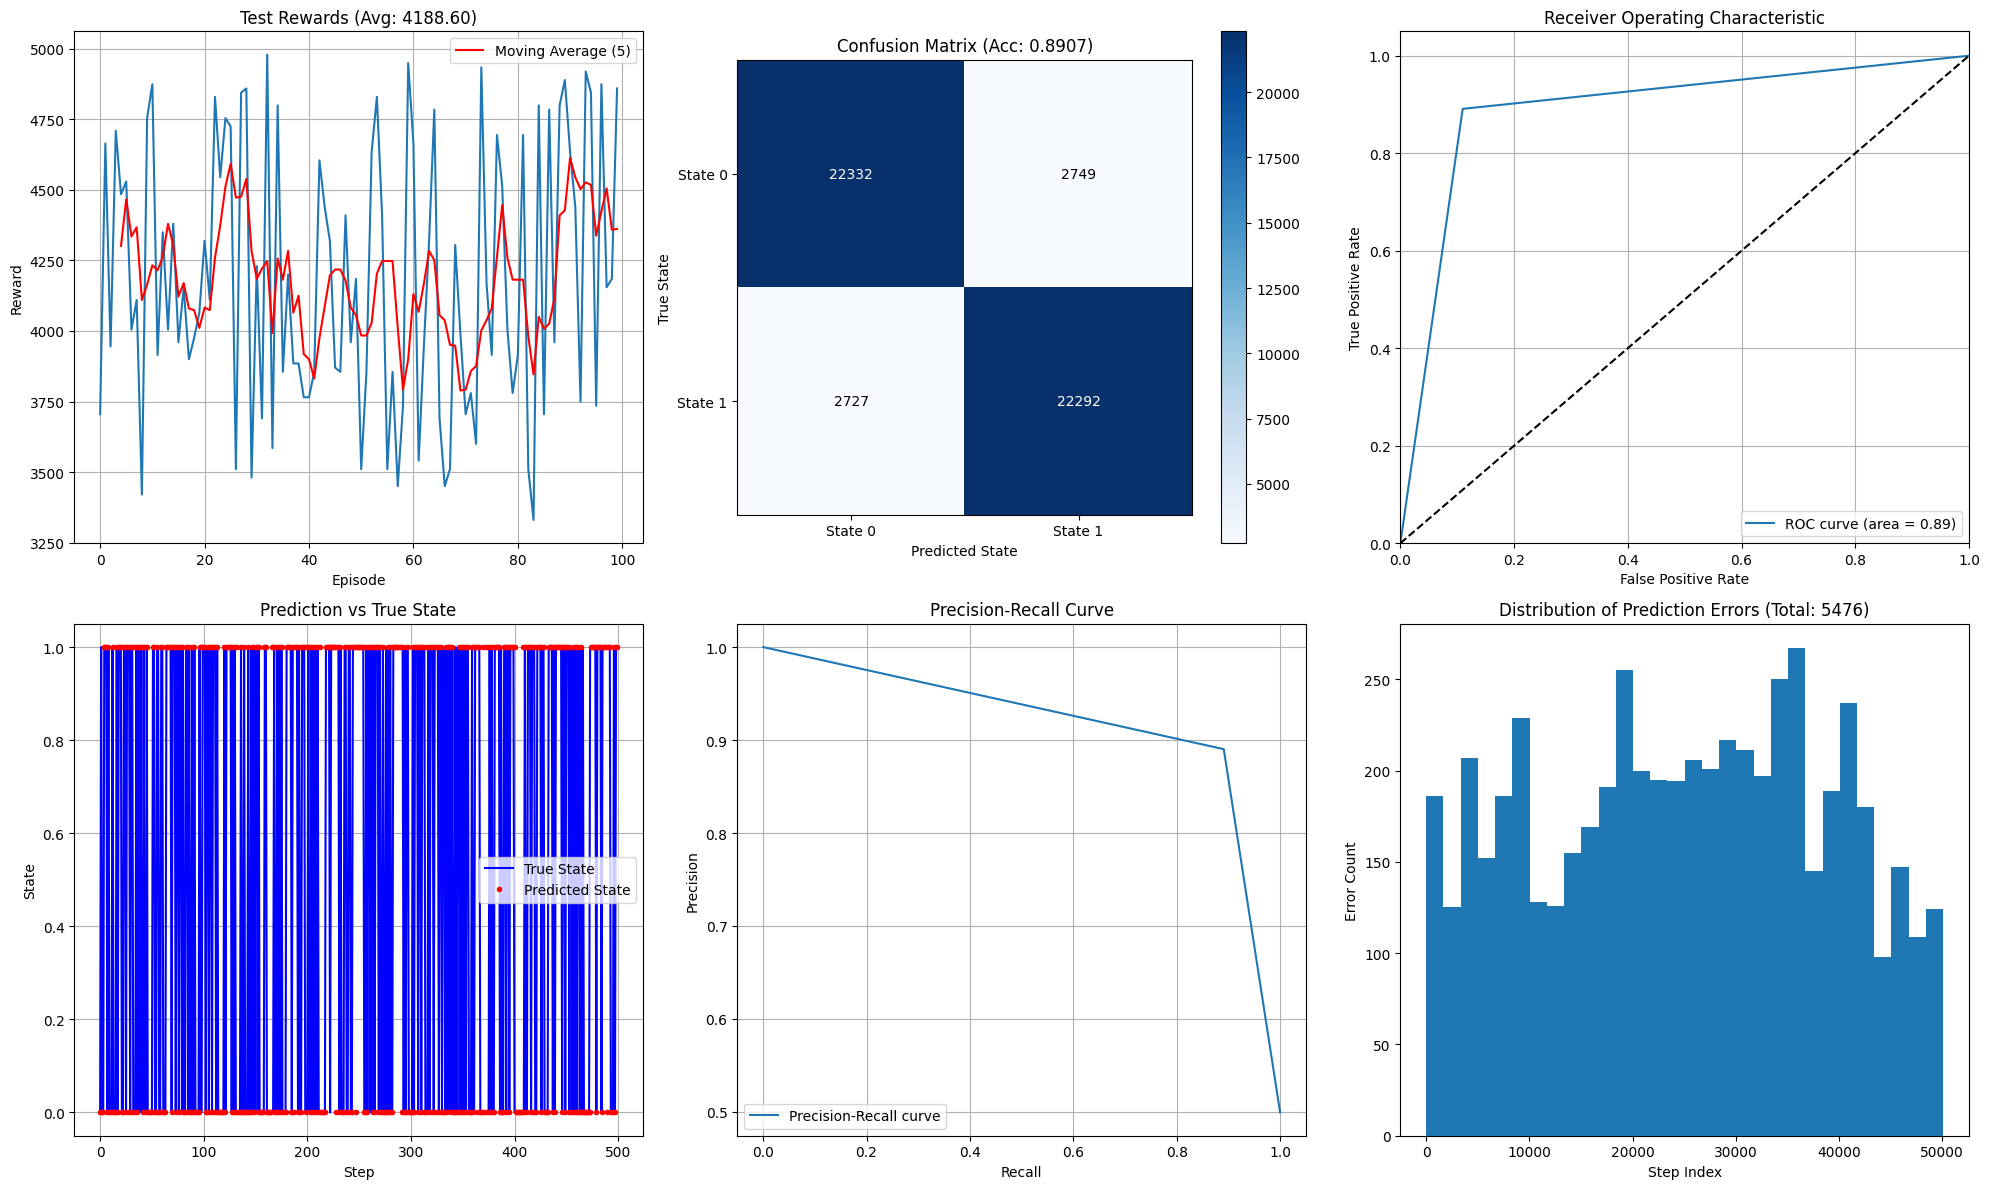

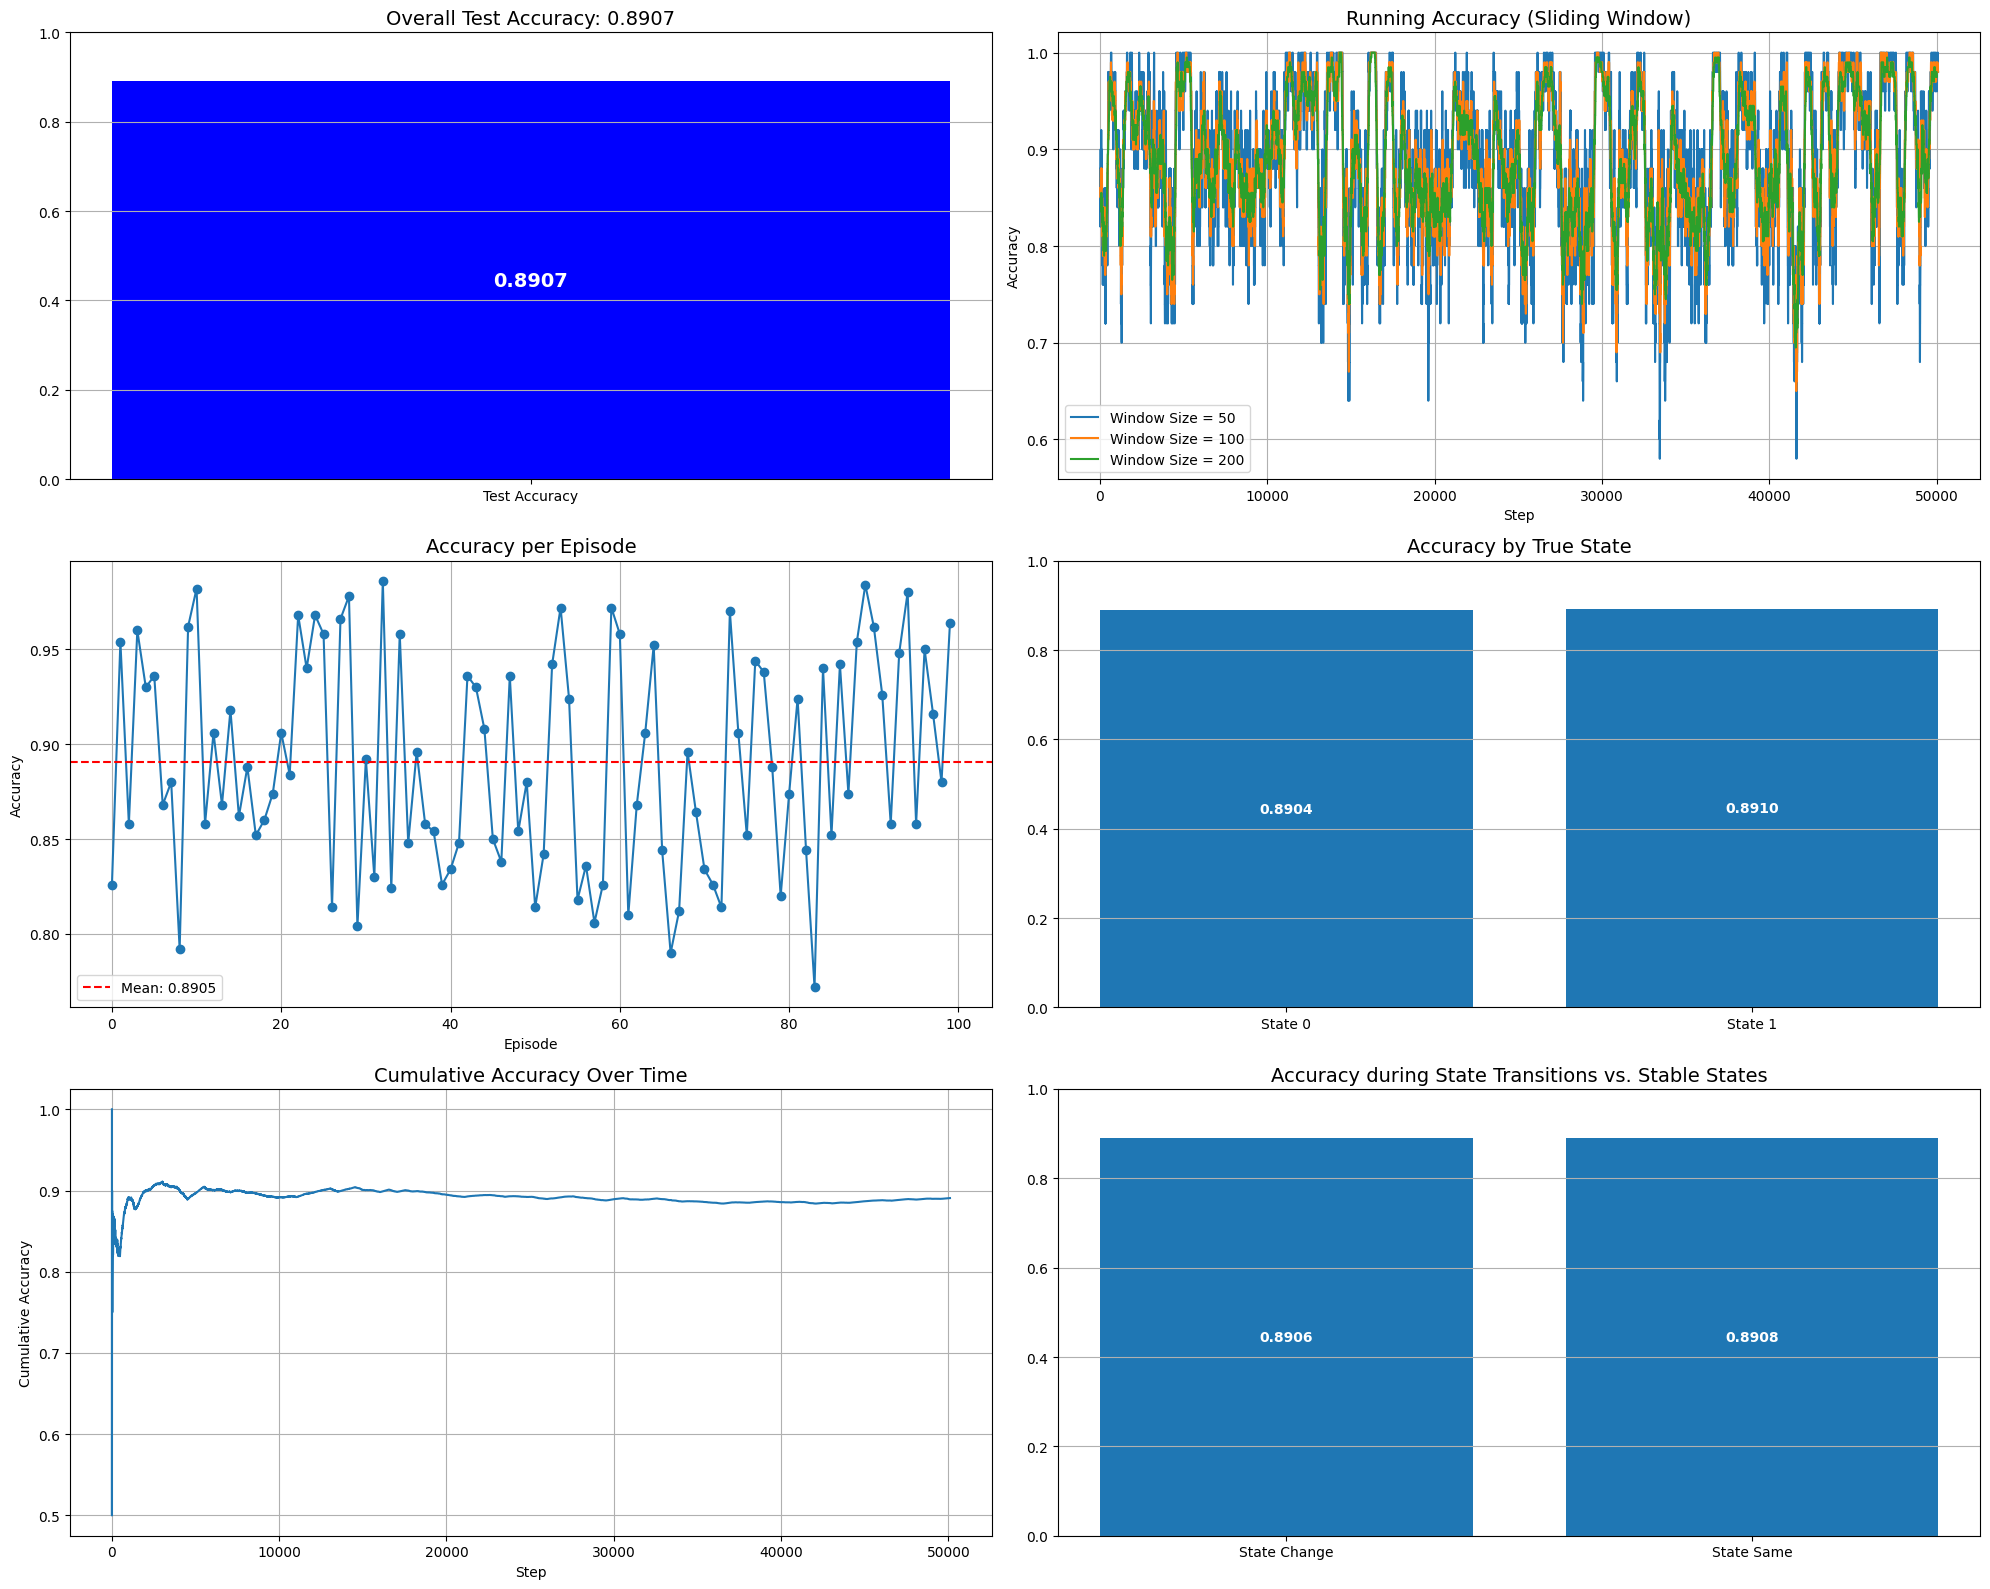


Training vs Test Performance:
Training accuracy: 0.8522
Test accuracy: 0.8907
Accuracy difference: 0.0385
Model generalizes well to the test environment.


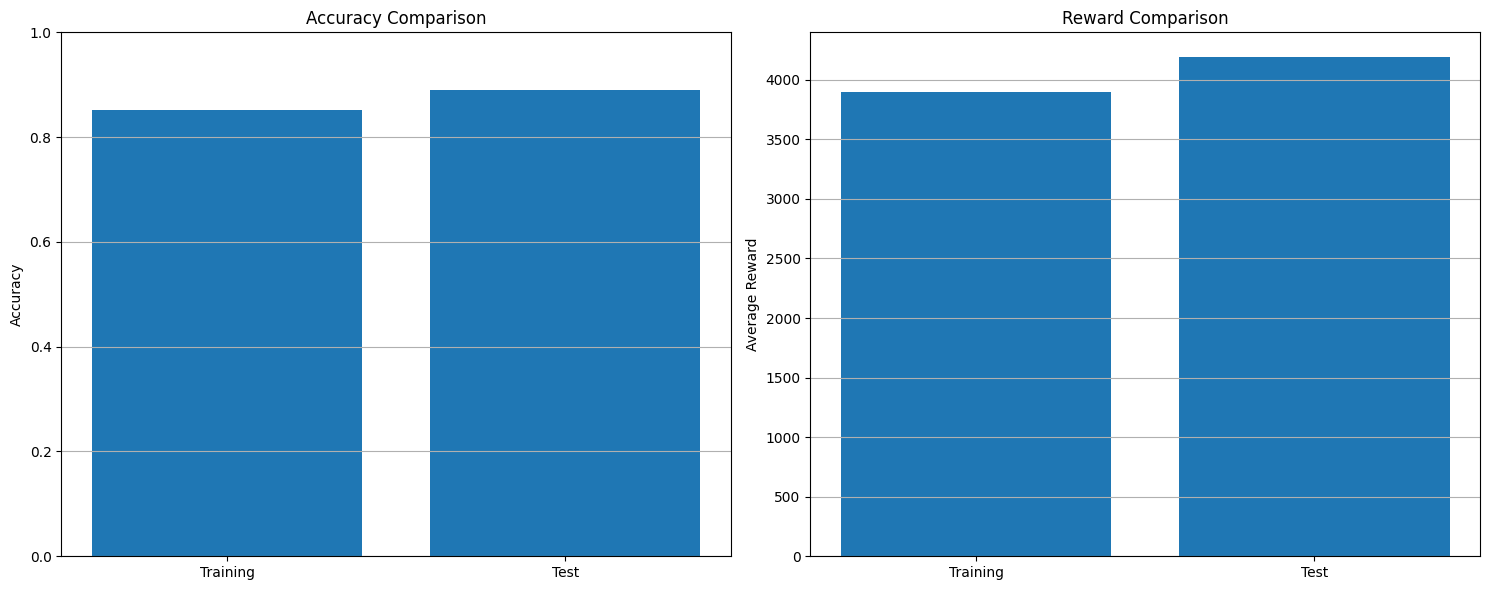

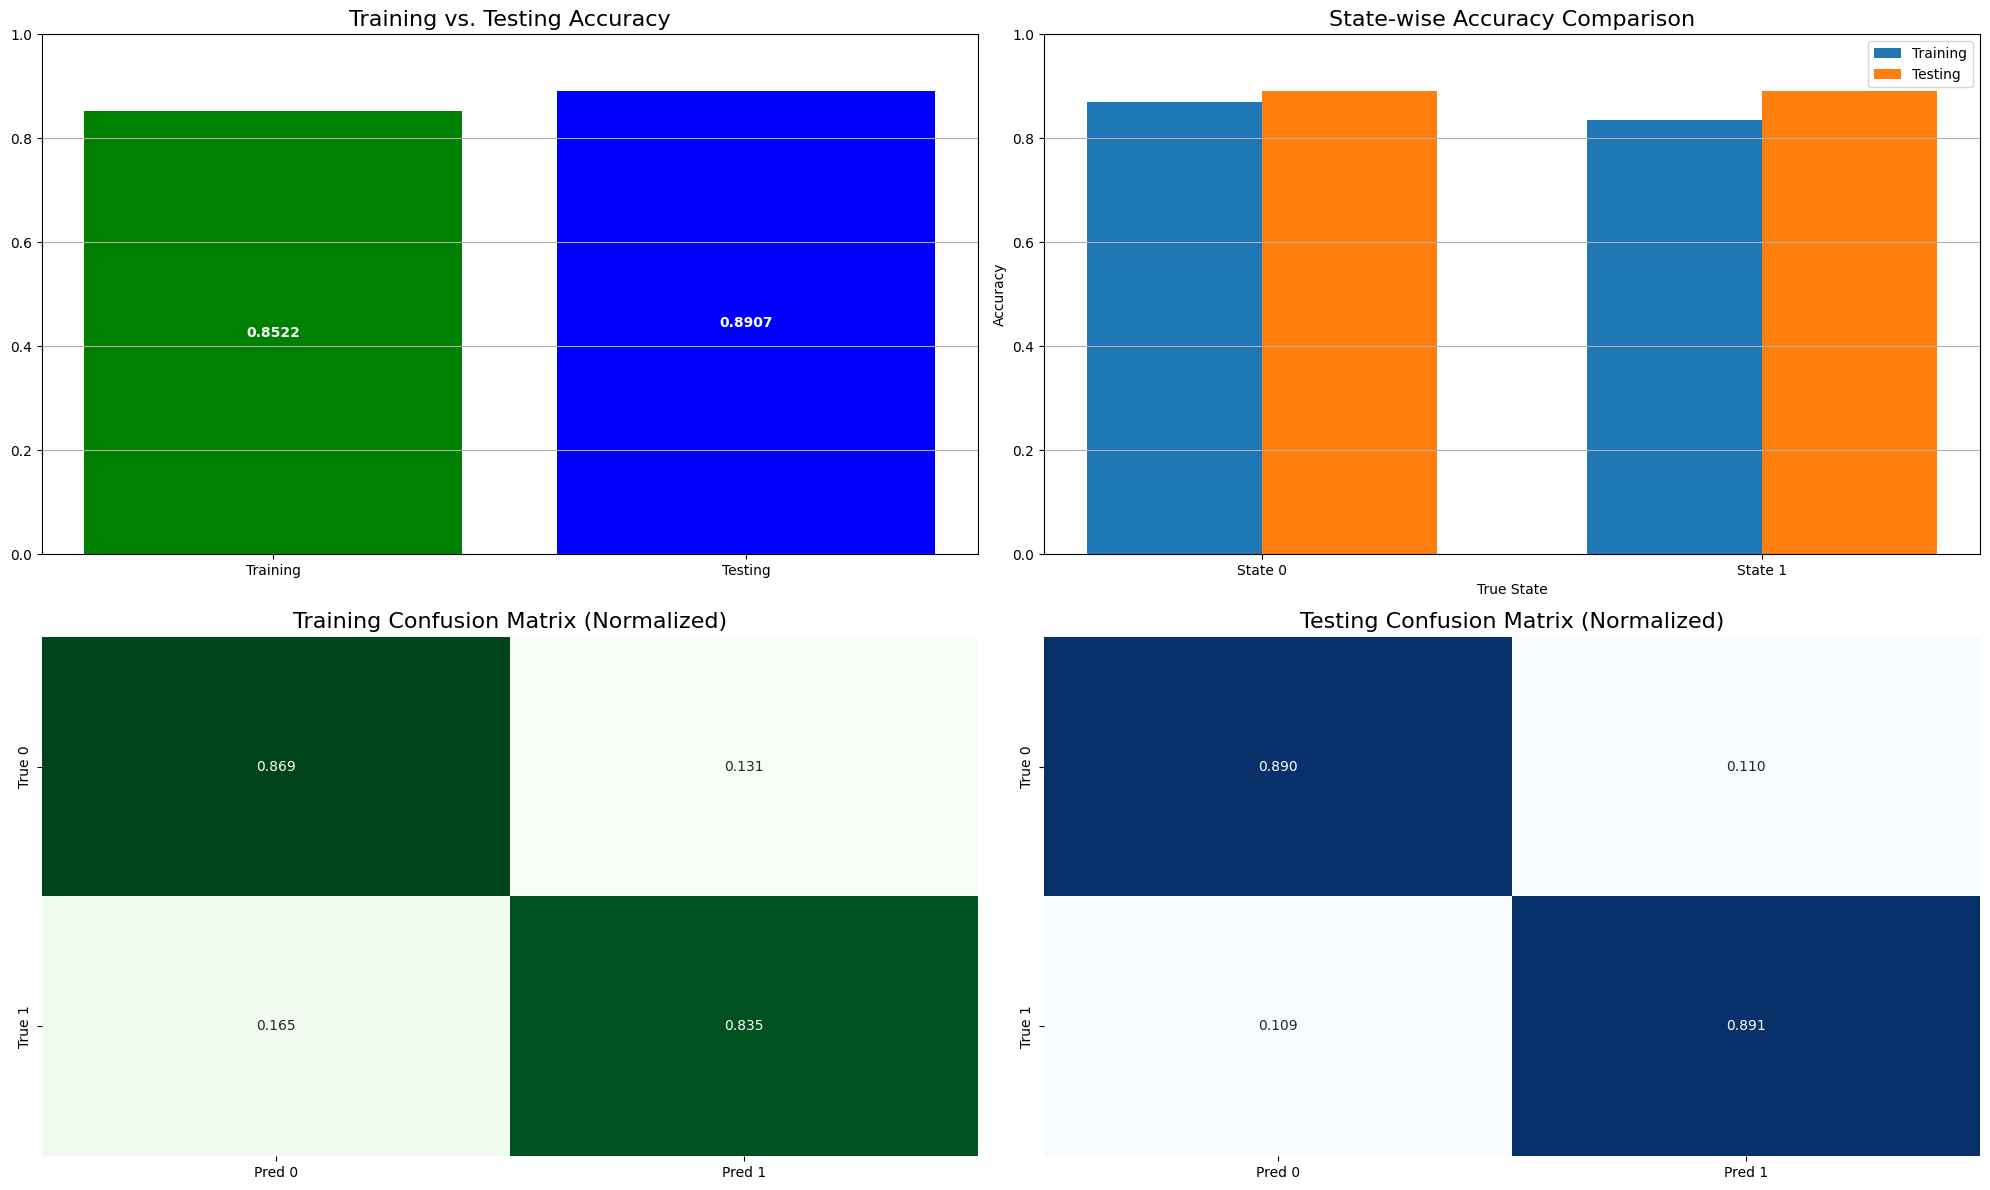

Experiment with separate testing completed!
Results for time_dependence=8 saved to results/

=== Running experiment with time_dependence = 16 ===



Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_405191/3901439464.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_405191/3901439464.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:24<19:00,  2.33s/it]

Episode: 10, Reward: 4545.00, Avg Reward (last 10): 2652.00, Accuracy: 0.9381, Loss: 2.964005, Epsilon: 0.0100
New best model saved! Avg reward: 2652.00


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:26<19:03,  2.34s/it]

New best model saved! Avg reward: 2971.50


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:29<20:17,  2.50s/it]

New best model saved! Avg reward: 3217.50


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:31<19:58,  2.46s/it]

New best model saved! Avg reward: 3444.00


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:34<20:12,  2.50s/it]

New best model saved! Avg reward: 3697.50


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:36<19:32,  2.42s/it]

New best model saved! Avg reward: 3982.50


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:38<18:54,  2.34s/it]

New best model saved! Avg reward: 4092.00


Training Enhanced LSTM-DQN:   4%|▎         | 18/500 [00:44<21:51,  2.72s/it]

New best model saved! Avg reward: 4101.00


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:47<20:40,  2.58s/it]

Episode: 20, Reward: 3675.00, Avg Reward (last 10): 4012.50, Accuracy: 0.8224, Loss: 3.097463, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:51<25:13,  3.15s/it]

Evaluation at episode 20: Reward = 4560.00


Training Enhanced LSTM-DQN:   5%|▍         | 24/500 [01:01<20:54,  2.64s/it]

New best model saved! Avg reward: 4147.50


Training Enhanced LSTM-DQN:   5%|▌         | 27/500 [01:09<21:09,  2.68s/it]

New best model saved! Avg reward: 4153.50


Training Enhanced LSTM-DQN:   6%|▌         | 29/500 [01:15<20:26,  2.60s/it]

New best model saved! Avg reward: 4215.00


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [01:17<19:47,  2.53s/it]

Episode: 30, Reward: 4170.00, Avg Reward (last 10): 4264.50, Accuracy: 0.8882, Loss: 2.881888, Epsilon: 0.0100
New best model saved! Avg reward: 4264.50


Training Enhanced LSTM-DQN:   7%|▋         | 36/500 [01:35<23:26,  3.03s/it]

New best model saved! Avg reward: 4282.50


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [01:44<21:22,  2.78s/it]

Episode: 40, Reward: 4185.00, Avg Reward (last 10): 4158.00, Accuracy: 0.8902, Loss: 2.668217, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [01:48<24:51,  3.24s/it]

Evaluation at episode 40: Reward = 3795.00


Training Enhanced LSTM-DQN:   9%|▉         | 46/500 [02:00<16:27,  2.17s/it]

New best model saved! Avg reward: 4294.50


Training Enhanced LSTM-DQN:   9%|▉         | 47/500 [02:02<15:49,  2.10s/it]

New best model saved! Avg reward: 4303.50


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [02:08<14:40,  1.96s/it]

Episode: 50, Reward: 4785.00, Avg Reward (last 10): 4272.00, Accuracy: 0.9701, Loss: 2.444743, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 59/500 [02:27<15:46,  2.15s/it]

Episode: 60, Reward: 4815.00, Avg Reward (last 10): 4201.50, Accuracy: 0.9741, Loss: 2.586960, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 60/500 [02:30<19:07,  2.61s/it]

Evaluation at episode 60: Reward = 4020.00


Training Enhanced LSTM-DQN:  13%|█▎        | 63/500 [02:38<19:18,  2.65s/it]

New best model saved! Avg reward: 4345.50


Training Enhanced LSTM-DQN:  14%|█▍        | 70/500 [02:57<18:29,  2.58s/it]

Episode: 70, Reward: 3405.00, Avg Reward (last 10): 4008.00, Accuracy: 0.7864, Loss: 2.412779, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  16%|█▌        | 79/500 [03:23<19:28,  2.78s/it]

Episode: 80, Reward: 3765.00, Avg Reward (last 10): 4311.00, Accuracy: 0.8343, Loss: 2.437745, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  16%|█▌        | 80/500 [03:28<25:34,  3.65s/it]

Evaluation at episode 80: Reward = 3615.00


Training Enhanced LSTM-DQN:  18%|█▊        | 90/500 [03:59<20:47,  3.04s/it]

Episode: 90, Reward: 3645.00, Avg Reward (last 10): 4024.50, Accuracy: 0.8184, Loss: 2.223908, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  18%|█▊        | 92/500 [04:08<18:23,  2.70s/it]

Early stopping after 93 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8676


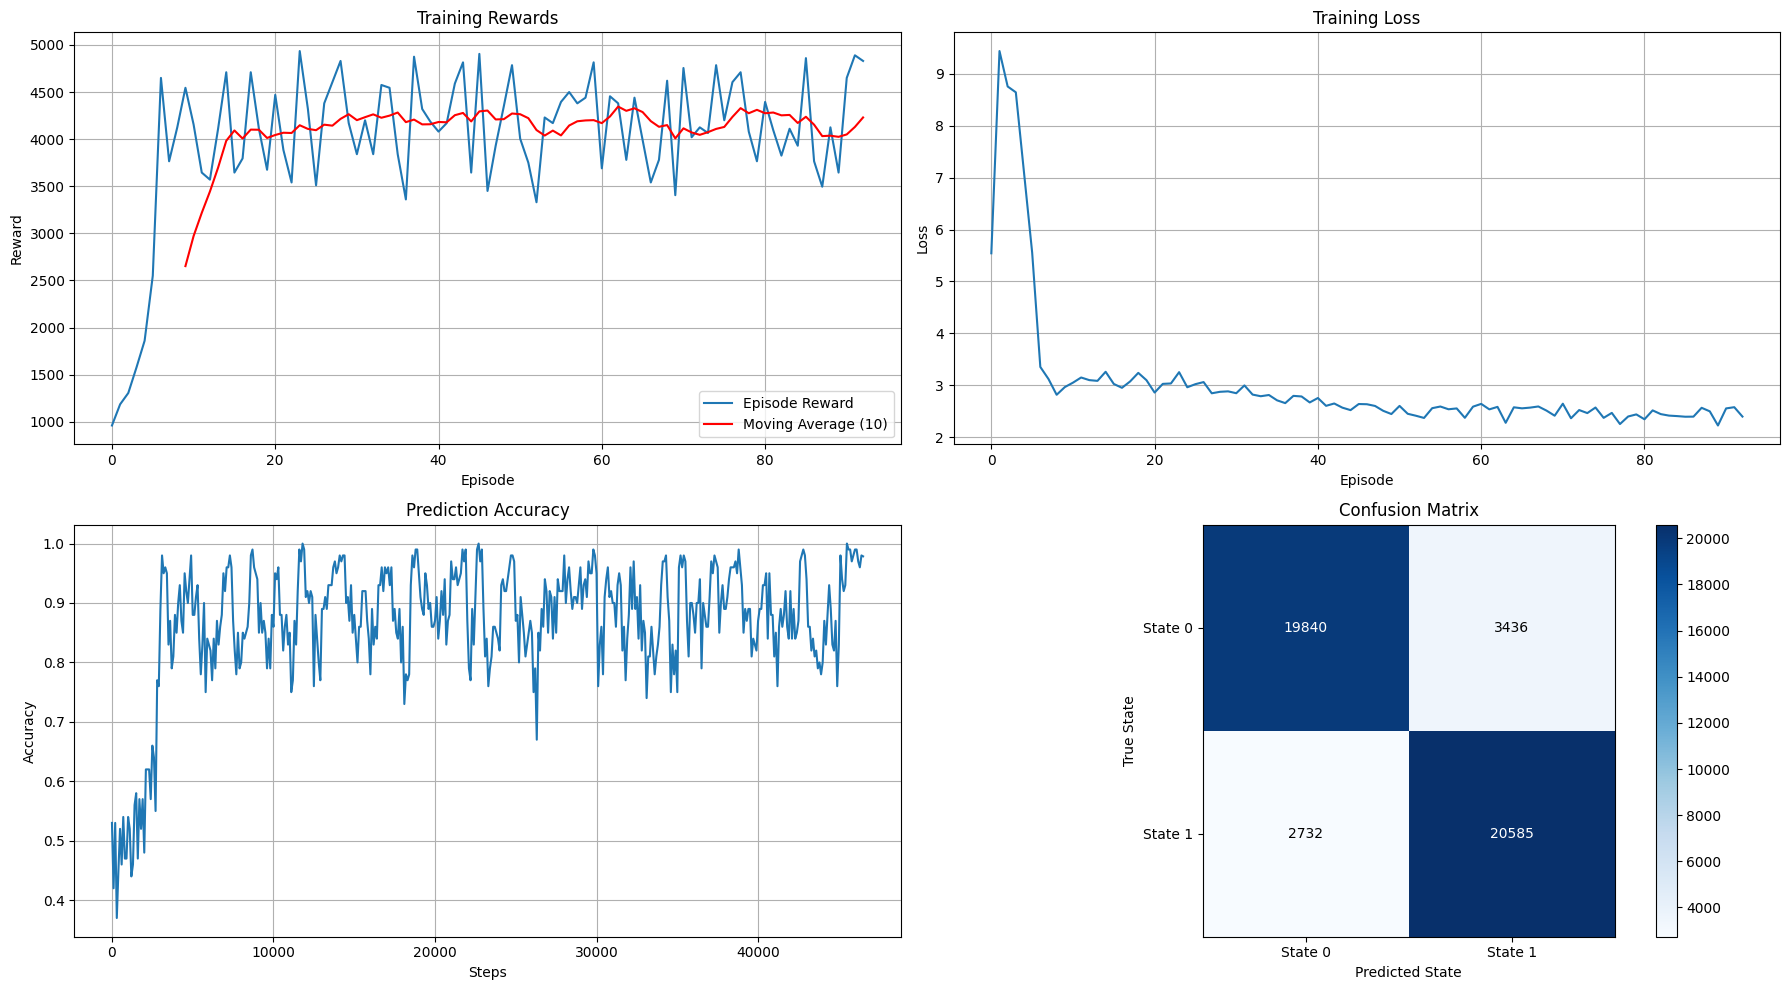


Evaluating on test environment...
Test episode 10/100 completed. Reward: 3900.00
Test episode 20/100 completed. Reward: 4440.00
Test episode 30/100 completed. Reward: 4440.00
Test episode 40/100 completed. Reward: 4920.00
Test episode 50/100 completed. Reward: 3930.00
Test episode 60/100 completed. Reward: 3480.00
Test episode 70/100 completed. Reward: 3855.00
Test episode 80/100 completed. Reward: 4635.00
Test episode 90/100 completed. Reward: 4110.00
Test episode 100/100 completed. Reward: 4770.00

Test Results Summary:
Average reward: 4204.35
Prediction accuracy: 0.8928


In [4]:
run_all_experiments()

Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_312686/3901439464.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_312686/3901439464.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:11<09:23,  1.15s/it]

Episode: 10, Reward: 4305.00, Avg Reward (last 10): 2323.50, Accuracy: 0.9062, Loss: 2.303750, Epsilon: 0.0100
New best model saved! Avg reward: 2323.50


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:12<09:21,  1.15s/it]

New best model saved! Avg reward: 2524.50


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:13<09:19,  1.15s/it]

New best model saved! Avg reward: 2908.50


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:14<09:18,  1.15s/it]

New best model saved! Avg reward: 3124.50


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:16<09:21,  1.16s/it]

New best model saved! Avg reward: 3402.00


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:17<09:25,  1.17s/it]

New best model saved! Avg reward: 3718.50


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:18<09:30,  1.18s/it]

New best model saved! Avg reward: 3969.00


Training Enhanced LSTM-DQN:   3%|▎         | 17/500 [00:19<09:38,  1.20s/it]

New best model saved! Avg reward: 4026.00


Training Enhanced LSTM-DQN:   4%|▎         | 18/500 [00:20<09:35,  1.19s/it]

New best model saved! Avg reward: 4131.00


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:22<09:30,  1.19s/it]

New best model saved! Avg reward: 4225.50
Episode: 20, Reward: 4035.00, Avg Reward (last 10): 4198.50, Accuracy: 0.8703, Loss: 2.648282, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:23<10:32,  1.32s/it]

Evaluation at episode 20: Reward = 3930.00


Training Enhanced LSTM-DQN:   4%|▍         | 21/500 [00:24<10:11,  1.28s/it]

New best model saved! Avg reward: 4245.00


Training Enhanced LSTM-DQN:   4%|▍         | 22/500 [00:26<09:58,  1.25s/it]

New best model saved! Avg reward: 4267.50


Training Enhanced LSTM-DQN:   5%|▌         | 25/500 [00:29<09:40,  1.22s/it]

New best model saved! Avg reward: 4338.00


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [00:35<09:41,  1.24s/it]

Episode: 30, Reward: 4560.00, Avg Reward (last 10): 4084.50, Accuracy: 0.9401, Loss: 2.654528, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [00:47<09:54,  1.29s/it]

Episode: 40, Reward: 4605.00, Avg Reward (last 10): 4294.50, Accuracy: 0.9461, Loss: 2.565315, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [00:49<10:58,  1.43s/it]

Evaluation at episode 40: Reward = 3810.00


Training Enhanced LSTM-DQN:   8%|▊         | 41/500 [00:50<10:38,  1.39s/it]

New best model saved! Avg reward: 4366.50


Training Enhanced LSTM-DQN:   8%|▊         | 42/500 [00:51<10:26,  1.37s/it]

New best model saved! Avg reward: 4432.50


Training Enhanced LSTM-DQN:   9%|▊         | 43/500 [00:53<10:18,  1.35s/it]

New best model saved! Avg reward: 4444.50


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [01:02<10:01,  1.34s/it]

Episode: 50, Reward: 4035.00, Avg Reward (last 10): 4302.00, Accuracy: 0.8703, Loss: 2.324819, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 59/500 [01:14<09:58,  1.36s/it]

Episode: 60, Reward: 4170.00, Avg Reward (last 10): 4143.00, Accuracy: 0.8882, Loss: 2.376175, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 60/500 [01:16<10:58,  1.50s/it]

Evaluation at episode 60: Reward = 3645.00


Training Enhanced LSTM-DQN:  14%|█▍        | 70/500 [01:30<10:07,  1.41s/it]

Episode: 70, Reward: 4845.00, Avg Reward (last 10): 4200.00, Accuracy: 0.9780, Loss: 2.302192, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  14%|█▍        | 72/500 [01:34<09:22,  1.32s/it]

Early stopping after 73 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8593


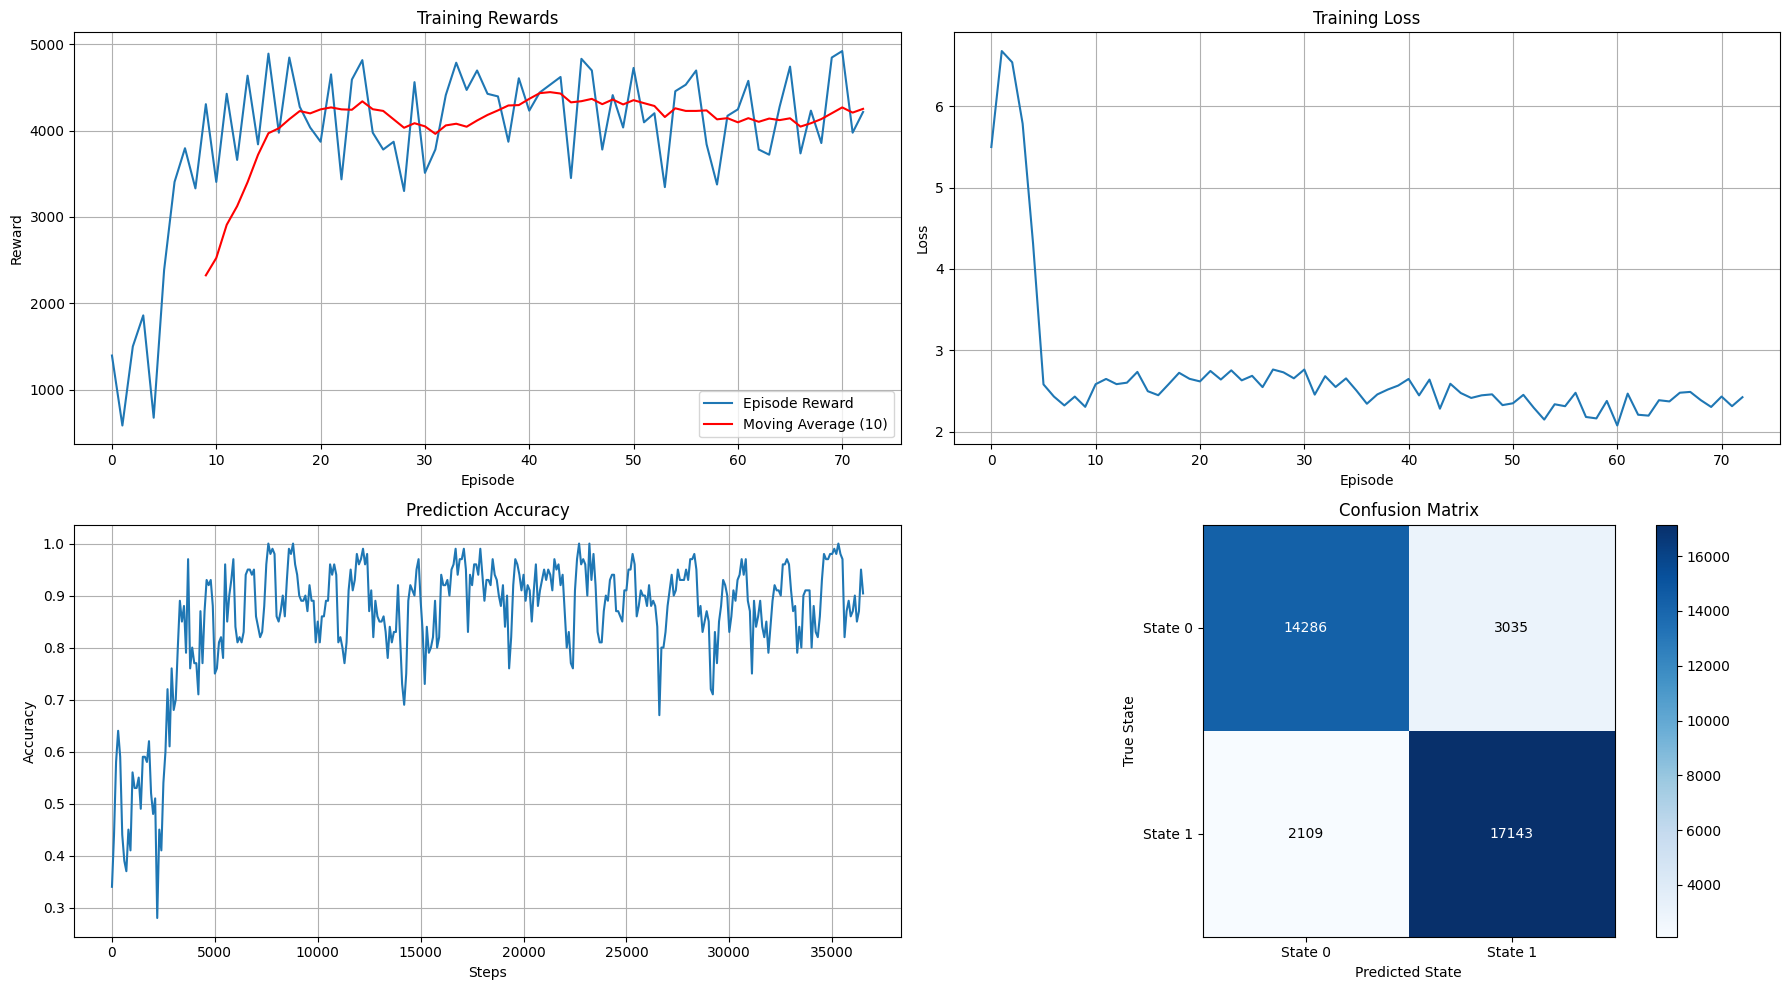


Evaluating on test environment...
Test episode 10/100 completed. Reward: 4695.00
Test episode 20/100 completed. Reward: 4755.00
Test episode 30/100 completed. Reward: 4005.00
Test episode 40/100 completed. Reward: 3720.00
Test episode 50/100 completed. Reward: 4410.00
Test episode 60/100 completed. Reward: 3915.00
Test episode 70/100 completed. Reward: 4260.00
Test episode 80/100 completed. Reward: 3630.00
Test episode 90/100 completed. Reward: 4005.00
Test episode 100/100 completed. Reward: 4725.00

Test Results Summary:
Average reward: 4185.90
Prediction accuracy: 0.8903


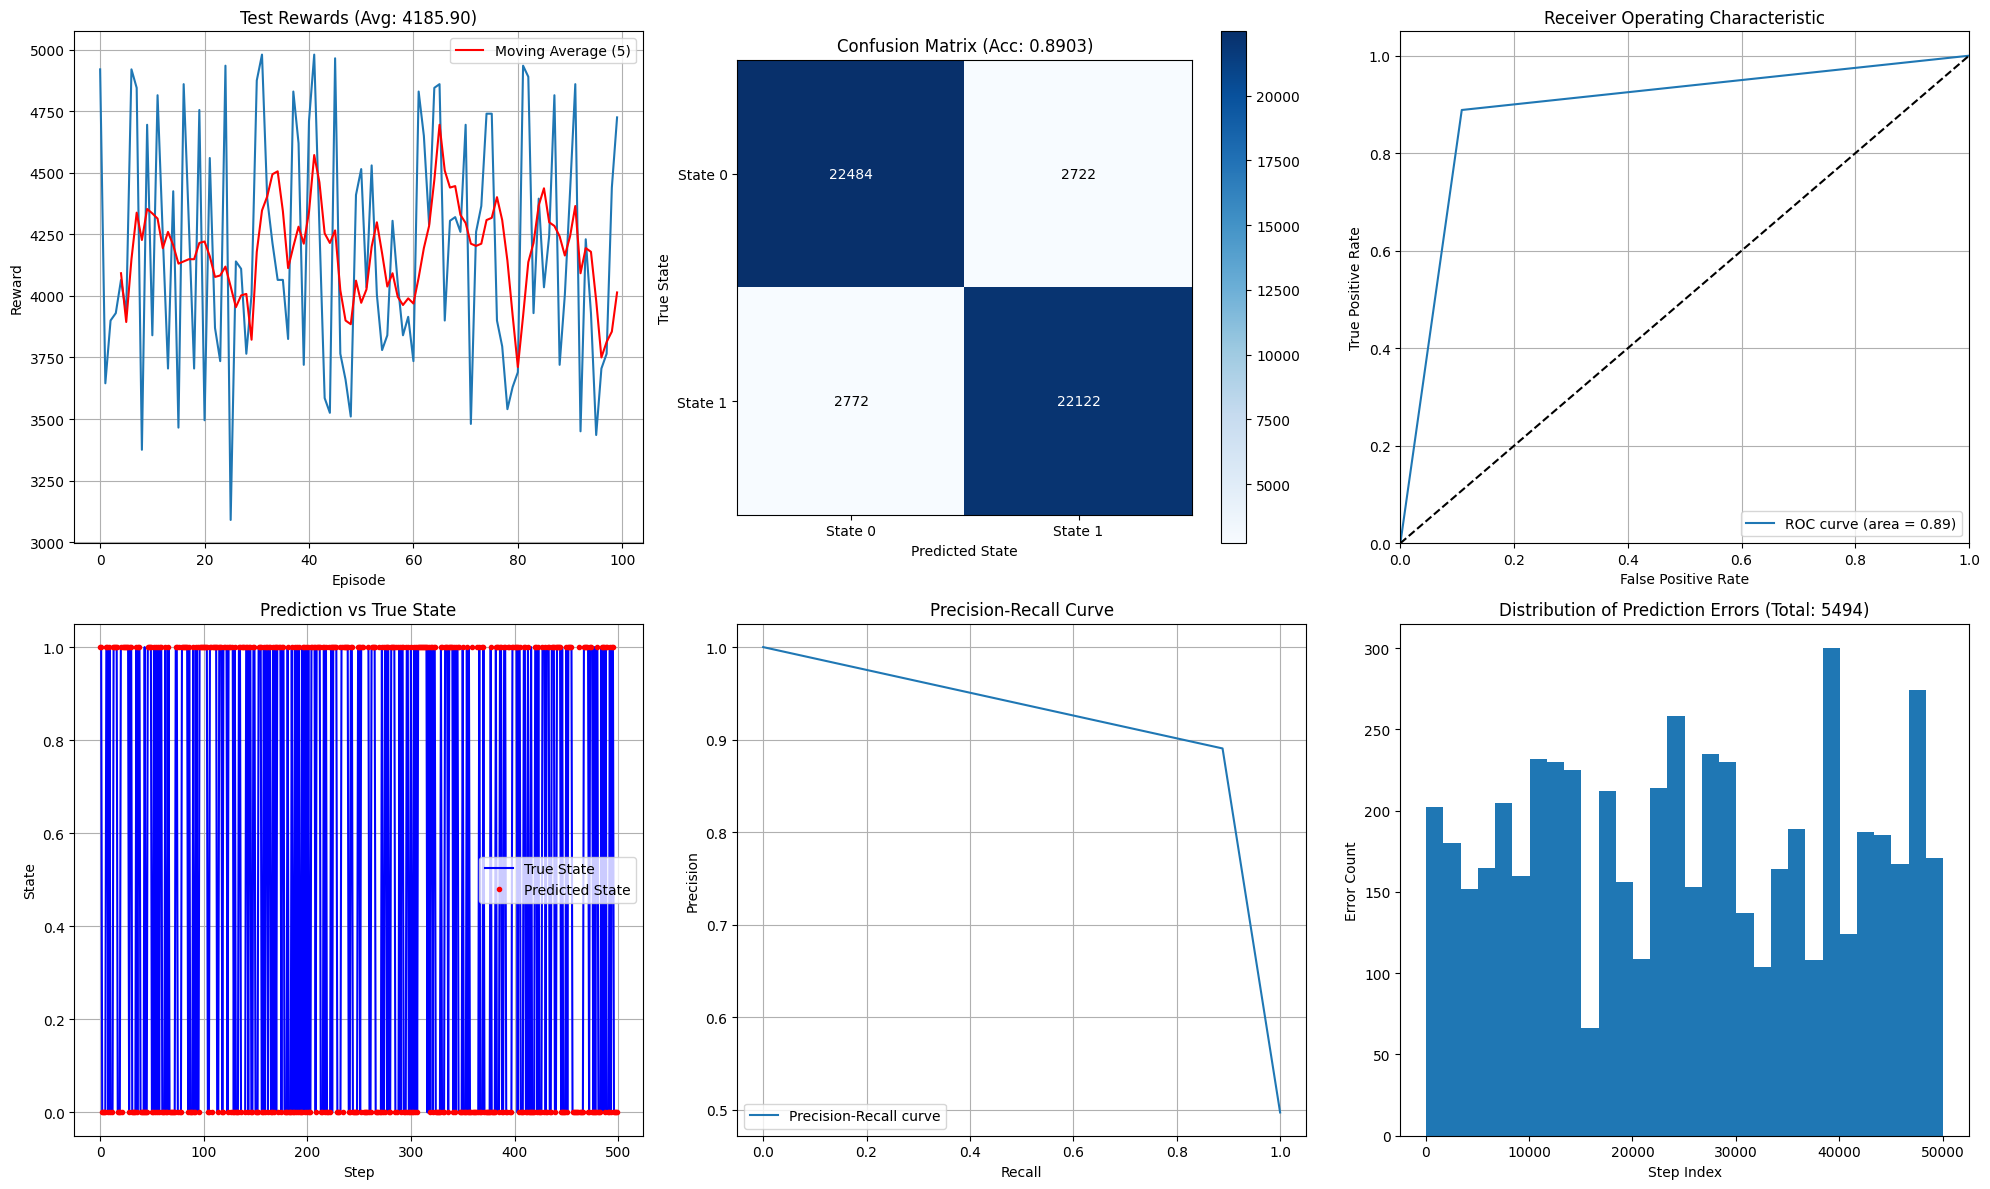


Training vs Test Performance:
Training accuracy: 0.8593
Test accuracy: 0.8903
Accuracy difference: 0.0310
Model generalizes well to the test environment.


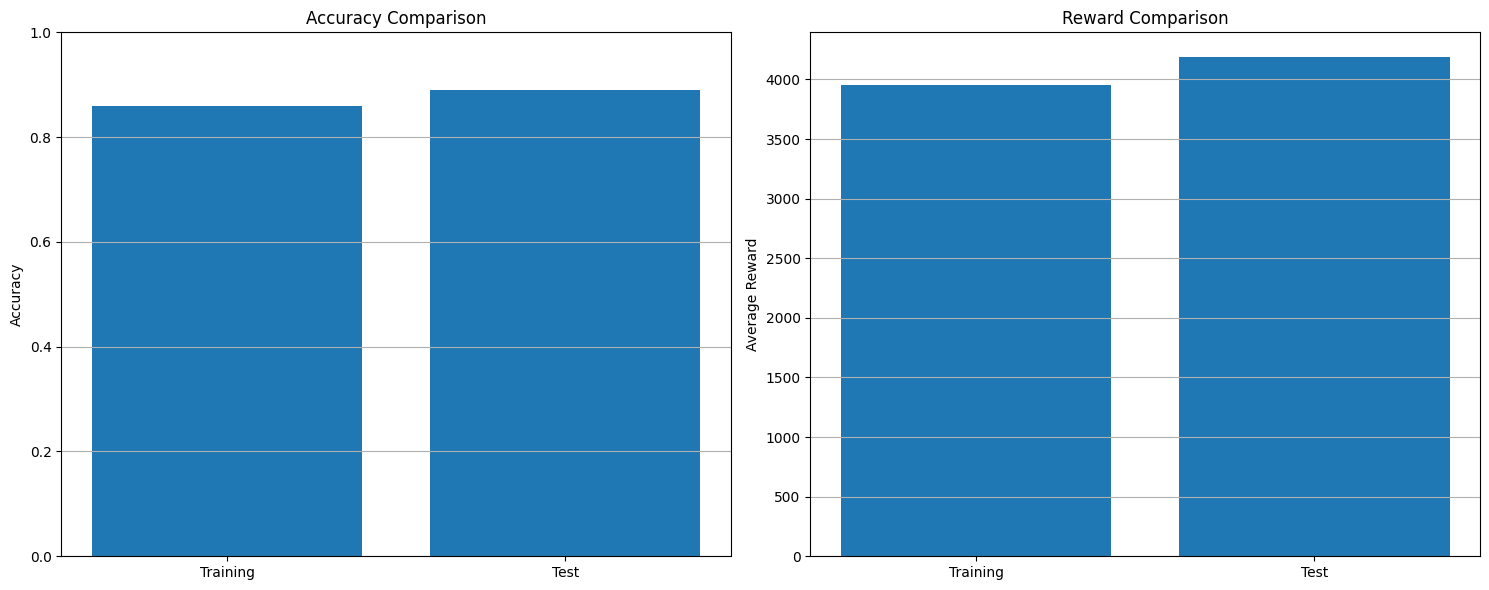

Experiment with separate testing completed!


In [ ]:
time_dependence = 2
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)

Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_312686/3901439464.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_312686/3901439464.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:11<09:23,  1.15s/it]

Episode: 10, Reward: 4305.00, Avg Reward (last 10): 3009.00, Accuracy: 0.9062, Loss: 2.677978, Epsilon: 0.0100
New best model saved! Avg reward: 3009.00


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:12<09:23,  1.15s/it]

New best model saved! Avg reward: 3351.00


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:13<09:23,  1.15s/it]

New best model saved! Avg reward: 3589.50


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:14<09:23,  1.16s/it]

New best model saved! Avg reward: 3895.50


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:16<09:21,  1.16s/it]

New best model saved! Avg reward: 4111.50


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:17<09:22,  1.16s/it]

New best model saved! Avg reward: 4146.00


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:18<09:24,  1.17s/it]

New best model saved! Avg reward: 4155.00


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:21<09:26,  1.18s/it]

Episode: 20, Reward: 4620.00, Avg Reward (last 10): 4182.00, Accuracy: 0.9481, Loss: 2.432247, Epsilon: 0.0100
New best model saved! Avg reward: 4182.00


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:23<10:34,  1.32s/it]

Evaluation at episode 20: Reward = 4455.00


Training Enhanced LSTM-DQN:   4%|▍         | 22/500 [00:25<10:00,  1.26s/it]

New best model saved! Avg reward: 4272.00


Training Enhanced LSTM-DQN:   5%|▍         | 23/500 [00:27<09:51,  1.24s/it]

New best model saved! Avg reward: 4296.00


Training Enhanced LSTM-DQN:   5%|▌         | 26/500 [00:30<09:39,  1.22s/it]

New best model saved! Avg reward: 4297.50


Training Enhanced LSTM-DQN:   5%|▌         | 27/500 [00:31<09:34,  1.21s/it]

New best model saved! Avg reward: 4351.50


Training Enhanced LSTM-DQN:   6%|▌         | 28/500 [00:33<09:30,  1.21s/it]

New best model saved! Avg reward: 4357.50


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [00:35<09:32,  1.22s/it]

Episode: 30, Reward: 3540.00, Avg Reward (last 10): 4174.50, Accuracy: 0.8044, Loss: 2.475370, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [00:46<09:48,  1.28s/it]

Episode: 40, Reward: 4770.00, Avg Reward (last 10): 4147.50, Accuracy: 0.9681, Loss: 2.505371, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [00:48<10:53,  1.42s/it]

Evaluation at episode 40: Reward = 4830.00


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [01:01<09:52,  1.32s/it]

Episode: 50, Reward: 3510.00, Avg Reward (last 10): 4020.00, Accuracy: 0.8004, Loss: 2.343635, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  11%|█▏        | 57/500 [01:12<09:23,  1.27s/it]

Early stopping after 58 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8590


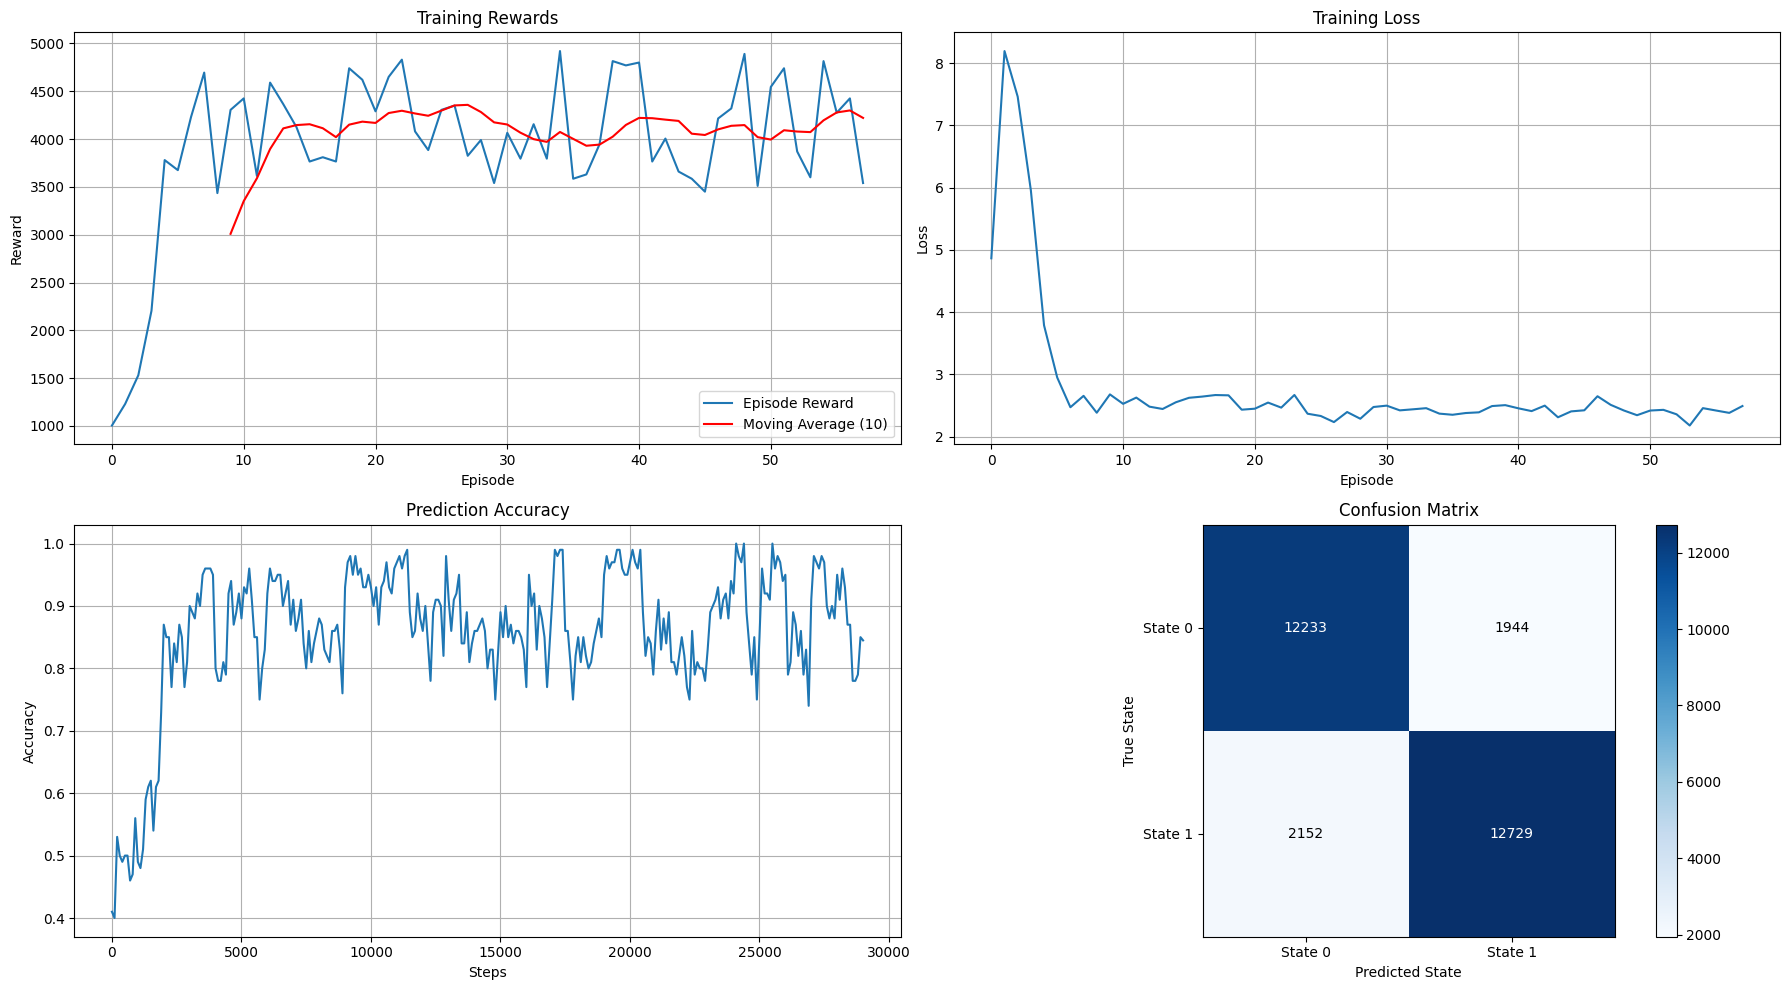


Evaluating on test environment...
Test episode 10/100 completed. Reward: 3840.00
Test episode 20/100 completed. Reward: 3750.00
Test episode 30/100 completed. Reward: 3510.00
Test episode 40/100 completed. Reward: 4575.00
Test episode 50/100 completed. Reward: 3705.00
Test episode 60/100 completed. Reward: 4950.00
Test episode 70/100 completed. Reward: 3900.00
Test episode 80/100 completed. Reward: 3510.00
Test episode 90/100 completed. Reward: 4260.00
Test episode 100/100 completed. Reward: 3615.00

Test Results Summary:
Average reward: 4211.10
Prediction accuracy: 0.8937


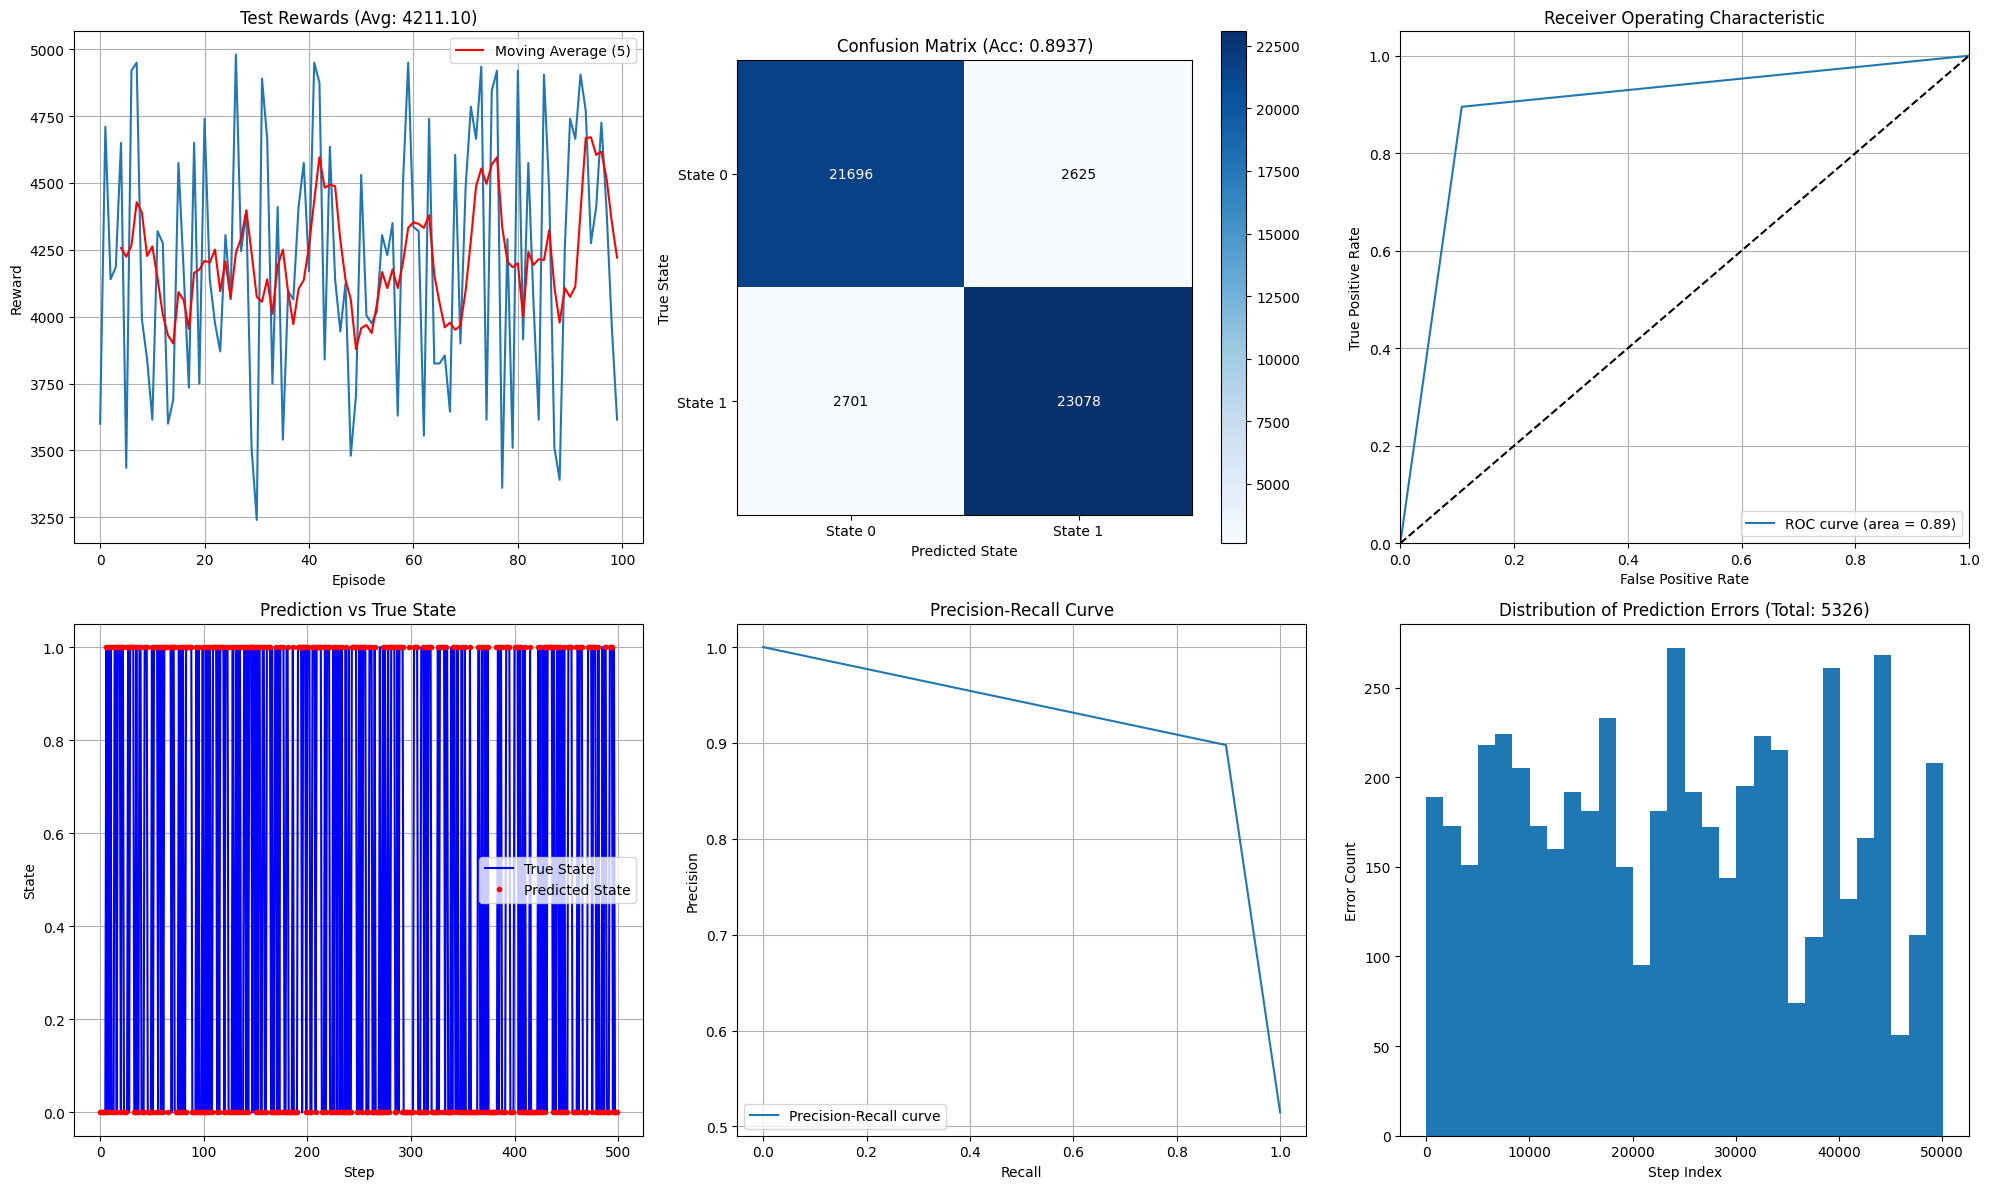


Training vs Test Performance:
Training accuracy: 0.8590
Test accuracy: 0.8937
Accuracy difference: 0.0347
Model generalizes well to the test environment.


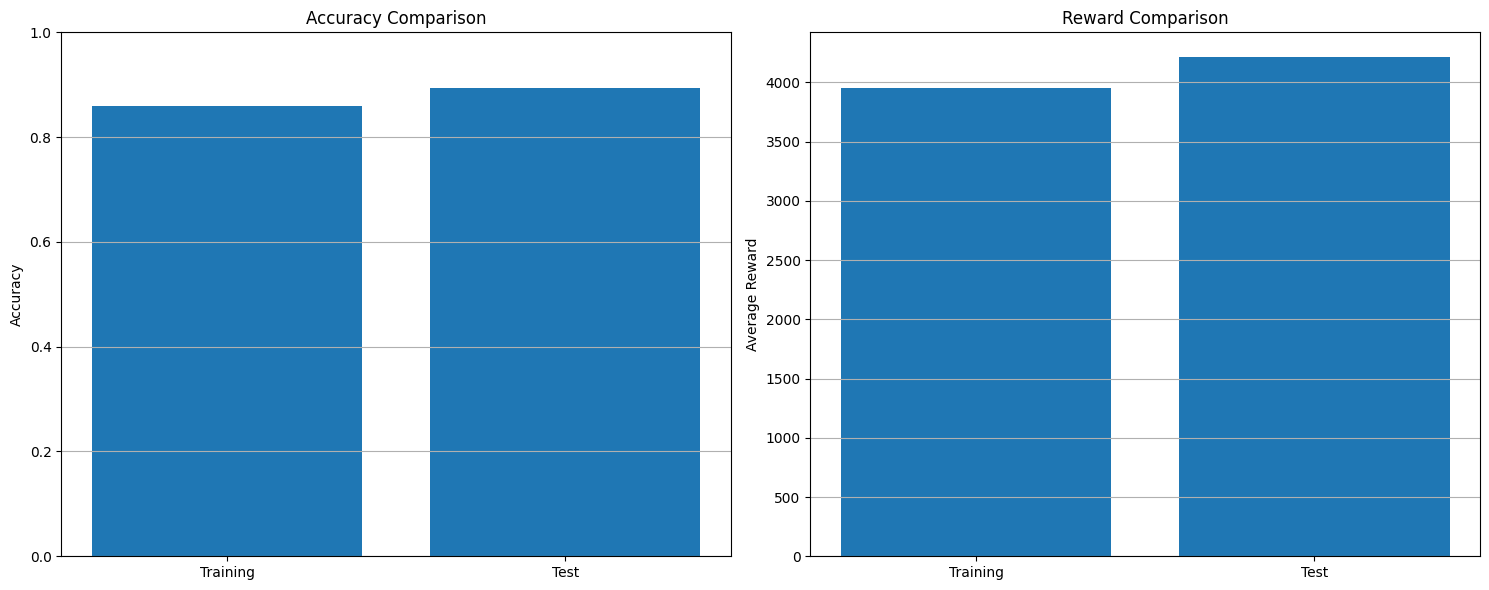

Experiment with separate testing completed!


In [ ]:
time_dependence = 4
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)

Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_312686/3901439464.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_312686/3901439464.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:11<09:24,  1.15s/it]

Episode: 10, Reward: 3840.00, Avg Reward (last 10): 2214.00, Accuracy: 0.8443, Loss: 2.921985, Epsilon: 0.0100
New best model saved! Avg reward: 2214.00


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:12<09:22,  1.15s/it]

New best model saved! Avg reward: 2392.50


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:13<09:20,  1.15s/it]

New best model saved! Avg reward: 2643.00


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:14<09:19,  1.15s/it]

New best model saved! Avg reward: 2884.50


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:16<09:19,  1.15s/it]

New best model saved! Avg reward: 3145.50


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:17<09:20,  1.16s/it]

New best model saved! Avg reward: 3384.00


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:18<09:21,  1.16s/it]

New best model saved! Avg reward: 3706.50


Training Enhanced LSTM-DQN:   3%|▎         | 17/500 [00:19<09:21,  1.16s/it]

New best model saved! Avg reward: 3804.00


Training Enhanced LSTM-DQN:   4%|▎         | 18/500 [00:20<09:21,  1.17s/it]

New best model saved! Avg reward: 3958.50


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:21<09:25,  1.18s/it]

New best model saved! Avg reward: 3961.50
Episode: 20, Reward: 4920.00, Avg Reward (last 10): 4069.50, Accuracy: 0.9880, Loss: 3.363462, Epsilon: 0.0100
New best model saved! Avg reward: 4069.50


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:23<10:36,  1.33s/it]

Evaluation at episode 20: Reward = 4725.00


Training Enhanced LSTM-DQN:   4%|▍         | 21/500 [00:24<10:19,  1.29s/it]

New best model saved! Avg reward: 4150.50


Training Enhanced LSTM-DQN:   4%|▍         | 22/500 [00:26<10:12,  1.28s/it]

New best model saved! Avg reward: 4269.00


Training Enhanced LSTM-DQN:   5%|▍         | 23/500 [00:27<10:04,  1.27s/it]

New best model saved! Avg reward: 4329.00


Training Enhanced LSTM-DQN:   5%|▌         | 27/500 [00:32<09:54,  1.26s/it]

New best model saved! Avg reward: 4375.50


Training Enhanced LSTM-DQN:   6%|▌         | 28/500 [00:33<09:50,  1.25s/it]

New best model saved! Avg reward: 4396.50


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [00:36<09:50,  1.26s/it]

Episode: 30, Reward: 4755.00, Avg Reward (last 10): 4324.50, Accuracy: 0.9661, Loss: 2.839020, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [00:47<09:50,  1.28s/it]

Episode: 40, Reward: 3885.00, Avg Reward (last 10): 4059.00, Accuracy: 0.8503, Loss: 2.773492, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [00:49<10:54,  1.42s/it]

Evaluation at episode 40: Reward = 4755.00


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [01:02<10:00,  1.34s/it]

Episode: 50, Reward: 3750.00, Avg Reward (last 10): 4290.00, Accuracy: 0.8323, Loss: 2.551919, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  10%|█         | 51/500 [01:03<10:00,  1.34s/it]

New best model saved! Avg reward: 4399.50


Training Enhanced LSTM-DQN:  12%|█▏        | 59/500 [01:14<10:17,  1.40s/it]

Episode: 60, Reward: 3420.00, Avg Reward (last 10): 3961.50, Accuracy: 0.7884, Loss: 2.728034, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 60/500 [01:16<11:13,  1.53s/it]

Evaluation at episode 60: Reward = 4065.00


Training Enhanced LSTM-DQN:  14%|█▍        | 70/500 [01:30<10:03,  1.40s/it]

Episode: 70, Reward: 4815.00, Avg Reward (last 10): 4242.00, Accuracy: 0.9741, Loss: 2.460395, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  16%|█▌        | 79/500 [01:43<10:08,  1.45s/it]

Episode: 80, Reward: 4185.00, Avg Reward (last 10): 4021.50, Accuracy: 0.8902, Loss: 2.539262, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  16%|█▌        | 80/500 [01:45<11:06,  1.59s/it]

Evaluation at episode 80: Reward = 3900.00


Training Enhanced LSTM-DQN:  16%|█▌        | 80/500 [01:47<09:21,  1.34s/it]

Early stopping after 81 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8522


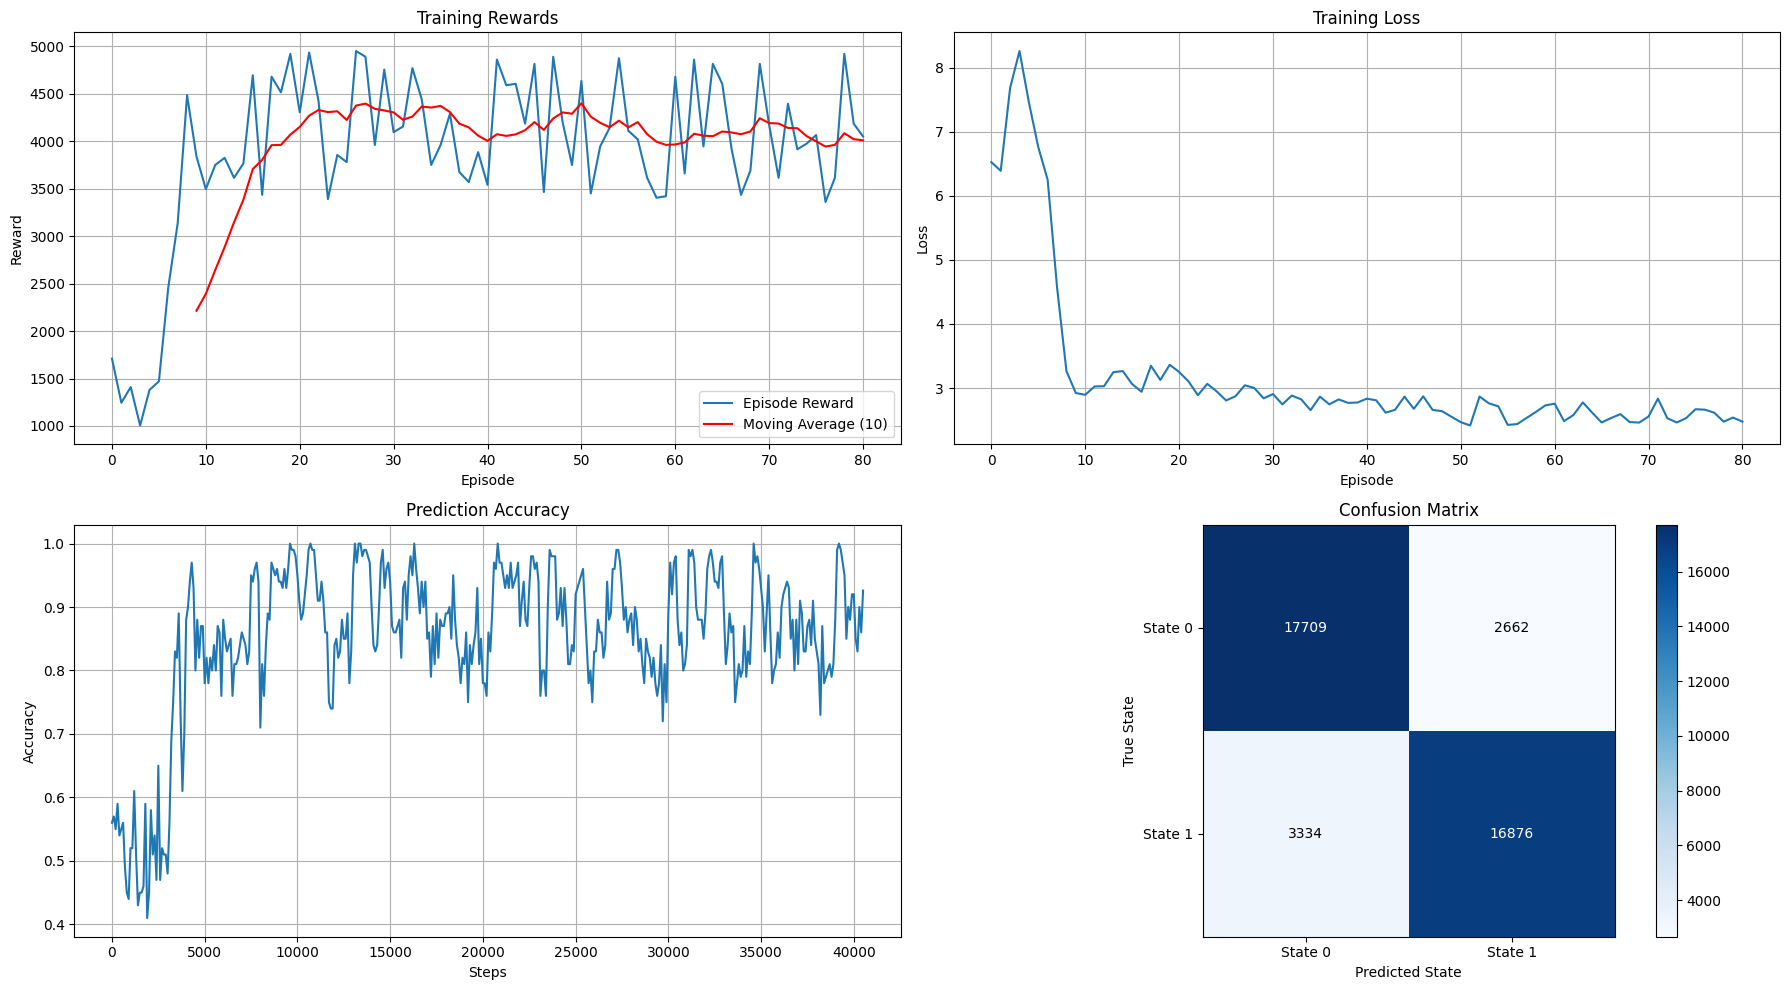


Evaluating on test environment...
Test episode 10/100 completed. Reward: 4755.00
Test episode 20/100 completed. Reward: 4065.00
Test episode 30/100 completed. Reward: 3480.00
Test episode 40/100 completed. Reward: 3765.00
Test episode 50/100 completed. Reward: 4185.00
Test episode 60/100 completed. Reward: 4950.00
Test episode 70/100 completed. Reward: 3990.00
Test episode 80/100 completed. Reward: 3780.00
Test episode 90/100 completed. Reward: 4890.00
Test episode 100/100 completed. Reward: 4860.00

Test Results Summary:
Average reward: 4188.60
Prediction accuracy: 0.8907


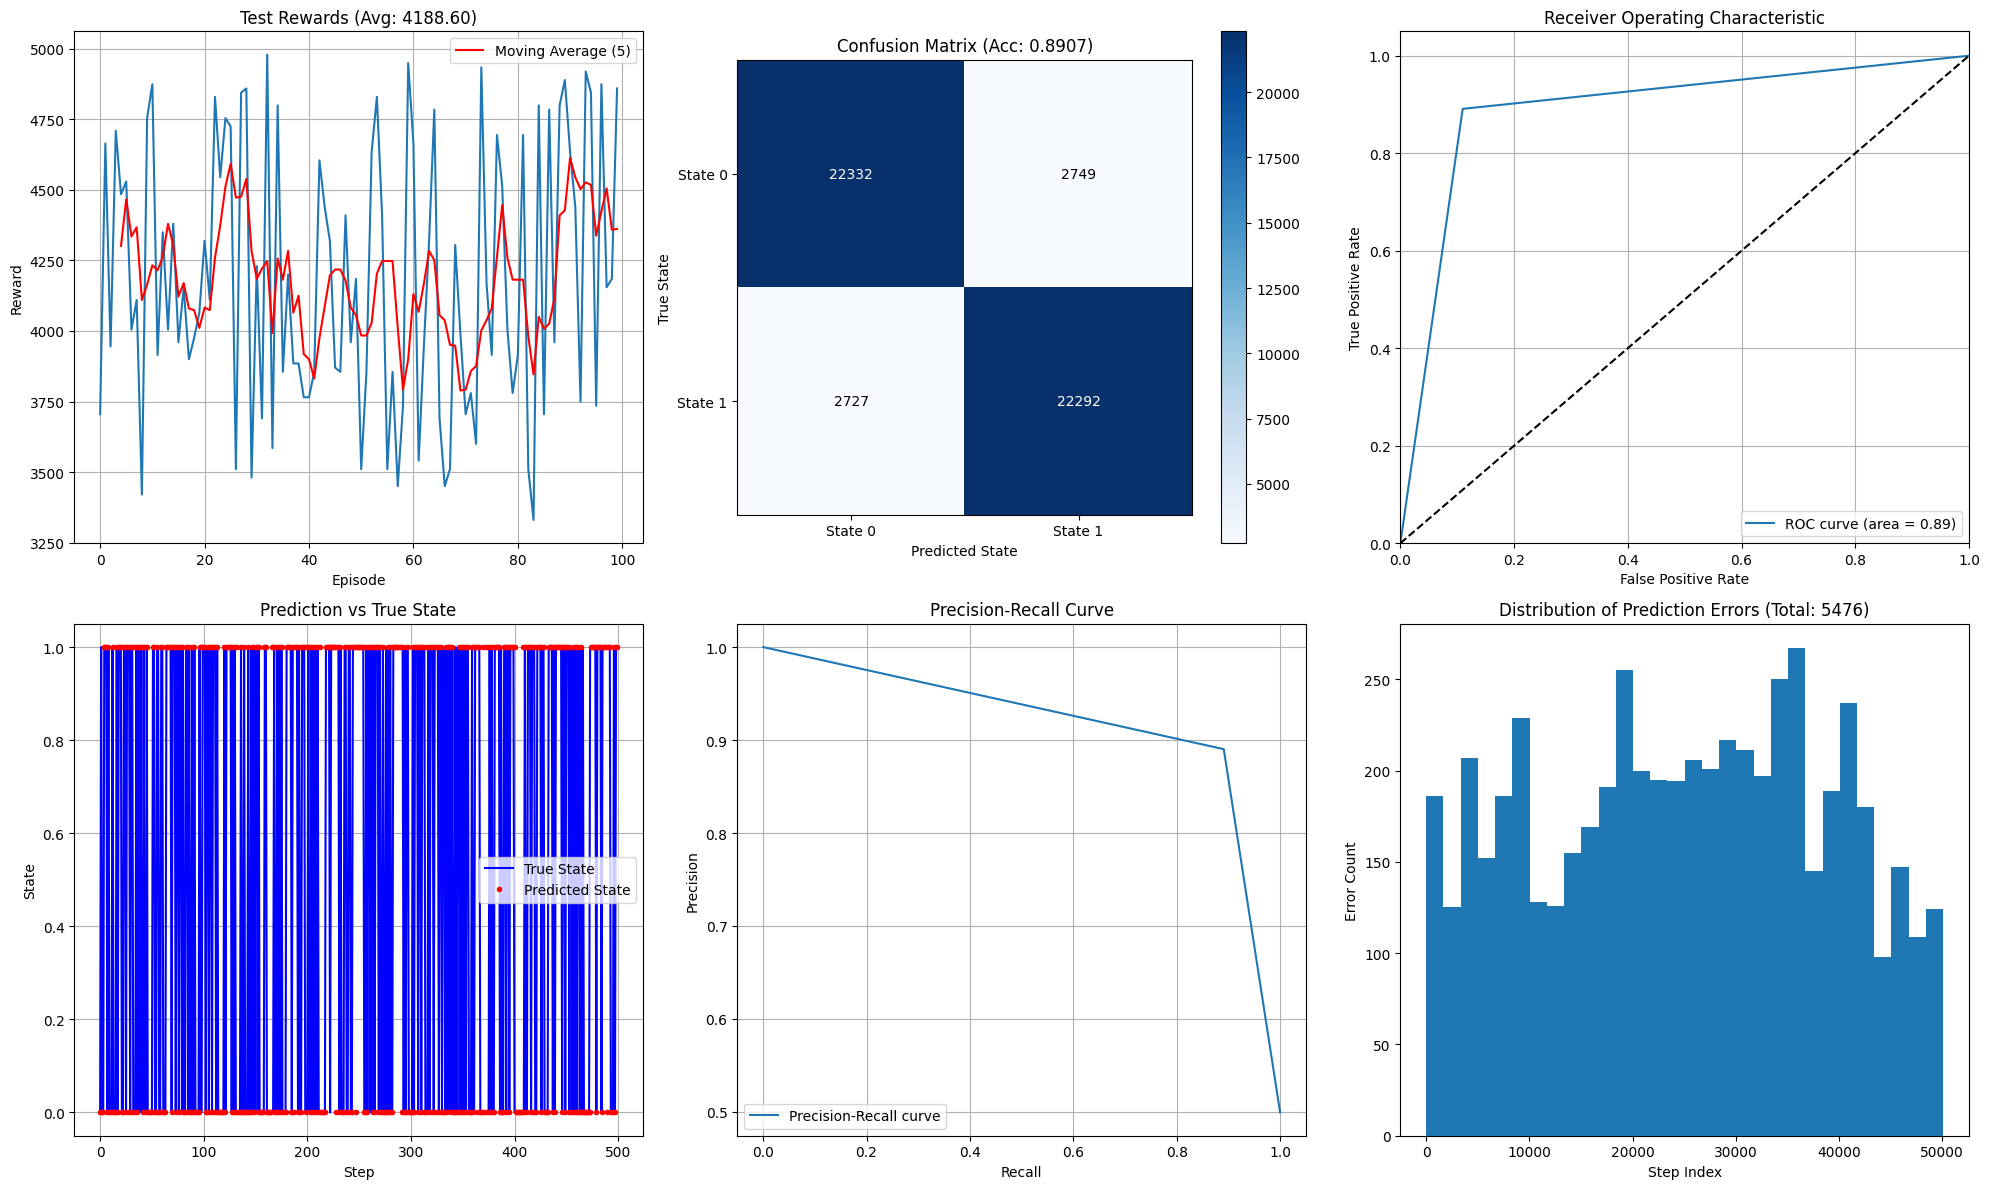


Training vs Test Performance:
Training accuracy: 0.8522
Test accuracy: 0.8907
Accuracy difference: 0.0385
Model generalizes well to the test environment.


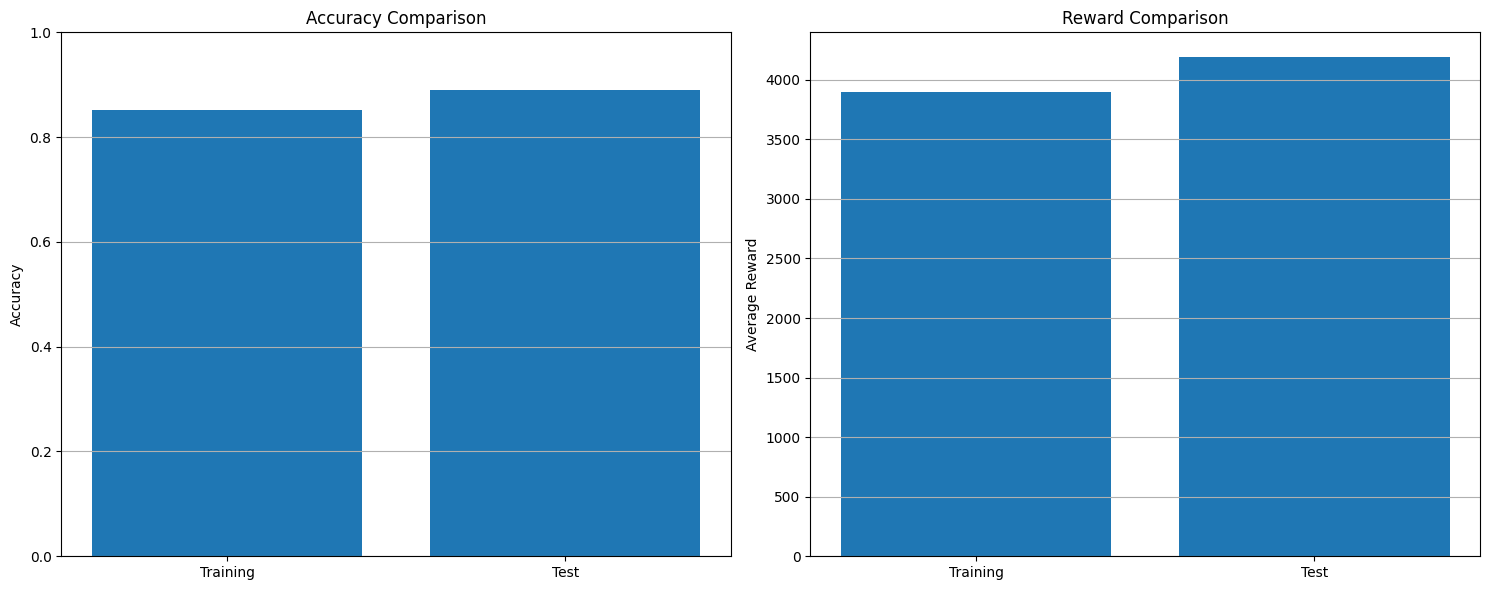

Experiment with separate testing completed!


In [ ]:
time_dependence = 8
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)

Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_312686/3901439464.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_312686/3901439464.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:17<14:37,  1.79s/it]

Episode: 10, Reward: 4545.00, Avg Reward (last 10): 2652.00, Accuracy: 0.9381, Loss: 2.964005, Epsilon: 0.0100
New best model saved! Avg reward: 2652.00


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:19<14:48,  1.82s/it]

New best model saved! Avg reward: 2971.50


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:21<14:49,  1.82s/it]

New best model saved! Avg reward: 3217.50


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:23<14:54,  1.84s/it]

New best model saved! Avg reward: 3444.00


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:25<14:54,  1.84s/it]

New best model saved! Avg reward: 3697.50


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:27<14:57,  1.85s/it]

New best model saved! Avg reward: 3982.50


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:28<14:55,  1.85s/it]

New best model saved! Avg reward: 4092.00


Training Enhanced LSTM-DQN:   4%|▎         | 18/500 [00:32<14:47,  1.84s/it]

New best model saved! Avg reward: 4101.00


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:34<14:52,  1.86s/it]

Episode: 20, Reward: 3675.00, Avg Reward (last 10): 4012.50, Accuracy: 0.8224, Loss: 3.097463, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:37<17:30,  2.19s/it]

Evaluation at episode 20: Reward = 4560.00


Training Enhanced LSTM-DQN:   5%|▍         | 24/500 [00:44<15:16,  1.92s/it]

New best model saved! Avg reward: 4147.50


Training Enhanced LSTM-DQN:   5%|▌         | 27/500 [00:50<14:55,  1.89s/it]

New best model saved! Avg reward: 4153.50


Training Enhanced LSTM-DQN:   6%|▌         | 29/500 [00:54<14:42,  1.87s/it]

New best model saved! Avg reward: 4215.00


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [00:55<14:38,  1.87s/it]

Episode: 30, Reward: 4170.00, Avg Reward (last 10): 4264.50, Accuracy: 0.8882, Loss: 2.881888, Epsilon: 0.0100
New best model saved! Avg reward: 4264.50


Training Enhanced LSTM-DQN:   7%|▋         | 36/500 [01:07<14:41,  1.90s/it]

New best model saved! Avg reward: 4282.50


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [01:13<14:41,  1.91s/it]

Episode: 40, Reward: 4185.00, Avg Reward (last 10): 4158.00, Accuracy: 0.8902, Loss: 2.668217, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [01:16<16:58,  2.21s/it]

Evaluation at episode 40: Reward = 3795.00


Training Enhanced LSTM-DQN:   9%|▉         | 46/500 [01:27<14:51,  1.96s/it]

New best model saved! Avg reward: 4294.50


Training Enhanced LSTM-DQN:   9%|▉         | 47/500 [01:29<14:51,  1.97s/it]

New best model saved! Avg reward: 4303.50


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [01:35<14:49,  1.98s/it]

Episode: 50, Reward: 4785.00, Avg Reward (last 10): 4272.00, Accuracy: 0.9701, Loss: 2.444743, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 59/500 [01:53<14:44,  2.01s/it]

Episode: 60, Reward: 4815.00, Avg Reward (last 10): 4201.50, Accuracy: 0.9741, Loss: 2.586960, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 60/500 [01:56<17:05,  2.33s/it]

Evaluation at episode 60: Reward = 4020.00


Training Enhanced LSTM-DQN:  13%|█▎        | 63/500 [02:02<15:23,  2.11s/it]

New best model saved! Avg reward: 4345.50


Training Enhanced LSTM-DQN:  14%|█▍        | 70/500 [02:16<14:32,  2.03s/it]

Episode: 70, Reward: 3405.00, Avg Reward (last 10): 4008.00, Accuracy: 0.7864, Loss: 2.412779, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  16%|█▌        | 79/500 [02:35<14:30,  2.07s/it]

Episode: 80, Reward: 3765.00, Avg Reward (last 10): 4311.00, Accuracy: 0.8343, Loss: 2.437745, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  16%|█▌        | 80/500 [02:38<16:51,  2.41s/it]

Evaluation at episode 80: Reward = 3615.00


Training Enhanced LSTM-DQN:  18%|█▊        | 90/500 [02:59<14:26,  2.11s/it]

Episode: 90, Reward: 3645.00, Avg Reward (last 10): 4024.50, Accuracy: 0.8184, Loss: 2.223908, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  18%|█▊        | 92/500 [03:05<13:43,  2.02s/it]

Early stopping after 93 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8676


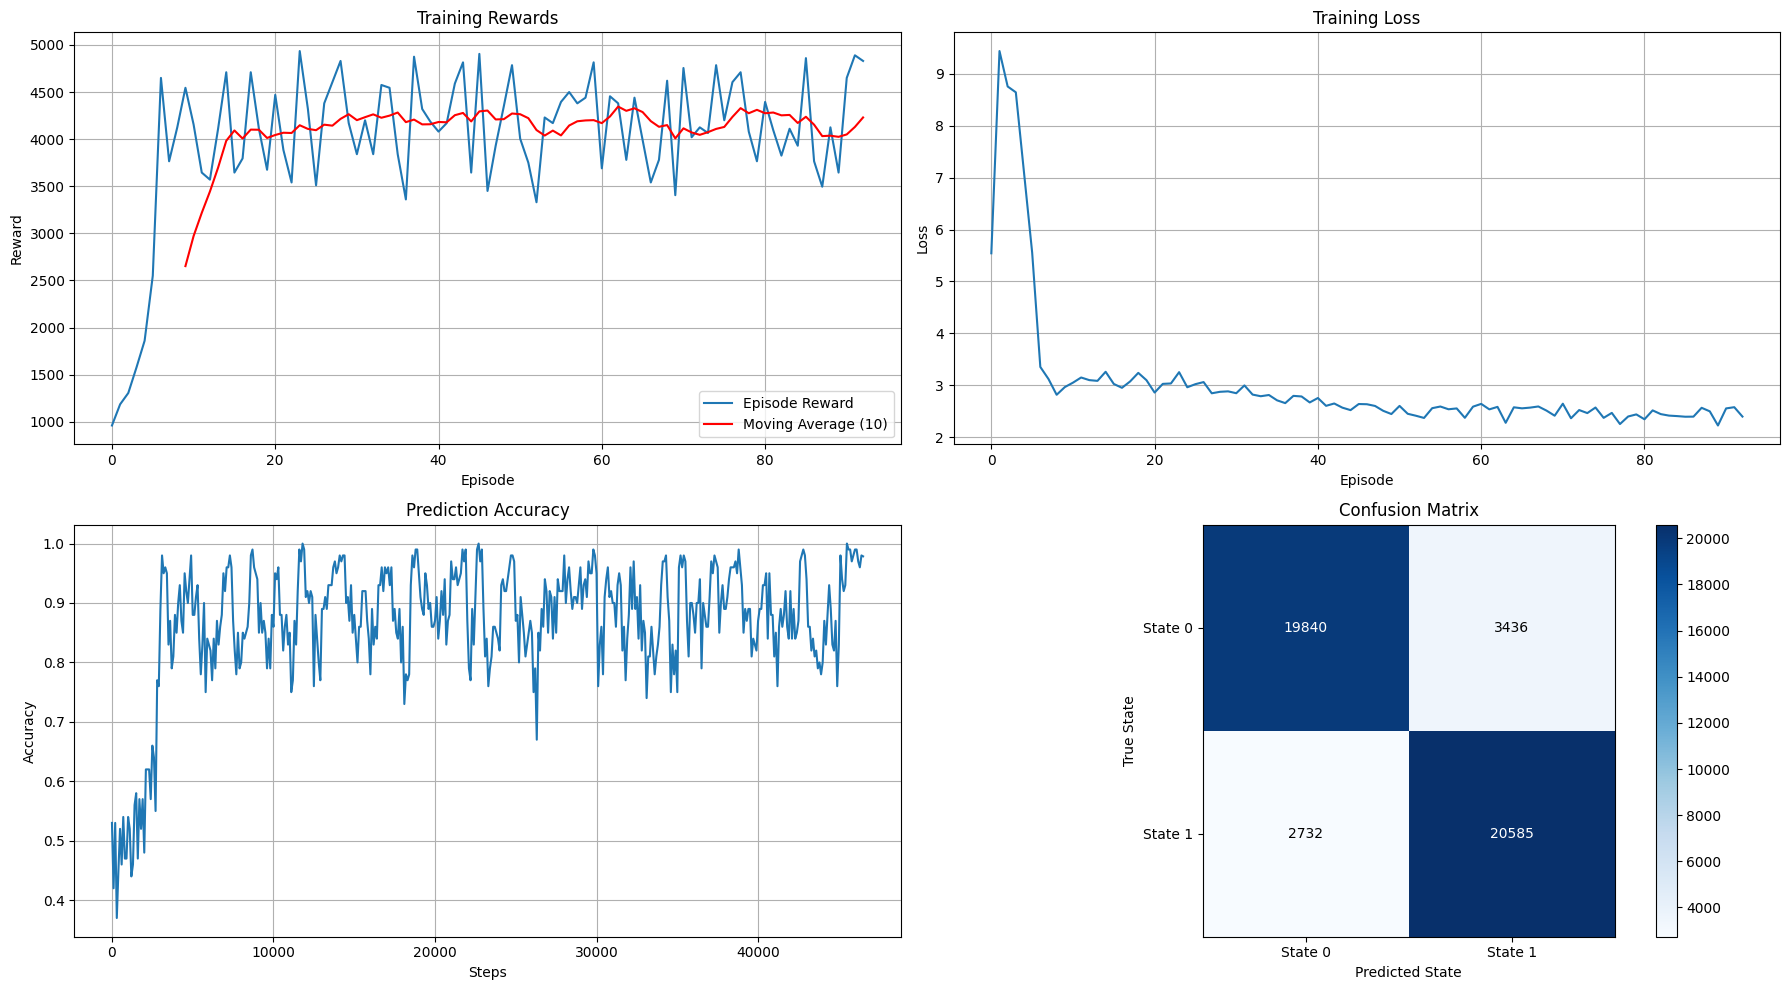


Evaluating on test environment...
Test episode 10/100 completed. Reward: 3900.00
Test episode 20/100 completed. Reward: 4440.00
Test episode 30/100 completed. Reward: 4440.00
Test episode 40/100 completed. Reward: 4920.00
Test episode 50/100 completed. Reward: 3930.00
Test episode 60/100 completed. Reward: 3480.00
Test episode 70/100 completed. Reward: 3855.00
Test episode 80/100 completed. Reward: 4635.00
Test episode 90/100 completed. Reward: 4110.00
Test episode 100/100 completed. Reward: 4770.00

Test Results Summary:
Average reward: 4204.35
Prediction accuracy: 0.8928


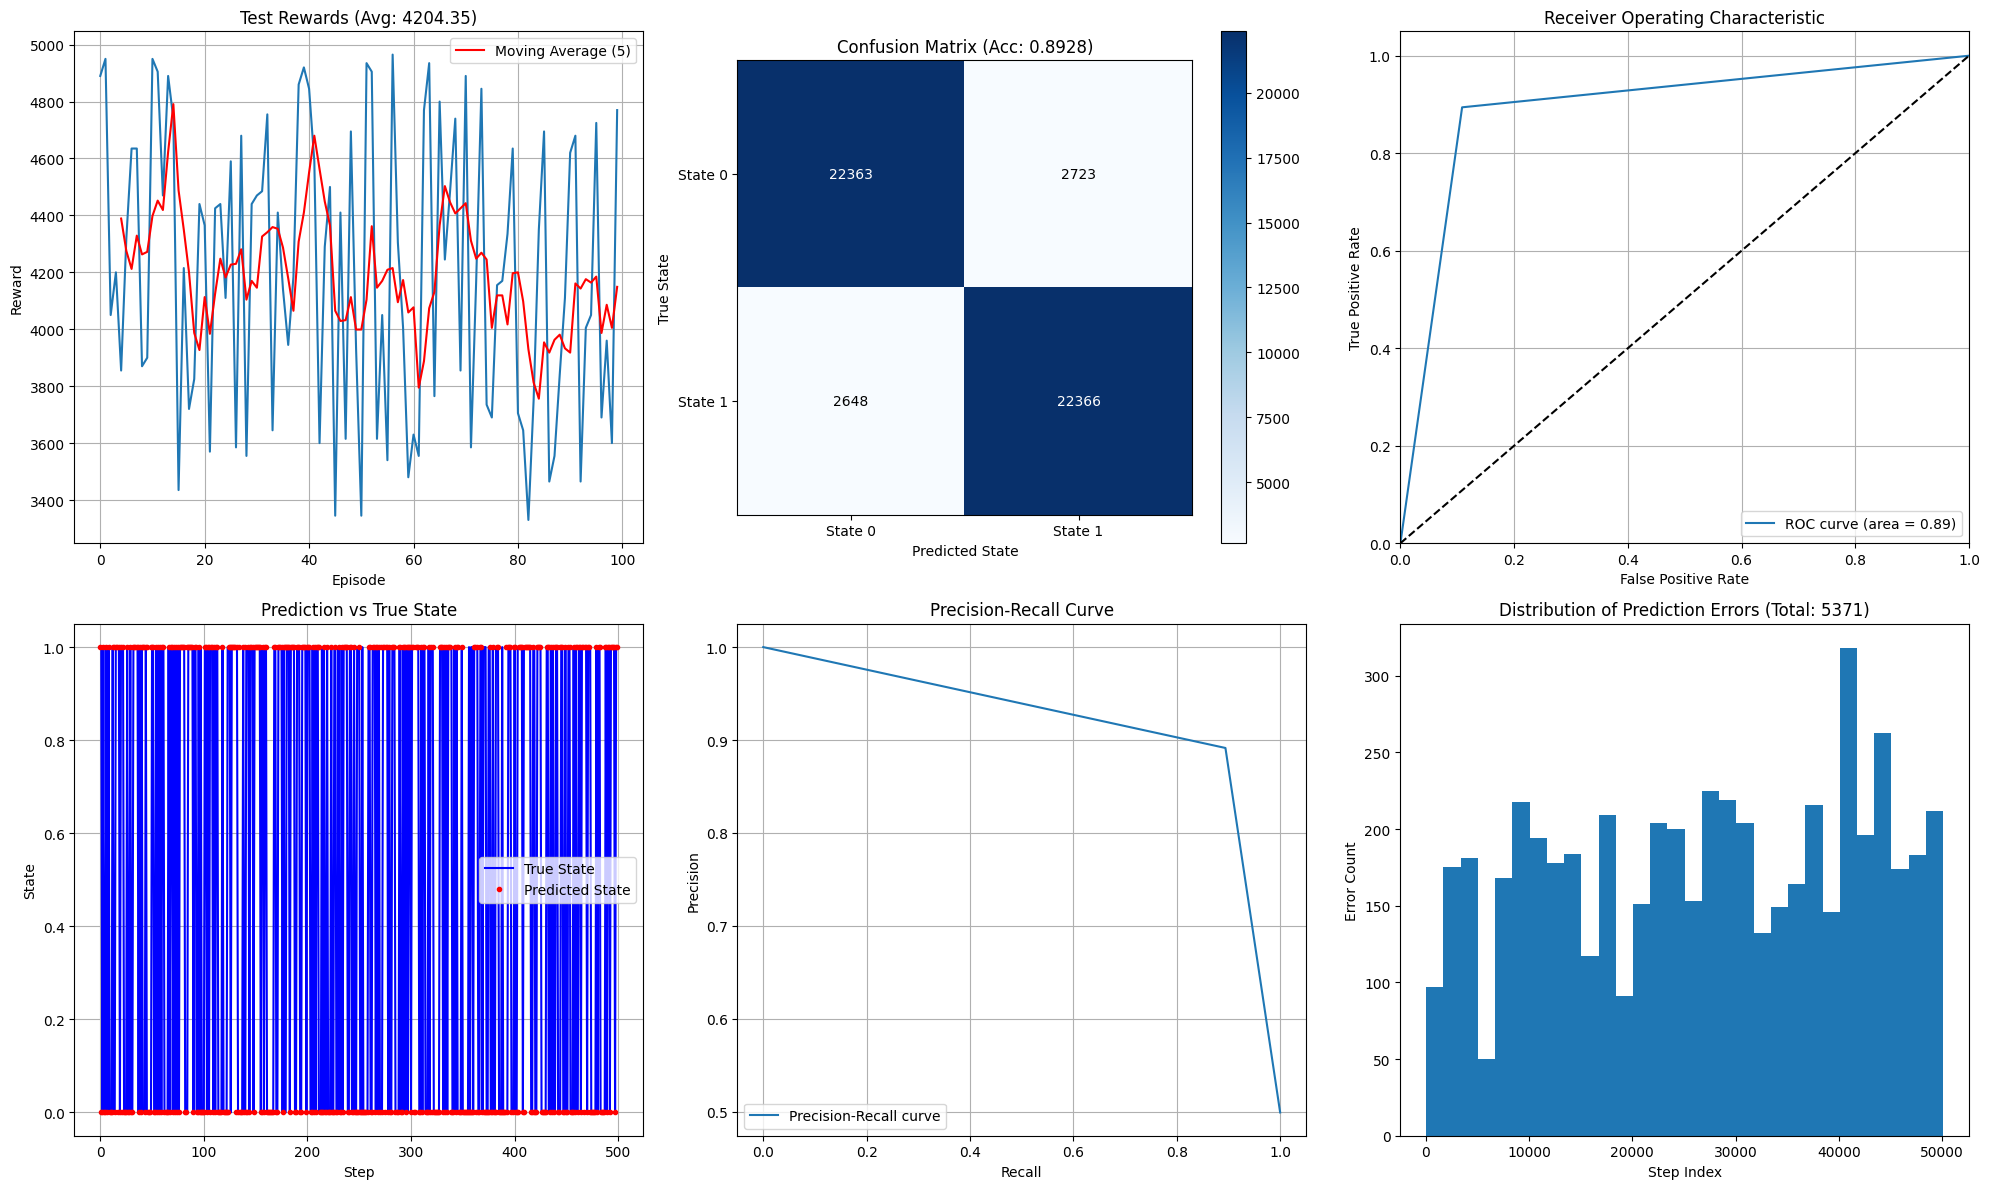


Training vs Test Performance:
Training accuracy: 0.8676
Test accuracy: 0.8928
Accuracy difference: 0.0252
Model generalizes well to the test environment.


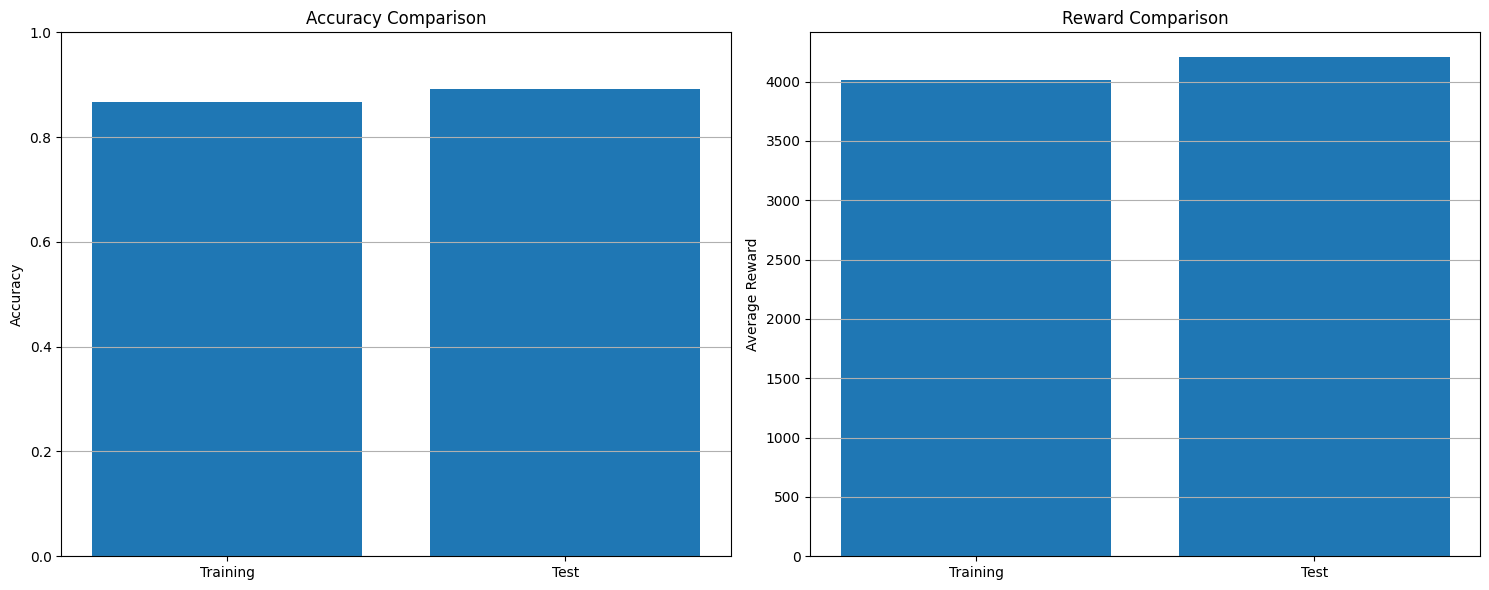

Experiment with separate testing completed!


In [ ]:
time_dependence = 16
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)